# **DCE Pipeline**

## **Local Computer**

### **R Script**

In [ ]:
# Disclaimer: Since DCE measures the causal effect on RNA expression, only edges that represent an impact on the transcription level or a continuous reaction between enzymes are reasonable to include in the model.
# ECrel(enzym-enzym): allows capturing the pathway enzyme → metabolite → enzyme. Although not directly regulating transcription, ECrel still represents a functional dependency between two genes that DCE can detect differences in the causal effect of these enzymes.
# GErel(gene expression): directly reflects the regulatory/suggestive relationship of decreasing/increasing the expression of the target gene, very suitable for causal analysis on expression levels.
# PPrel(protein-protein): only describes the “meeting” (binding, complex formation) between two proteins (protein interaction), occurring after the transcription stage - does not directly reflect the causal effect on RNA expression and easily make noise to causal effects model at the gene expression level.
# The official KEGG release on April 1, 2025 is Release 114.0


# Load necessary libraries
library(xml2)
library(dplyr)
library(stringr)

# Function to parse KEGG pathway XML and extract gene-gene relationships
extract_gene_pairs <- function(filepath) {
  # Extract pathway ID from filename
  pathway_id <- str_extract(basename(filepath), "hsa\\d+")
  
  # Read XML content
  tryCatch({
    xml_content <- xml2::read_xml(filepath)
    
    # Extract all entries
    entries <- xml_find_all(xml_content, "//entry")
    
    # Create a lookup table for entry IDs with their type and gene symbols
    entry_lookup <- data.frame(
      id = character(),
      type = character(),
      gene_symbols = character(),
      stringsAsFactors = FALSE
    )
    
    for (entry in entries) {
      entry_id <- xml_attr(entry, "id")
      entry_type <- xml_attr(entry, "type")
      
      if (entry_type == "gene") {
        graphics <- xml_find_first(entry, "./graphics")
        if (!is.na(graphics)) {
          gene_names <- xml_attr(graphics, "name")
          gene_symbol <- strsplit(gene_names, ",\\s*|\\.\\.\\.")[[1]][1]
        } else {
          gene_symbol <- xml_attr(entry, "name")
        }
        entry_lookup <- rbind(entry_lookup, data.frame(
          id = entry_id,
          type = entry_type,
          gene_symbols = gene_symbol,
          stringsAsFactors = FALSE
        ))
      } else {
        entry_lookup <- rbind(entry_lookup, data.frame(
          id = entry_id,
          type = entry_type,
          gene_symbols = NA_character_,
          stringsAsFactors = FALSE
        ))
      }
    }
    
    # Extract all relations
    relations <- xml_find_all(xml_content, "//relation")
    
    # Build direct gene-gene relationships based on ECrel and GErel relations
    gene_pairs <- data.frame(
      gene_source = character(),
      gene_target = character(),
      relation_type = character(),
      pathway_source = character(),
      stringsAsFactors = FALSE
    )
    
    for (rel in relations) {
      entry1 <- xml_attr(rel, "entry1")
      entry2 <- xml_attr(rel, "entry2")
      rel_type <- xml_attr(rel, "type")
      
      # Check if it's ECrel or GErel
      if (rel_type %in% c("ECrel", "GErel")) {
        src <- filter(entry_lookup, id == entry1, type == "gene")
        tgt <- filter(entry_lookup, id == entry2, type == "gene")
        
        if (nrow(src) > 0 && nrow(tgt) > 0) {
          # Both entries are genes, extract subtypes for GErel if available
          subtype_info <- NA_character_
          
          if (rel_type == "GErel") {
            subtype_nodes <- xml_find_all(rel, "./subtype")
            if (length(subtype_nodes) > 0) {
              subtypes <- sapply(subtype_nodes, function(node) {
                name <- xml_attr(node, "name")
                value <- xml_attr(node, "value")
                paste(name, value, sep = ":")
              })
              subtype_info <- paste(subtypes, collapse = "; ")
            }
          }
          
          gene_pairs <- rbind(gene_pairs, data.frame(
            gene_source = src$gene_symbols,
            gene_target = tgt$gene_symbols,
            relation_type = rel_type,
            relation_subtype = if(rel_type == "GErel") subtype_info else NA,
            pathway_source = pathway_id,
            stringsAsFactors = FALSE
          ))
        }
      }
    }
    
    # Remove duplicate pairs within this pathway
    gene_pairs <- distinct(gene_pairs)
    return(gene_pairs)
  }, error = function(e) {
    warning(paste("Error processing file:", filepath, "-", e$message))
    return(data.frame(
      gene_source = character(),
      gene_target = character(),
      relation_type = character(),
      relation_subtype = character(),
      pathway_source = character(), 
      stringsAsFactors = FALSE
    ))
  })
}

# Process all XML files in the folder
process_all_files <- function(folder_path) {
  # Get list of all XML files
  xml_files <- list.files(folder_path, pattern = "\\.xml$", full.names = TRUE)
  
  cat("Found", length(xml_files), "XML files to process\n")
  
  # Initialize an empty data frame to store all gene pairs
  all_gene_pairs <- data.frame(
    gene_source = character(),
    gene_target = character(),
    relation_type = character(),
    relation_subtype = character(),
    pathway_source = character(),
    stringsAsFactors = FALSE
  )
  
  # Process each file
  for (i in seq_along(xml_files)) {
    file <- xml_files[i]
    cat("Processing file", i, "of", length(xml_files), "-", basename(file), "\n")
    
    # Extract gene pairs from the file
    gene_pairs <- extract_gene_pairs(file)
    
    # Append the results to the combined data frame
    all_gene_pairs <- rbind(all_gene_pairs, gene_pairs)
  }
  
  return(all_gene_pairs)
}

# Main execution
folder_path <- "C:/Users/ADMIN/OneDrive - University of South Australia/Datasets/Long-covid/pathway_kgml"
output_csv <- "all_kegg_gene_pairs.csv"

# Process all files and combine results
all_gene_pairs <- process_all_files(folder_path)

# Remove any potential duplicates across all pathways
all_gene_pairs <- distinct(all_gene_pairs)

# Write the results to a CSV file
write.csv(all_gene_pairs, output_csv, row.names = FALSE)

# Display summary
cat("\nProcessing complete!\n")
cat("Total gene pairs extracted:", nrow(all_gene_pairs), "\n")
cat("Number of ECrel pairs:", sum(all_gene_pairs$relation_type == "ECrel"), "\n")
cat("Number of GErel pairs:", sum(all_gene_pairs$relation_type == "GErel"), "\n")
cat("Results saved to:", output_csv, "\n")

# Display the first few rows
print(head(all_gene_pairs))



## **GADI**

### **Singularity Container Script**

**Singularity Container Script for GADI Supercomputer**

This Singularity definition file creates a containerized R environment optimized for running computationally intensive bioinformatics and data analysis tasks on the GADI supercomputer at the National Computational Infrastructure (NCI) in Australia.

**Overview**

This container addresses the common problem of insufficient computational resources on personal computers for complex R analyses. By containerizing the environment, you can ensure reproducibility and scalability across different systems, particularly when moving from local development to high-performance computing (HPC) environments.

**Container Structure**

**Base Image**

```
Bootstrap: docker
From: rocker/r-ver:4.4.2
```

- **Bootstrap method**: Uses Docker as the bootstrap agent to pull the base image
- **Base image**: `rocker/r-ver:4.4.2` - A lightweight Docker image with R version 4.4.2 pre-installed
- **Why this base**: The Rocker project provides well-maintained, reproducible R environments optimized for scientific computing

**File Dependencies**

```
%files
   libicu60_60.2-3ubuntu3.2_amd64.deb /libicu60_60.2-3ubuntu3.2_amd64.deb
```

- **Purpose**: Copies a specific Ubuntu package for International Components for Unicode (ICU) library
- **Why needed**: Some R packages require specific ICU versions for text processing and internationalization
- **Note**: This .deb file must be present in your build directory before creating the container

**System Configuration (%post section)**

**System Dependencies Installation**
The script installs essential system libraries required for R package compilation:

**Core Development Libraries:**
- `libcurl4-openssl-dev`, `libssl-dev`, `libxml2-dev`: For web scraping and API interactions
- `libicu-dev`: Unicode and text processing support
- `liblapack-dev`, `libblas-dev`, `gfortran`: Linear algebra and mathematical computing

**Graphics and Visualization:**
- `libharfbuzz-dev`, `libfribidi-dev`: Text shaping and bidirectional text support
- `libfontconfig1-dev`, `libfreetype6-dev`: Font management
- `libpng-dev`, `libtiff5-dev`, `libjpeg-dev`, `libcairo2-dev`: Image format support

**Geospatial Analysis:**
- `libgdal-dev`, `libgeos-dev`, `libproj-dev`, `libudunits2-dev`: Geospatial data processing

**Additional Tools:**
- `libxt-dev`: X11 toolkit for GUI components
- `libglpk-dev`: GNU Linear Programming Kit
- `libgit2-dev`: Git integration for version control

**Library Path Configuration**

```bash
mkdir -p /usr/local/lib/R/site-library
mkdir -p /usr/local/lib/R/library
chmod -R 777 /usr/local/lib/R/site-library
chmod -R 777 /usr/local/lib/R/library
```

- **Creates dedicated directories** for R packages to avoid permission issues
- **Sets permissive permissions** to allow package installation from within the container

**R Environment Setup**
The script configures R's library search paths through:
- `Renviron`: Sets environment variables for R library locations
- `Rprofile.site`: Automatically configures library paths when R starts

**R Package Installation**

**CRAN Packages**
The container installs a comprehensive set of packages for:

**Data Manipulation and Analysis:**
- `dplyr`, `tidyr`: Data wrangling and transformation
- `caret`: Classification and regression training
- `foreach`, `doParallel`: Parallel computing support

**Network and Pathway Analysis:**
- `pcalg`: Causal inference and graphical models
- `igraph`: Network analysis and visualization
- `clusterProfiler`: Functional enrichment analysis

**Visualization:**
- `pheatmap`: Heatmap generation
- `ggforce`, `ggraph`, `scatterpie`: Advanced ggplot2 extensions

**Bioconductor Integration**
The script specifically:
1. **Installs BiocManager** for Bioconductor package management
2. **Sets Bioconductor version 3.20** for consistency
3. **Installs specialized bioinformatics packages**:
   - `fgsea`: Fast Gene Set Enrichment Analysis
   - `ggtree`, `treeio`, `tidytree`: Phylogenetic tree visualization
   - `DOSE`, `enrichplot`: Disease ontology and enrichment visualization
   - `Rgraphviz`: Graph visualization
   - `org.Hs.eg.db`: Human genome annotation database

**Running on GADI**

**Container Execution**

```
%runscript
    exec R "$@"
```

This makes the container executable as an R environment, accepting all R command-line arguments.

**GADI-Specific Considerations**

**Resource Allocation:**
- GADI uses PBS Pro job scheduler
- Request appropriate CPU cores and memory based on your analysis requirements
- Consider using multiple nodes for parallel processing

**Storage:**
- Use GADI's `/scratch` filesystem for temporary large datasets
- Store results in your allocated project space
- Consider data transfer times when planning workflows

**Example GADI Job Script:**

```bash
#!/bin/bash
#PBS -P your_project
#PBS -q normal
#PBS -l walltime=24:00:00
#PBS -l mem=64GB
#PBS -l ncpus=16

module load singularity

cd $PBS_O_WORKDIR
singularity exec your_container.sif Rscript your_analysis.R
```

**Building the Container**

1. **Prepare dependencies**: Ensure `libicu60_60.2-3ubuntu3.2_amd64.deb` is in your build directory
2. **Build command**: `sudo singularity build r_analysis.sif Singularity.def`
3. **Transfer to GADI**: Use `scp` or `rsync` to copy the built container to GADI

**Benefits for Computational Biology**

This containerized approach provides:
- **Reproducibility**: Identical environment across development and production
- **Scalability**: Leverage GADI's computational resources
- **Dependency Management**: Pre-compiled packages reduce setup time
- **Version Control**: Consistent package versions prevent compatibility issues
- **Resource Optimization**: Efficient memory and CPU utilization on HPC systems

The container is particularly well-suited for genomics workflows, pathway analysis, network biology, and other computationally intensive bioinformatics tasks that exceed the capabilities of standard desktop computers.

In [ ]:
# =============================================================================
# Singularity Container Definition for R Bioinformatics Environment
# Optimized for GADI Supercomputer at National Computational Infrastructure
# =============================================================================

# Bootstrap method: Use Docker to pull base image
Bootstrap: docker
# Base image: Rocker R version 4.4.2 (lightweight R environment)
From: rocker/r-ver:4.4.2

# =============================================================================
# FILE DEPENDENCIES
# =============================================================================
%files
   # Copy specific ICU library package needed for text processing
   # This file must be present in your build directory
   libicu60_60.2-3ubuntu3.2_amd64.deb /libicu60_60.2-3ubuntu3.2_amd64.deb

# =============================================================================
# CONTAINER BUILD CONFIGURATION
# =============================================================================
%post
    # Update package manager and install essential system dependencies
    # These libraries are required for R package compilation and functionality
    apt-get update && apt-get install -y \
        # Web and networking libraries
        libcurl4-openssl-dev \    # For downloading data and API calls
        libssl-dev \              # SSL/TLS encryption support
        libxml2-dev \             # XML parsing capabilities
        # Text processing and internationalization
        libicu-dev \              # International Components for Unicode
        # Mathematical computing libraries
        liblapack-dev \           # Linear algebra package
        libblas-dev \             # Basic linear algebra subprograms
        gfortran \                # Fortran compiler for numerical packages
        # Text rendering and font management
        libharfbuzz-dev \         # Text shaping library
        libfribidi-dev \          # Bidirectional text support
        libfontconfig1-dev \      # Font configuration library
        libfreetype6-dev \        # Font rendering engine
        # Image processing libraries
        libpng-dev \              # PNG image format support
        libtiff5-dev \            # TIFF image format support
        libjpeg-dev \             # JPEG image format support
        libcairo2-dev \           # 2D graphics library
        # Additional system libraries
        libxt-dev \               # X11 toolkit for GUI components
        libglpk-dev \             # GNU Linear Programming Kit
        libgit2-dev \             # Git version control integration
        # Geospatial analysis libraries
        libgdal-dev \             # Geospatial Data Abstraction Library
        libgeos-dev \             # Geometry Engine Open Source
        libproj-dev \             # Cartographic projections library
        libudunits2-dev           # Units of measurement database

    # Install the specific ICU library version
    # Required for some R packages that need this exact version
    dpkg -i /libicu60_60.2-3ubuntu3.2_amd64.deb

    # ==========================================================================
    # R LIBRARY DIRECTORY SETUP
    # ==========================================================================
    # Create dedicated directories for R package installation
    mkdir -p /usr/local/lib/R/site-library    # User-installed packages
    mkdir -p /usr/local/lib/R/library          # System-wide packages
    
    # Set permissive permissions to avoid installation issues
    # Note: In production, consider more restrictive permissions
    chmod -R 777 /usr/local/lib/R/site-library
    chmod -R 777 /usr/local/lib/R/library

    # ==========================================================================
    # R ENVIRONMENT CONFIGURATION
    # ==========================================================================
    # Create R configuration directory
    mkdir -p /usr/local/lib/R/etc
    
    # Configure R environment variables for library paths
    # These settings ensure R can find installed packages
    echo 'R_LIBS_USER="/usr/local/lib/R/site-library"' >> /usr/local/lib/R/etc/Renviron
    echo 'R_LIBS_SITE="/usr/local/lib/R/site-library:/usr/local/lib/R/library"' >> /usr/local/lib/R/etc/Renviron
    
    # Set default library paths in R startup profile
    # This automatically configures the library search path when R starts
    echo '.libPaths(c("/usr/local/lib/R/site-library", .libPaths()))' >> /usr/local/lib/R/etc/Rprofile.site

    # ==========================================================================
    # CRAN PACKAGE INSTALLATION
    # ==========================================================================
    # Install essential R packages from CRAN repository
    # These packages provide core functionality for data analysis and bioinformatics
    Rscript -e 'install.packages(c(
        # Data manipulation and transformation
        "dplyr",           # Grammar of data manipulation
        "tidyr",           # Tidy data principles
        # Network and causal analysis
        "pcalg",           # Causal inference and PC algorithm
        "igraph",          # Network analysis and visualization
        # Visualization packages
        "pheatmap",        # Pretty heatmaps
        "ggforce",         # Extensions for ggplot2
        "ggraph",          # Grammar of graphics for networks
        "scatterpie",      # Scatter pie plots
        # Machine learning and statistics
        "caret",           # Classification and regression training
        # Parallel computing
        "foreach",         # Foreach looping construct
        "doParallel",      # Parallel backend for foreach
        # Bioconductor integration
        "BiocManager",     # Bioconductor package manager
        # System and font management
        "systemfonts",     # System font access
        # Functional analysis
        "clusterProfiler"  # Statistical analysis of functional profiles
    ), lib="/usr/local/lib/R/site-library", repos="https://cloud.r-project.org/", dependencies=TRUE)'

    # Install specific version of systemfonts to avoid compatibility issues
    # Version 1.0.4 is known to work well with the other packages
    Rscript -e 'remotes::install_version("systemfonts", version = "1.0.4", lib="/usr/local/lib/R/site-library")'

    # ==========================================================================
    # BIOCONDUCTOR SETUP AND PACKAGE INSTALLATION
    # ==========================================================================
    # Ensure BiocManager is available for Bioconductor package management
    Rscript -e 'if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager", lib="/usr/local/lib/R/site-library")'
    
    # Install specific Bioconductor version for consistency and reproducibility
    # Version 3.20 corresponds to R 4.4.x and provides stable package versions
    Rscript -e 'BiocManager::install(version = "3.20", lib="/usr/local/lib/R/site-library", ask=FALSE)'
    
    # Install specialized bioinformatics packages from Bioconductor
    # These packages provide advanced functionality for genomics and systems biology
    Rscript -e 'BiocManager::install(c(
        # Gene set enrichment analysis
        "fgsea",           # Fast Gene Set Enrichment Analysis
        # Phylogenetic analysis and visualization
        "ggtree",          # Grammar of graphics for phylogenetic trees
        "treeio",          # Base classes and functions for phylogenetic tree input/output
        "tidytree",        # Tidy tool for phylogenetic tree data manipulation
        # Functional annotation and enrichment
        "DOSE",            # Disease Ontology Semantic and Enrichment analysis
        "enrichplot",      # Visualization of functional enrichment results
        # Graph visualization
        "Rgraphviz",       # Interface to Graphviz for graph visualization
        # Genome annotation
        "org.Hs.eg.db"    # Human genome annotation database (Homo sapiens)
    ), lib="/usr/local/lib/R/site-library", ask=FALSE, dependencies=TRUE)'

# =============================================================================
# CONTAINER RUNTIME CONFIGURATION
# =============================================================================
%runscript
    # Execute R with any provided command-line arguments
    # This makes the container act as an R environment
    exec R "$@"

In [ ]:

  # Function to compute Differential Causal Effects (DCE) between two conditions
  compute_DCE <- function(
      expr_path1, # Path to expression data for condition 1
      label1,     # Label for condition 1
      expr_path2, # Path to expression data for condition 2
      label2,     # Label for condition 2
      pairs_file, # Path to gene pairs file (from KEGG pathways)
      output_csv, # Path to save results
      p_thresh = 0.05, # P-value threshold for significance
      adj_method = "fdr" # Method for p-value adjustment
  ) {
    # Load necessary libraries
    required_packages <- c("dplyr", "tidyr", "stringr", "purrr", "stats", "magrittr", "tibble")
    for (pkg in required_packages) {
      if (!requireNamespace(pkg, quietly = TRUE)) {
        install.packages(pkg)
      }
      library(pkg, character.only = TRUE)
    }
    
    # Helper function to clean expression data
    clean_expr <- function(path, prefix) {
      read.delim(path, sep = "\t", stringsAsFactors = FALSE) %>%
        dplyr::select(-dplyr::matches("Gene_Type")) %>%
        tidyr::pivot_longer(
          cols      = dplyr::starts_with("Subj_"),
          names_to  = "orig_col",
          values_to = "expr"
        ) %>%
        dplyr::mutate(
          sample = paste0(prefix, "_",
                          sub("(Subj_[^T]+)T.*", "\\1", orig_col))
        ) %>%
        dplyr::group_by(Ensembl_Gene_ID, Gene_Symbol, sample) %>%
        dplyr::summarise(expr = mean(expr, na.rm = TRUE), .groups = "drop") %>%
        tidyr::pivot_wider(
          id_cols     = c(Ensembl_Gene_ID, Gene_Symbol),
          names_from  = sample,
          values_from = expr
        )
    }
    
    # Print status
    cat("Reading expression data for", label1, "and", label2, "...\n")
    
    # Read and clean expression data
    df_cond1 <- clean_expr(expr_path1, label1)
    df_cond2 <- clean_expr(expr_path2, label2)
    
    # Merge expression data
    cat("Merging expression data...\n")
    df_merged <- dplyr::full_join(df_cond1, df_cond2,
                                  by = c("Ensembl_Gene_ID", "Gene_Symbol"))
    
    # Extract expression matrix
    expr_mat <- df_merged %>%
      dplyr::select(-Ensembl_Gene_ID, -Gene_Symbol) %>%
      as.matrix()
    
    # Transpose: rows = samples, cols = genes
    expression_data <- t(expr_mat)
    
    # Set gene symbols as column names
    colnames(expression_data) <- df_merged$Gene_Symbol
    
    # Build condition vector
    sample_names <- rownames(expression_data)
    condition <- factor(
      ifelse(grepl(paste0("^", label1, "_"), sample_names), label1, label2),
      levels = c(label1, label2)
    )
    
    # Load gene pairs from KEGG pathways
    cat("Loading gene pairs from", pairs_file, "...\n")
    all_gene_pairs <- read.csv(pairs_file, stringsAsFactors = FALSE)
    
    # Filter to keep only those pairs where both symbols exist in expression data
    valid_pairs <- all_gene_pairs %>%
      dplyr::filter(
        gene_source %in% colnames(expression_data),
        gene_target %in% colnames(expression_data)
      )
    
    cat("Found", nrow(valid_pairs), "valid gene pairs out of", 
        nrow(all_gene_pairs), "total pairs\n")
    
    # Split by pathway
    pairs_by_pathway <- split(valid_pairs, valid_pairs$pathway_source)
    
    # Function to compute DCEs for pairs in a pathway
    compute_dce_for_pairs <- function(df_pairs) {
      purrr::map_dfr(seq_len(nrow(df_pairs)), function(i) {
        g1 <- df_pairs$gene_source[i]
        g2 <- df_pairs$gene_target[i]
        dat <- data.frame(
          predictor = expression_data[, g1],
          outcome   = expression_data[, g2],
          condition = condition
        )
        
        # Fit linear model to detect interaction between predictor and condition
        fit <- tryCatch(
          lm(outcome ~ predictor * condition, data = dat),
          error = function(e) NULL
        )
        
        if (is.null(fit)) return(NULL)
        
        # Extract coefficients
        coefs <- summary(fit)$coefficients
        term <- paste0("predictor:condition", label2)
        
        if (!term %in% rownames(coefs)) return(NULL)
        
        # Return results
        tibble::tibble(
          predictor = g1,
          outcome   = g2,
          beta_int  = coefs[term, "Estimate"],
          p_value   = coefs[term, "Pr(>|t|)"]
        )
      })
    }
    
    # Process each pathway
    cat("Computing differential causal effects across", length(pairs_by_pathway), "pathways...\n")
    dce_list <- purrr::imap(pairs_by_pathway, ~{
      cat("  Processing pathway:", .y, "\n")
      dfp <- .x %>% dplyr::select(gene_source, gene_target)
      if (nrow(dfp) == 0) return(NULL)
      res <- compute_dce_for_pairs(dfp)
      if (is.null(res) || nrow(res) == 0) return(NULL)
      res %>% dplyr::mutate(
        pathway_source = .y,
        relation_type = .x$relation_type[match(paste0(predictor, outcome), 
                                               paste0(.x$gene_source, .x$gene_target))]
      )
    })
    
    # Combine results and remove NULL entries
    dce_list <- purrr::compact(dce_list)
    final_dce <- dplyr::bind_rows(dce_list)
    
    if (nrow(final_dce) == 0) {
      cat("No significant differential causal effects found.\n")
      return(NULL)
    }
    
    # Adjust p-values and filter by raw p-value threshold
    final_dce <- final_dce %>%
      dplyr::mutate(
        adj_p_value = p.adjust(p_value, method = adj_method)
      ) %>%
      dplyr::filter(p_value < p_thresh) %>%
      dplyr::arrange(p_value)
    
    # Write results to CSV
    cat("Writing results to", output_csv, "...\n")
    write.csv(final_dce, file = output_csv, row.names = FALSE)
    
    # Report summary statistics
    cat("Analysis complete!\n")
    cat("Total significant DCE edges (p_value <", p_thresh, "):", nrow(final_dce), "\n")
    cat("Top 10 most significant DCE edges:\n")
    print(utils::head(final_dce, n = 10))
    
    # Return results silently
    return(final_dce)
  }
  
  # INPUT HERE:
  
  dce_results <- compute_DCE(
    expr_path1 = "C:/Users/ADMIN/OneDrive - University of South Australia/Datasets/Long-covid/Positive_Acute_COVID_control_subset_subjects_samples_pcgenes.txt",
    label1     = "COVID",
    expr_path2 = "C:/Users/ADMIN/OneDrive - University of South Australia/Datasets/Long-covid/PASC_case_subset_subjects_samples_pcgenes.txt",
    label2     = "PASC",
    pairs_file = "C:/Users/ADMIN/OneDrive - University of South Australia/Datasets/Long-covid/all_kegg_gene_pairs.csv",
    output_csv = "C:/Users/ADMIN/OneDrive - University of South Australia/Datasets/Long-covid/DCE_results.csv",
    p_thresh   = 0.05
  )

### **PBS Job Script**

**PBS Job Script Documentation for GADI Supercomputer**

This PBS (Portable Batch System) job script is designed to run computationally intensive R bioinformatics analyses on the GADI supercomputer using Singularity containers. The script demonstrates how to request substantial computational resources and execute containerized R workflows for large-scale biological data processing.

**Overview**

PBS is the job scheduler used on GADI to manage computational resources across the supercomputer cluster. This script requests high-memory resources and executes an R analysis using a pre-built Singularity container, making it ideal for memory-intensive bioinformatics workflows that cannot run on standard computing resources.

**Script Structure and Components**

**Shebang and Interpreter**
```bash
#!/bin/bash
```
Specifies that the script should be executed using the Bash shell, ensuring consistent behavior across different environments.

**Project and Queue Configuration**
```bash
#PBS -P sq95
#PBS -q hugemem
```
- **Project allocation**: `sq95` is the NCI project code for resource accounting and access control
- **Queue selection**: `hugemem` queue provides access to high-memory nodes (typically 1.5TB+ RAM per node)
- **Why hugemem**: Essential for large genomic datasets, genome-wide association studies, or whole-genome analyses

**Resource Requirements**
```bash
#PBS -l ncpus=48
#PBS -l mem=600GB
#PBS -l jobfs=100GB
#PBS -l walltime=24:00:00
```

**CPU Allocation:**
- **48 CPUs**: Utilizes significant parallel processing capability
- Suitable for multi-threaded R packages or parallel processing workflows

**Memory Allocation:**
- **600GB RAM**: Extremely high memory allocation for large datasets
- Required for loading entire genomes, large expression matrices, or comprehensive pathway databases into memory
- Allows processing of datasets that would cause out-of-memory errors on standard systems

**Local Storage:**
- **100GB jobfs**: Fast local storage on the compute node
- Used for temporary files, intermediate results, and scratch space during computation
- Significantly faster than network storage for intensive I/O operations

**Time Limit:**
- **24 hours**: Maximum execution time before job termination
- Long duration accommodates complex analyses like genome-wide pathway enrichment or network inference

**Working Directory and Output Management**
```bash
#PBS -l wd
```
Instructs PBS to execute the job in the directory from which it was submitted, simplifying file path management and output collection.

**Test Operations and Logging**
```bash
date > test1_out_$PBS_JOBID.txt
sleep 60
date >> test1_out$PBS_JOBID.txt
cd $PBS_O_WORKDIR
```
- **Timestamp logging**: Creates a simple test to verify job execution timing
- **Unique output files**: Uses `$PBS_JOBID` to create job-specific output files
- **Directory management**: Ensures operations occur in the correct working directory

**Email Notifications**
```bash
#PBS -M pinsy007@mymail.unisa.edu.au
#PBS -m abe
```
- **Email address**: Specifies where to send job status notifications
- **Notification types**: 
  - `a` (abort): Job terminated unexpectedly
  - `b` (begin): Job starts execution
  - `e` (end): Job completes successfully

**Module Loading and Environment Setup**
```bash
module load R/4.2.2
module load gcc/12.2.0
module load intel-mkl/2021.2.0
module load singularity
```

**Software Modules:**
- **R/4.2.2**: Specific R version for reproducibility and compatibility
- **gcc/12.2.0**: GNU Compiler Collection for any package compilation needs
- **intel-mkl/2021.2.0**: Intel Math Kernel Library for optimized mathematical operations
- **singularity**: Container runtime for executing the containerized R environment

**Singularity Configuration**
```bash
export SINGULARITY_NO_CGROUPS=1
```
Disables control groups for Singularity, which can cause issues on some HPC systems. This environment variable ensures container compatibility with GADI's infrastructure.

**Main Computation Execution**
```bash
singularity exec --bind /path/to/project:/path/to/project \
    /path/to/project/container_image.sif \
    Rscript /path/to/project/analysis_script.R \
    > /path/to/project/log_output_$PBS_JOBID.txt 2>&1
```

**Command Breakdown:**
- **singularity exec**: Execute command within the container
- **--bind**: Mount host directory inside container for data access
- **Container path**: `/scratch/sq95/sp6154/DCE/KEGG_GADI.sif` - the Singularity image file
- **R script**: `Exp1_KEGG_chunking_GADI_ver2.R` - the analysis workflow
- **Output redirection**: Captures both stdout and stderr to a log file with unique job ID

**GADI-Specific Considerations**

**Storage Strategy**
- **Scratch filesystem**: `/scratch` provides high-performance temporary storage
- **Project organization**: Files organized under project directory structure
- **Data persistence**: Results should be copied to permanent storage after completion

**Resource Optimization**
- **Hugemem queue**: Essential for analyses requiring >500GB RAM
- **CPU efficiency**: 48 CPUs allow for parallel processing of multiple samples or pathways
- **I/O performance**: Local jobfs reduces network bottlenecks for data-intensive operations

**Queue and Scheduling**
- **Priority considerations**: Hugemem jobs may have longer queue times due to resource scarcity
- **Resource planning**: High resource requests require careful timing and project resource management
- **Checkpointing**: Consider implementing checkpoints for 24-hour jobs to allow resumption if needed

**Bioinformatics Workflow Context**

This script appears designed for KEGG (Kyoto Encyclopedia of Genes and Genomes) pathway analysis with chunking strategy, suggesting:

- **Large-scale pathway enrichment**: Processing thousands of genes across multiple pathways
- **Memory-intensive operations**: Loading entire pathway databases and expression matrices
- **Parallel processing**: Utilizing multiple cores for pathway testing or permutation analyses
- **Chunked processing**: Breaking large datasets into manageable pieces to optimize memory usage

**Best Practices Demonstrated**

1. **Resource specification**: Requesting appropriate resources for the computational task
2. **Containerization**: Using Singularity for reproducible environments
3. **Logging**: Comprehensive output capture for debugging and monitoring
4. **Notification**: Email alerts for job status tracking
5. **Directory management**: Proper working directory and file organization
6. **Error handling**: Redirecting both stdout and stderr for complete logging

**Potential Optimizations**

- **Array jobs**: Consider PBS job arrays for processing multiple datasets
- **Checkpointing**: Implement periodic saving for long-running analyses
- **Resource monitoring**: Add memory and CPU usage tracking
- **Data staging**: Pre-stage large datasets to local storage for faster access

This script represents a well-structured approach to high-performance bioinformatics computing on GADI, balancing resource requirements with practical execution considerations for large-scale pathway analysis workflows.

In [ ]:
# =============================================================================
# PBS Job Script for High-Memory R Bioinformatics Analysis on GADI
# Purpose: Execute KEGG pathway analysis using Singularity container
# Target: GADI supercomputer at National Computational Infrastructure
# =============================================================================

# Specify the shell interpreter to use for script execution
#!/bin/bash

# =============================================================================
# PBS RESOURCE ALLOCATION AND PROJECT CONFIGURATION
# =============================================================================

# Specify the NCI project code for resource accounting and access control
# Project sq95 must have sufficient allocation for requested resources
#PBS -P sq95

# Specify the queue type - hugemem provides access to high-memory nodes (1.5TB+ RAM)
# Required for memory-intensive bioinformatics analyses that exceed standard node capacity
#PBS -q hugemem

# =============================================================================
# COMPUTATIONAL RESOURCE REQUESTS
# =============================================================================

# Request 48 CPU cores for parallel processing
# Suitable for multi-threaded R packages and parallel pathway analysis
#PBS -l ncpus=48

# Request 600GB of RAM - extremely high memory allocation
# Required for loading large genomic datasets, expression matrices, and pathway databases
# Enables processing of datasets that would cause out-of-memory errors on standard systems
#PBS -l mem=600GB

# Request 100GB of fast local storage (jobfs) on the compute node
# Used for temporary files, intermediate results, and scratch operations
# Provides faster I/O than network storage for data-intensive computations
#PBS -l jobfs=100GB

# Set maximum job execution time to 24 hours
# Long duration accommodates complex analyses like genome-wide pathway enrichment
#PBS -l walltime=24:00:00

# =============================================================================
# JOB EXECUTION AND OUTPUT CONFIGURATION
# =============================================================================

# Execute job in the directory from which it was submitted
# Simplifies file path management and output collection
#PBS -l wd

# =============================================================================
# EMAIL NOTIFICATION SETUP
# =============================================================================

# Specify email address for job status notifications
# Replace with your actual email address
#PBS -M pinsy007@mymail.unisa.edu.au

# Configure notification types:
# a = abort (job terminated unexpectedly)
# b = begin (job starts execution) 
# e = end (job completes successfully)
#PBS -m abe

# =============================================================================
# BASIC JOB TESTING AND LOGGING
# =============================================================================

# Create initial timestamp log with unique job ID
# Helps verify job execution timing and creates job-specific output files
date > test1_out_$PBS_JOBID.txt

# Wait 60 seconds (for testing purposes)
# Can be removed in production version
sleep 60

# Append second timestamp to verify job progression
# Note: Missing underscore in filename (should be test1_out_$PBS_JOBID.txt for consistency)
date >> test1_out$PBS_JOBID.txt

# Change to the original working directory where job was submitted
# Ensures subsequent operations occur in correct location
cd $PBS_O_WORKDIR

###########################################################################################################
# MAIN COMPUTATIONAL WORKFLOW
###########################################################################################################

# =============================================================================
# SOFTWARE ENVIRONMENT SETUP
# =============================================================================

# Load required software modules available on GADI
# Module versions are specified for reproducibility

# Load R version 4.2.2 for statistical computing and bioinformatics
module load R/4.2.2

# Load GNU Compiler Collection for any package compilation needs
# Version 12.2.0 provides modern C++ and Fortran compiler support
module load gcc/12.2.0

# Load Intel Math Kernel Library for optimized mathematical operations
# Provides highly optimized BLAS, LAPACK, and FFT functions for better performance
module load intel-mkl/2021.2.0

# Load Singularity container runtime for executing containerized applications
module load singularity

# =============================================================================
# SINGULARITY CONFIGURATION
# =============================================================================

# Disable control groups (cgroups) for Singularity execution
# This environment variable prevents cgroup-related issues on HPC systems
# Required for proper container execution on GADI infrastructure
export SINGULARITY_NO_CGROUPS=1

# =============================================================================
# MAIN ANALYSIS EXECUTION
# =============================================================================

# Execute R script within Singularity container with comprehensive logging
# Breaking down the command components:

singularity exec \
    # Bind mount: Make host directory accessible inside container
    # Maps /scratch/sq95/sp6154/DCE on host to same path in container
    --bind /scratch/sq95/sp6154/DCE:/scratch/sq95/sp6154/DCE \
    # Path to the Singularity image file containing R environment and packages
    /scratch/sq95/sp6154/DCE/KEGG_GADI.sif \
    # Execute R script for KEGG pathway analysis with chunking strategy
    # Script handles large-scale pathway enrichment analysis
    Rscript /scratch/sq95/sp6154/DCE/Exp1_KEGG_chunking_GADI_ver2.R \
    # Redirect both standard output and standard error to log file
    # Creates unique log file using PBS job ID for easy identification
    > /scratch/sq95/sp6154/DCE/KEGG_Chunking_log_$PBS_JOBID.txt 2>&1

###########################################################################################################

# =============================================================================
# JOB COMPLETION
# =============================================================================

# Exit cleanly with success status code
# Ensures proper job completion reporting to PBS scheduler
exit 0

### **R Script**

In [ ]:
# KEGG version: Release 113.0, January 1, 2025

##################################################
# 0. SETUP LOGGING AND MEMORY MONITORING
##################################################
# Create a log file to capture messages and errors
log_file <- file(paste0("error_log_", Sys.getpid(), ".txt"), open = "w")
sink(log_file, type = "message")

# Function to return current memory usage in MB
mem_usage <- function() {
  gc()  # trigger garbage collection
  mem <- gc()
  as.numeric(mem[2,2]) / 1024  # second row, second column, in MB
}

# Function to log memory usage with a timestamp and message
log_memory <- function(message) {
  timestamp <- format(Sys.time(), "%Y-%m-%d %H:%M:%S")
  cat(sprintf("[%s] %s - Memory usage: %.2f MB\n", 
              timestamp, message, mem_usage()))
}

##################################################
# 1. INSTALL AND LOAD LIBRARIES
##################################################
log_memory("Starting library loading")

# List of required packages
required_packages <- c(
  "Rgraphviz", "dplyr", "igraph", "pheatmap", "ggplot2", 
  "tidyr", "caret", "clusterProfiler", "org.Hs.eg.db", 
  "enrichplot", "tibble", "foreach", "doParallel", "stats", "msigdbr"
)

# Load each package using library() (assumes packages are installed)
for(pkg in required_packages) {
  library(pkg, character.only = TRUE)
}

log_memory("Finished loading libraries")

##################################################
# 2. READ & REFORMAT DATA
##################################################
log_memory("Starting data reading")

# Define a function to safely read and process the input data
safe_read_process <- function(file_path, prefix) {
  tryCatch({
    # Read the tab-delimited file
    df <- read.delim(file_path, header = TRUE, sep = "\t", stringsAsFactors = FALSE)
    log_memory(paste("Read", prefix, "data"))
    
    # Process the data:
    # - Remove the 'Gene_Type' column
    # - Convert from wide to long format (one row per subject)
    # - Create a 'patientID' using the prefix (e.g., "COVID" or "PASC") and a substring of the original column name
    # - Compute the mean expression per gene per patient and then pivot back to wide format
    df_clean <- df %>%
      dplyr::select(-Gene_Type) %>%
      pivot_longer(
        cols = starts_with("Subj_"), 
        names_to = "original_col_name",
        values_to = "expression"
      ) %>%
      mutate(
        patientID = paste0(prefix, "_", sub("(Subj_[^T]+)T.*", "\\1", original_col_name))
      ) %>%
      group_by(Ensembl_Gene_ID, Gene_Symbol, patientID) %>%
      summarize(
        mean_expression = mean(expression, na.rm = TRUE),
        .groups = "drop"
      ) %>%
      pivot_wider(
        id_cols = c(Ensembl_Gene_ID, Gene_Symbol),
        names_from = patientID,
        values_from = mean_expression
      )
    log_memory(paste("Processed", prefix, "data"))
    return(df_clean)
  }, error = function(e) {
    cat(sprintf("Error processing %s data: %s\n", prefix, e$message))
    return(NULL)
  })
}

# Process COVID and PASC data using the safe_read_process function
df_covid_clean <- safe_read_process(
  "/scratch/sq95/sp6154/DCE/Positive_Acute_COVID_control_subset_subjects_samples_pcgenes.txt",
  "COVID"
)

df_pasc_clean <- safe_read_process(
  "/scratch/sq95/sp6154/DCE/PASC_case_subset_subjects_samples_pcgenes.txt",
  "PASC"
)

if (is.null(df_covid_clean) || is.null(df_pasc_clean)) {
  stop("Failed to process input data")
}

##################################################
# 3. MERGE AND FILTER DATA
##################################################
log_memory("Starting data merge")

# Merge the cleaned COVID and PASC data on Ensembl_Gene_ID and Gene_Symbol
df_merged <- full_join(df_covid_clean, df_pasc_clean, 
                       by = c("Ensembl_Gene_ID", "Gene_Symbol"))

# Remove intermediate data to free up memory
rm(df_covid_clean, df_pasc_clean)
gc()

# ---- Local KEGG enrichment using local GMT file ----
log_memory("Performing local KEGG enrichment")

# Set the GMT file path (ensure this file exists at this location)
gmt_file <- "/scratch/sq95/sp6154/DCE/KEGG_gene_sets.gmt"

# Define a function to perform local KEGG enrichment using the GMT file
safe_local_kegg_enrichment <- function(ensembl_genes, prefix, gmt_file) {
  tryCatch({
    # Convert Ensembl IDs to Entrez IDs using clusterProfiler's bitr function
    gene_df <- bitr(ensembl_genes, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)
    entrez_genes <- gene_df$ENTREZID
    
    # Read the local GMT file (returns a data frame with columns "term" and "gene")
    local_kegg <- read.gmt(gmt_file)
    
    # Perform enrichment analysis using enricher()
    enriched <- enricher(gene = entrez_genes, TERM2GENE = local_kegg, pvalueCutoff = 0.05)
    
    if (!is.null(enriched) && nrow(as.data.frame(enriched)) > 0) {
      # Return the unique set of genes (Entrez IDs) present in enriched KEGG pathways
      return(unique(unlist(strsplit(enriched@result$geneID, "/"))))
    }
    return(character())
    
  }, error = function(e) {
    cat(sprintf("Error in local KEGG enrichment for %s: %s\n", prefix, e$message))
    return(character())
  })
}

# Use the list of Ensembl IDs from the merged data for both groups
genes_in_kegg_covid <- safe_local_kegg_enrichment(unique(df_merged$Ensembl_Gene_ID), "COVID", gmt_file)
genes_in_kegg_pasc  <- safe_local_kegg_enrichment(unique(df_merged$Ensembl_Gene_ID), "PASC", gmt_file)

# Combine the enriched genes from both COVID and PASC groups
union_kegg_genes <- union(genes_in_kegg_covid, genes_in_kegg_pasc)

log_memory("Filtering merged data")

# Filter df_merged to keep only genes that are enriched in KEGG
conversion_df <- bitr(df_merged$Ensembl_Gene_ID,
                      fromType = "ENSEMBL",
                      toType = "ENTREZID",
                      OrgDb = org.Hs.eg.db)

df_merged_filtered <- df_merged[df_merged$Ensembl_Gene_ID %in% 
                                  conversion_df$ENSEMBL[conversion_df$ENTREZID %in% union_kegg_genes], ]

rm(df_merged, conversion_df)
gc()

##################################################
# 4. PREPARE DATA FOR ANALYSIS
##################################################
log_memory("Preparing data for analysis")

# Convert the filtered merged data to a data frame and set rownames to Ensembl_Gene_ID
df_merged_filtered <- as.data.frame(df_merged_filtered)
rownames(df_merged_filtered) <- df_merged_filtered$Ensembl_Gene_ID

# Remove the first two columns (Ensembl_Gene_ID and Gene_Symbol)
df_merged2 <- df_merged_filtered[, -c(1, 2)]
# Transpose the data so that rows become samples and columns become genes
expression_data <- t(df_merged2)

# Clean up intermediate objects and free memory
rm(df_merged_filtered, df_merged2)
gc()

##################################################
# 5. SETUP PARALLEL ENVIRONMENT
##################################################
log_memory("Setting up parallel environment")

# Set up a parallel cluster; here nCores is set to 48 (adjust as needed)
nCores <- 48
library(doParallel)
cl <- makeCluster(nCores)
registerDoParallel(cl)

# Increase recursion limit on each worker node
clusterCall(cl, function() options(expressions = 10000))

##################################################
# 6. PREPARE ANALYSIS PARAMETERS
##################################################
# Extract sample names and define condition labels for analysis
sample_names <- rownames(expression_data)
condition <- ifelse(grepl("^COVID", sample_names), "COVID", "PASC")
condition <- factor(condition, levels = c("COVID", "PASC"))

# Extract gene names (columns) from expression_data
genes <- colnames(expression_data)
nGenes <- length(genes)
total_pairs <- nGenes * (nGenes - 1)

# Set chunk size to 10,000 gene pairs per chunk
chunk_size <- 10000
num_chunks <- ceiling(total_pairs / chunk_size)

log_memory(sprintf("Prepared for analysis with %d genes and %d chunks", nGenes, num_chunks))

# Export variables required for parallel processing to worker nodes
clusterExport(cl, varlist = c("nGenes", "genes", "expression_data", "condition"))

##################################################
# 7. PROCESS CHUNKS
##################################################
# Define a function to process a chunk of gene pairs
process_chunk <- function(start_idx, end_idx) {
  # Define a log file for this chunk
  chunk_log_file <- paste0("chunk_log_", start_idx, "_", end_idx, ".txt")
  
  results_chunk <- foreach(idx = start_idx:end_idx, 
                           .combine = 'list', 
                           .packages = c("stats")) %dopar% {
                             # Run garbage collection periodically
                             if (idx %% 1000 == 0) gc()
                             
                             # Convert the linear index to a pair (i, j)
                             i <- ((idx - 1) %/% (nGenes - 1)) + 1
                             j <- ((idx - 1) %% (nGenes - 1)) + 1
                             if (j >= i) j <- j + 1
                             if (j > nGenes) return(NULL)
                             
                             predictor_gene <- genes[i]
                             outcome_gene <- genes[j]
                             
                             # Prepare a data frame for regression
                             df_reg <- data.frame(
                               predictor = expression_data[, predictor_gene],
                               outcome = expression_data[, outcome_gene],
                               condition = condition
                             )
                             
                             # Run linear regression with interaction and extract the coefficient and p-value
                             result <- tryCatch({
                               model <- lm(outcome ~ predictor * condition, data = df_reg)
                               coef_summary <- summary(model)$coefficients
                               
                               if ("predictor:conditionPASC" %in% rownames(coef_summary)) {
                                 beta_int <- coef_summary["predictor:conditionPASC", "Estimate"]
                                 p_val <- coef_summary["predictor:conditionPASC", "Pr(>|t|)"]
                               } else {
                                 beta_int <- NA
                                 p_val <- NA
                               }
                               
                               list(
                                 predictor = predictor_gene,
                                 outcome = outcome_gene,
                                 beta_int = beta_int,
                                 p_value = p_val
                               )
                             }, error = function(e) {
                               cat(sprintf("Error in model fitting: %s\n", e$message), 
                                   file = chunk_log_file, append = TRUE)
                               list(
                                 predictor = predictor_gene,
                                 outcome = outcome_gene,
                                 beta_int = NA,
                                 p_value = NA
                               )
                             })
                             
                             result
                           }
  
  # Remove any NULL elements from the results
  results_chunk <- results_chunk[!sapply(results_chunk, is.null)]
  
  # Ensure each result list contains the required fields
  required_names <- c("predictor", "outcome", "beta_int", "p_value")
  results_chunk <- lapply(results_chunk, function(x) {
    for (nm in required_names) {
      if (is.null(x[[nm]])) x[[nm]] <- NA
    }
    x[required_names]
  })
  
  # Convert the list of results into a data frame
  if (length(results_chunk) > 0) {
    results_chunk <- do.call(rbind, lapply(results_chunk, function(x) {
      as.data.frame(x, stringsAsFactors = FALSE)
    }))
  } else {
    results_chunk <- data.frame(
      predictor = character(),
      outcome = character(),
      beta_int = numeric(),
      p_value = numeric(),
      stringsAsFactors = FALSE
    )
  }
  
  # Save the results of this chunk to an RDS file
  saveRDS(results_chunk, file = paste0("DCE_results_", start_idx, "_", end_idx, ".rds"))
  rm(results_chunk)
  gc()
}

log_memory("Starting chunk processing")
for (chunk in 1:num_chunks) {
  start_idx <- (chunk - 1) * chunk_size + 1
  end_idx <- min(chunk * chunk_size, total_pairs)
  
  log_memory(sprintf("Processing chunk %d of %d", chunk, num_chunks))
  process_chunk(start_idx, end_idx)
  log_memory(sprintf("Finished processing chunk %d of %d", chunk, num_chunks))
  gc()
}

##################################################
# 8. COMBINE RESULTS
##################################################
log_memory("Combining results")

# Select only the batch files using a regex pattern (e.g., "DCE_results_1_10000.rds")
all_files <- list.files(pattern = "^DCE_results_\\d+_\\d+\\.rds$")
all_results <- do.call(rbind, lapply(all_files, readRDS))

# Convert p_value to numeric and filter out NA values
all_results$p_value <- as.numeric(all_results$p_value)
all_results <- subset(all_results, !is.na(p_value))
all_results$adj_p_value <- p.adjust(all_results$p_value, method = "fdr")

all_results_clean <- na.omit(all_results)

# Save the final results to both RDS and CSV files
saveRDS(all_results, "/scratch/sq95/sp6154/DCE/DCE_results_final_300.rds")
write.csv(all_results, 
          file = "/scratch/sq95/sp6154/DCE/DCE_results_final_clean_300.csv", 
          row.names = FALSE)

log_memory("Saved final results")

##################################################
# 9. OPTIONAL VISUALIZATION
##################################################
log_memory("Creating visualization")

tryCatch({
  # Filter for significant differential causal effects:
  # p-value < 0.05 and absolute beta coefficient > 0.05
  significant_edges <- subset(all_results, 
                              !is.na(adj_p_value) & 
                                adj_p_value < 0.05 & 
                                abs(beta_int) > 0.05)
  
  if (nrow(significant_edges) > 0) {
    # Create an edge list using predictor and outcome columns
    edge_list <- significant_edges[, c("predictor", "outcome")]
    g <- graph_from_data_frame(edge_list, directed = TRUE)
    
    # Save the network plot as a PDF
    pdf("/scratch/sq95/sp6154/DCE/network_visualization.pdf")
    plot(g, vertex.size = 10, 
         vertex.label.cex = 0.7, 
         edge.arrow.size = 0.7,
         main = "Network of Significant Differential Causal Effects")
    dev.off()
  }
}, error = function(e) {
  cat("Error in visualization:", e$message, "\n")
})

##################################################
# 10. CLEANUP
##################################################
log_memory("Starting cleanup")

# Stop the parallel cluster
stopCluster(cl)
sink(type = "message")
close(log_file)

log_memory("Script completed")

# **ML Models Pipeline**

## **Packages**

In [ ]:
# 1. Create and activate fresh environment
conda create -n ml_tabpfn python=3.11
conda activate ml_tabpfn

# 2. Install core scientific computing packages first
pip install numpy pandas matplotlib seaborn

# 3. Install scikit-learn with specific stable version
pip install scikit-learn==1.3.2

# 4. Install ML frameworks (order matters for compatibility)
pip install xgboost==1.7.6
pip install lightgbm==4.1.0
pip install catboost==1.2.2

# 5. Install TabPFN and extensions
pip install tabpfn

# 6. Install AutoGluon (this might take a while)
pip install autogluon.tabular

# 7. Install additional dependencies that might be needed
pip install wandb
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# 8. Install TabPFN extensions (after cloning the repos)
# First clone the repositories:
cd /home/sindypin/  # or wherever you want to put them
git clone https://github.com/LennartPurucker/finetune_tabpfn_v2.git
git clone https://github.com/PriorLabs/tabpfn-extensions.git

# Then install them
cd tabpfn-extensions
pip install -e .

cd ../finetune_tabpfn_v2
pip install -e .

# 9. Install any remaining dependencies that might be missing
pip install schedulefree

In [ ]:
# To run the Experiments 1 to 4, use an older version of scikit-learn
# Obs.: This is a workaround for the issue with scikit-learn 1.4.0
%pip install --force-reinstall scikit-learn==1.3.2

# To run AutoTabPFN (Experiment 5), install the following packages
conda install -c conda-forge catboost
git clone https://github.com/LennartPurucker/finetune_tabpfn_v2.git
git clone https://github.com/PriorLabs/tabpfn-extensions.git
python -m pip install wandb
conda install -c conda-forge schedulefree
conda install -c conda-forge catboost ninja cmake

# And update the version of scikit-learn
%pip install --force-reinstall scikit-learn==1.3.2

In [56]:
# Import necessary libraries
import os
import tempfile
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import sys
import re
from pathlib import Path
from IPython.display import Image
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
sys.path.insert(0, "/home/sindypin/finetune_tabpfn_v2")
from finetuning_scripts.finetune_tabpfn_main import fine_tune_tabpfn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, log_loss
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
    VotingClassifier, StackingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tabpfn import TabPFNClassifier
from autogluon.tabular import TabularPredictor

## **Data Preprocessing**

### **RNA-seq**

In [18]:
# Define a function to preprocess RNA-seq data
def preprocess_rnaseq_data(rnaseq_input, output_path=None, gene_id_col="Ensembl_Gene_ID"):
    """
    Preprocess RNA-seq data by removing NA values, transposing, and averaging by subject.
    
    This function:
    1. Drops rows and columns with all NA values (except the gene ID column)
    2. Transposes the data so genes become columns and samples become rows
    3. Extracts Subject_ID from sample names (splits at first "T")
    4. Averages expression values across multiple samples per subject
    
    Parameters:
    -----------
    rnaseq_input : pd.DataFrame or str
        RNA-seq dataframe with genes as rows and samples as columns
        OR path to CSV file
    output_path : str, optional
        Path to save the preprocessed dataframe as CSV (default: None)
    gene_id_col : str
        Name of the gene ID column (default: "Ensembl_Gene_ID")
        
    Returns:
    --------
    pd.DataFrame
        Preprocessed RNA-seq data with subjects as rows and genes as columns
    """
    
    # Load data if file path is provided
    if isinstance(rnaseq_input, str):
        rnaseq_df = pd.read_csv(rnaseq_input)
    else:
        rnaseq_df = rnaseq_input.copy()
    
    # Drop rows and columns with all NA values except the first column
    print(f"\n📊 RNA-seq data shape BEFORE dropping NA rows/columns: {rnaseq_df.shape}")
    
    # Drop rows where all values (except gene ID column) are NA
    rnaseq_df = rnaseq_df.loc[~rnaseq_df.iloc[:, 1:].isna().all(axis=1)]
    
    # Drop columns where all values are NA
    rnaseq_df = rnaseq_df.loc[:, ~rnaseq_df.isna().all(axis=0)]
    
    print(f"RNA-seq data shape AFTER dropping NA rows/columns: {rnaseq_df.shape}")
    print("\nRNA-seq data - first 5 genes, first 5 samples:")
    print(rnaseq_df.iloc[:5, :6])
    
    print(f"\n📊 RNA-seq data shape BEFORE transposing the table: {rnaseq_df.shape}")
    
    # Check if gene ID column exists
    if gene_id_col not in rnaseq_df.columns:
        print(f"\n⚠️ Warning: '{gene_id_col}' not found in columns!")
        print(f"Available columns: {list(rnaseq_df.columns[:10])}...")
        raise KeyError(f"Gene ID column '{gene_id_col}' not found!")
    
    # Set the gene IDs as the index
    rnaseq_df = rnaseq_df.set_index(gene_id_col)
    
    # Transpose the DataFrame so that rows become columns and vice versa
    rnaseq_df = rnaseq_df.T
    
    print(f"RNA-seq data shape AFTER transposing the table: {rnaseq_df.shape}")
    print(rnaseq_df.iloc[:5, :5])
    
    # Create a new column with just the subject identifier
    # This splits at the first "T" and discards everything after
    print(f"\n📊 RNA-seq data shape BEFORE calculating the average: {rnaseq_df.shape}")
    rnaseq_df["Subject_ID"] = rnaseq_df.index.str.split("T", n=1).str[0]
    
    # Display sample Subject_ID extraction
    print("\nSample ID extraction (first 5):")
    print(f"Original index -> Subject_ID")
    for i in range(min(5, len(rnaseq_df))):
        print(f"{rnaseq_df.index[i]} -> {rnaseq_df['Subject_ID'].iloc[i]}")
    
    # Group by subject and compute the mean across rows sharing that Subject_ID
    rnaseq_grouped = rnaseq_df.groupby("Subject_ID").mean()
    
    # Now 'rnaseq_grouped' has one row per subject (averaged across time points/plates)
    print(f"\n✅ RNA-seq data shape AFTER calculating the average: {rnaseq_grouped.shape}")
    print(f"Number of unique subjects: {len(rnaseq_grouped)}")
    print(f"Number of genes: {len(rnaseq_grouped.columns)}")
    print("\nFirst 5 subjects, first 5 genes:")
    print(rnaseq_grouped.iloc[:5, :5])
    
    # Save to file if output path is provided
    if output_path:
        rnaseq_grouped.to_csv(output_path)
    
    return rnaseq_grouped

In [ ]:
# Call the function to preprocess RNA-seq data
raw_rnaseq_path = "/path/to/input/RNA_seq.csv"
processed_rnaseq_path = "/path/to/output/processed_RNA_seq.csv"

rnaseq_processed = preprocess_rnaseq_data(
    raw_rnaseq_path,
    output_path=processed_rnaseq_path
)


📊 RNA-seq data shape BEFORE dropping NA rows/columns: (58929, 1393)
RNA-seq data shape AFTER dropping NA rows/columns: (21194, 1196)

RNA-seq data - first 5 genes, first 5 samples:
      Ensembl_Gene_ID  Subj_99de72fcT0_Plate_2  Subj_4b09fa79T4_Plate_2  \
1   ENSG00000227232.5                 1.415163                 1.499004   
2   ENSG00000278267.1                -0.668919                -0.857933   
9   ENSG00000238009.6                 3.549253                 0.062835   
10  ENSG00000239945.1                -0.119636                -5.784821   
12  ENSG00000268903.1                 2.963481                -0.466467   

    Subj_d4a362f0T1_Plate_2  Subj_d28718f3T2_Plate_2  Subj_266e2348T4_Plate_2  
1                  1.706173                 0.148230                 1.110614  
2                  0.228555                -0.843962                -0.866576  
9                  2.372109                 1.817888                 1.685439  
10                 0.056554                 0.0

### **Clinical Data**

In [16]:
# Define the function to create Long COVID labels and merge with RNA-seq data
def create_long_covid_labels_and_merge(clinical_df, rnaseq_df, subject_id_col="Subject_ID", output_path=None):
    """
    Process clinical data to create Long COVID labels and merge with RNA-seq data.
    
    This function:
    1. Merges current and historical symptom columns (xxx and xxx_Ever)
    2. Creates Long COVID binary labels based on symptoms and recovery status
    3. Keeps only Subject_ID and Long_COVID label from clinical data
    4. Merges with RNA-seq data
    
    Parameters:
    -----------
    clinical_df : pd.DataFrame or str
        Clinical dataframe containing symptom columns and recovery status
        OR path to CSV file
    rnaseq_df : pd.DataFrame or str
        RNA-seq expression dataframe with Subject_ID
        OR path to CSV file
    subject_id_col : str
        Name of the subject ID column (default: "Subject_ID")
    output_path : str, optional
        Path to save the combined dataframe as CSV (default: None)
        
    Returns:
    --------
    pd.DataFrame
        Combined dataframe with Long COVID labels and RNA-seq data
    """
    
    # Load data if file paths are provided
    if isinstance(clinical_df, str):
        clinical_df = pd.read_csv(clinical_df)
    
    if isinstance(rnaseq_df, str):
        rnaseq_df = pd.read_csv(rnaseq_df)
    
    # Display first few rows and columns info
    print("\n📊 Clinical data preview:")
    print(f"Shape: {clinical_df.shape}")
    print(f"Columns: {list(clinical_df.columns[:10])}... (showing first 10)")
    print(f"First 3 rows:")
    print(clinical_df.head(3))
    
    print("\n📊 RNA-seq data preview:")
    print(f"Shape: {rnaseq_df.shape}")
    print(f"Columns: {list(rnaseq_df.columns[:10])}... (showing first 10)")
    print(f"First 3 rows:")
    print(rnaseq_df.iloc[:3, :5])  # Show first 3 rows, 5 columns
    
    # Check if Subject_ID column exists
    if subject_id_col not in clinical_df.columns:
        print(f"\n⚠️ Warning: '{subject_id_col}' not found in clinical data columns!")
        print(f"Available ID-like columns: {[col for col in clinical_df.columns if 'ID' in col or 'id' in col or 'Subject' in col]}")
        
    if subject_id_col not in rnaseq_df.columns:
        print(f"\n⚠️ Warning: '{subject_id_col}' not found in RNA-seq data columns!")
        print(f"Available ID-like columns: {[col for col in rnaseq_df.columns if 'ID' in col or 'id' in col or 'Subject' in col]}")
        # Check if it might be the index
        if rnaseq_df.index.name == subject_id_col:
            print(f"Found '{subject_id_col}' as index. Converting to column...")
            rnaseq_df = rnaseq_df.reset_index()
    
    # Create a copy to avoid modifying the original
    clinical_processed = clinical_df.copy()
    
    # Step 1: Merge current and historical symptom columns
    symptom_prefix = "Post_COVID19_Symptom_"
    current_symptoms = [col for col in clinical_processed.columns 
                       if col.startswith(symptom_prefix) and not col.endswith("_Ever")]
    historical_symptoms = [col for col in clinical_processed.columns 
                          if col.startswith(symptom_prefix) and col.endswith("_Ever")]
    
    print(f"Found {len(current_symptoms)} current symptom columns")
    print(f"Found {len(historical_symptoms)} historical symptom columns")
    
    # Merge symptoms
    for ever_col in historical_symptoms:
        base_col = ever_col.replace("_Ever", "")
        
        if base_col in clinical_processed.columns and ever_col in clinical_processed.columns:
            # Convert to boolean type
            clinical_processed[base_col] = clinical_processed[base_col].astype("boolean")
            clinical_processed[ever_col] = clinical_processed[ever_col].astype("boolean")
            
            # Merge: True if either is True
            merged = clinical_processed[base_col] | clinical_processed[ever_col]
            merged = merged.fillna(False)
            
            # Re-assign NA only where both were NA
            both_na = clinical_processed[base_col].isna() & clinical_processed[ever_col].isna()
            merged[both_na] = pd.NA
            
            # Replace and drop
            clinical_processed[base_col] = merged
            clinical_processed.drop(columns=[ever_col], inplace=True)
            
            print(f"✅ Merged: {base_col}")
    
    # Step 2: Create Long COVID label
    def create_long_covid_label(row):
        """Create binary Long COVID label based on symptoms and recovery status."""
        base_symptoms = [
            "Post_COVID19_Symptom_Shortness_Of_Breath",
            "Post_COVID19_Symptom_Weakness_Or_Fatigue", 
            "Post_COVID19_Symptom_Memory_Thought_Problems",
            "Post_COVID19_Symptom_Smell_Taste_Problems",
            "Post_COVID19_Symptom_Chest_Pain_Cardiac_Issues",
            "Post_COVID19_Symptom_Sleep_Problems",
            "Post_COVID19_Symptom_Anxiety_Depression",
            "Post_COVID19_Symptom_Muscle_Pain",
            "Post_COVID19_Symptom_Joint_Pain",
            "Post_COVID19_Symptom_Headaches",
            "Post_COVID19_Symptom_Lung_Problems",
            "Post_COVID19_Symptom_Increased_Mucus",
            "Post_COVID19_Symptom_Nausea_Diarrhea_Vomiting",
            "Post_COVID19_Symptom_Need_Supplemental_O2",
            "Post_COVID19_Symptom_Skin_Rash",
            "Post_COVID19_Symptom_Sore_Throat",
            "Post_COVID19_Symptom_Toe_Problems"
        ]
        
        # Check for any TRUE symptom
        for col in base_symptoms:
            if col in row and row[col] is True:
                return 1
        
        # Check recovery status
        if row.get("SARSCoV2_Recovery_Status") == "Not_Recovered":
            return 1
        
        # Check poor health (if column exists)
        if "Post_COVID19_Health" in row and row.get("Post_COVID19_Health") == "Worse":
            return 1
        
        return 0
    
    # Apply label creation
    clinical_processed["Long_COVID"] = clinical_processed.apply(create_long_covid_label, axis=1)
    
    # Step 3: Keep only Subject_ID and Long_COVID label
    clinical_labels = clinical_processed[[subject_id_col, "Long_COVID"]].drop_duplicates(subset=subject_id_col)
    
    print(f"\nLong COVID distribution:")
    print(clinical_labels["Long_COVID"].value_counts())
    print(f"Total unique patients with labels: {len(clinical_labels)}")
    
    # Step 4: Ensure RNA-seq has Subject_ID as column (not index)
    if subject_id_col not in rnaseq_df.columns:
        if rnaseq_df.index.name == subject_id_col:
            rnaseq_ready = rnaseq_df.reset_index()
        else:
            raise KeyError(f"'{subject_id_col}' not found in RNA-seq data columns or index!")
    else:
        rnaseq_ready = rnaseq_df
    
    # Step 5: Merge datasets
    combined_df = pd.merge(clinical_labels, rnaseq_ready, on=subject_id_col, how="inner")
    
    print(f"\n✅ Combined dataset shape: {combined_df.shape}")
    print(f"Features: {combined_df.shape[1] - 2} RNA-seq + 1 label + 1 ID")
    
    # Display combined dataframe preview
    print("\n📊 Combined dataframe preview:")
    print(f"Columns: [{combined_df.columns[0]}, {combined_df.columns[1]}, {combined_df.columns[2]}, ..., {combined_df.columns[-2]}, {combined_df.columns[-1]}]")
    print(f"\nFirst 5 rows:")
    print(combined_df.head())
    
    # Display last few columns to see RNA-seq genes
    print(f"\nLast 5 columns (RNA-seq genes):")
    print(combined_df.iloc[:5, -5:])
    
    # Save to file if output path is provided
    if output_path:
        combined_df.to_csv(output_path, index=False)
    
    return combined_df

In [ ]:
# Call the function to create Long COVID labels and merge with RNA-seq data
clinical_df = "/path/to/input/original_clinical_data_table.csv"
rnaseq_selected = "/path/to/input/processed_RNA_seq.csv"
output_file = "/path/to/output/combined_df.csv"

combined_data = create_long_covid_labels_and_merge(
    clinical_df, 
    rnaseq_selected,
    output_path=output_file
)

/tmp/ipykernel_18784/1412014644.py:33: DtypeWarning: Columns (70,71,72,73,74,75,76,77,78,79,80,81,82,83,189,198) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical_df = pd.read_csv(clinical_df)



📊 Clinical data preview:
Shape: (10613, 228)
Columns: ['Subject_ID', 'Age', 'Sex', 'Race_From_Consent', 'Ethnicity_From_Consent', 'Blood_Sample_ID', 'Days_Since_First_Sample', 'COVID19_Within_Encounter', 'COVID19_Days_Since_Encounter_Start', 'COVID19_Days_Until_Encounter_End']... (showing first 10)
First 3 rows:
      Subject_ID  Age   Sex          Race_From_Consent  \
0  Subj_79214360   84  Male  Black or African American   
1  Subj_24e7ccf4   58  Male         More Than One Race   
2  Subj_0087882b   46  Male  Black or African American   

   Ethnicity_From_Consent    Blood_Sample_ID  Days_Since_First_Sample  \
0  NOT Hispanic or Latino  Subj_79214360BAL1                        0   
1      Hispanic or Latino  Subj_24e7ccf4BAL1                        0   
2  NOT Hispanic or Latino  Subj_0087882bBAL1                        0   

  COVID19_Within_Encounter  COVID19_Days_Since_Encounter_Start  \
0                      NaN                                 NaN   
1                      NaN 

### **Most Variable Genes**

#### **Function**

In [ ]:
# Define a function to select top variance genes from RNA-seq data
def select_top_variance_genes(rnaseq_df, n_genes=500, output_path=None, preserve_cols=None):
    """
    Select top N genes by variance, while preserving specified columns (e.g. 'Long_COVID').

    Parameters
    ----------
    rnaseq_df : pd.DataFrame or str
        Either a DataFrame (subjects × genes) with a 'Subject_ID' column or
        a path to a CSV file. In either case, 'Subject_ID' must be present.
    n_genes : int
        Number of highest‐variance genes to keep (default 499).
    output_path : str, optional
        Where to save the resulting CSV. If None, no file is written.
    preserve_cols : list of str, optional
        Column names to carry through (e.g. ['Long_COVID']). By default, ['Long_COVID'].

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns:
            Subject_ID | [preserve_cols…] | [top‐variance gene columns…]
    """

    # 1) Default preserve_cols
    if preserve_cols is None:
        preserve_cols = ['Long_COVID']

    # 2) Load (if a path was provided) or copy
    if isinstance(rnaseq_df, str):
        df = pd.read_csv(rnaseq_df)
    else:
        df = rnaseq_df.copy()

    print(f"📊 Input shape: {df.shape}")

    # 3) Make sure Subject_ID is the index
    if 'Subject_ID' in df.columns:
        df = df.set_index('Subject_ID')
    elif df.index.name == 'Subject_ID':
        pass  # already indexed
    else:
        raise KeyError("Subject_ID not found in columns or as index.")

    # 4) Extract preserved columns (they share the same index now)
    missing = [c for c in preserve_cols if c not in df.columns]
    if missing:
        print(f"⚠️ Warning: could not find these preserve_cols: {missing}. They will be skipped.")
    to_keep = [c for c in preserve_cols if c in df.columns]
    preserved_df = df[to_keep].copy() if to_keep else pd.DataFrame(index=df.index)

    for col in to_keep:
        print(f"✅ Preserving column: {col}")

    # 5) Build the “features” DataFrame by dropping preserve_cols
    features_df = df.drop(columns=to_keep)

    # 6) Compute variance across genes
    print(f"\n🧬 Computing variance for {features_df.shape[1]} genes …")
    variances = features_df.var(axis=0)

    # 7) Adjust if fewer than n_genes exist
    if len(variances) < n_genes:
        print(f"⚠️ Only {len(variances)} genes available, selecting all.")
        n_genes = len(variances)

    # 8) Pick top N by variance
    top_genes = variances.sort_values(ascending=False).head(n_genes).index.tolist()
    print(f"✅ Selected top {n_genes} genes by variance.")
    print(f"Variance range: {variances[top_genes[0]]:.2f} (max) to {variances[top_genes[-1]]:.2f} (min of selected)")

    # 9) Subset the feature‐matrix to just those top genes
    top_gene_df = features_df[top_genes].copy()

    # 10) Concatenate preserved_cols + top genes side by side
    combined = pd.concat([preserved_df, top_gene_df], axis=1)

    # 11) Bring Subject_ID back as a column (instead of index)
    combined['Subject_ID'] = combined.index

    # 12) Reorder: Subject_ID first, then preserve_cols, then gene columns
    ordered = ['Subject_ID'] + to_keep + top_genes
    combined = combined[ordered]

    # 13) Reset the index so Subject_ID is a normal column
    combined = combined.reset_index(drop=True)

    print(f"\n✅ Final shape: {combined.shape}")
    print(f"🧬 Example top‐5 genes: {top_genes[:5]}")
    print(f"🧬 Example last‐5 genes: {top_genes[-5:]}")

    # ———— ADDED: print the first few rows of the final DataFrame ————
    print("\nFirst few rows of the selected data:")
    print(combined.head())

    # 14) Optionally save to CSV
    if output_path:
        combined.to_csv(output_path, index=False)

    return combined


#### **100 Genes**

In [ ]:
# Call the function to run the analysis for RNA-seq data with most variance genes selection
selected_genes = select_top_variance_genes(
    "/path/to/input/combined_df.csv",
    n_genes=100,
    output_path="/path/to/output/100MVG.csv"
)

📊 Input shape: (489, 21196)
✅ Preserving column: Long_COVID

🧬 Computing variance for 21194 genes …
✅ Selected top 100 genes by variance.
Variance range: 44.19 (max) to 6.39 (min of selected)

✅ Final shape: (489, 102)
🧬 Example top‐5 genes: ['ENSG00000229807.11', 'ENSG00000183878.15', 'ENSG00000198692.10', 'ENSG00000067048.17', 'ENSG00000129824.16']
🧬 Example last‐5 genes: ['ENSG00000233392.5', 'ENSG00000169174.10', 'ENSG00000222037.5', 'ENSG00000211640.4', 'ENSG00000211673.2']

First few rows of the selected data:
      Subject_ID  Long_COVID  ENSG00000229807.11  ENSG00000183878.15  \
0  Subj_0028c054           0            9.558593           -5.844075   
1  Subj_005cd7b9           0           -4.266241            7.661580   
2  Subj_009619bd           1           -4.747190            7.098054   
3  Subj_0184426f           0            7.798688           -5.551284   
4  Subj_0223e0e5           0           -3.479147            7.575361   

   ENSG00000198692.10  ENSG00000067048.17  EN

#### **200 Genes**

In [ ]:
# Call the function to run the analysis for RNA-seq data with most variance genes selection
selected_genes = select_top_variance_genes(
    "/path/to/input/combined_df.csv",
    n_genes=200,
    output_path="/path/to/output/200MVG.csv"
)

📊 Input shape: (489, 21196)
✅ Preserving column: Long_COVID

🧬 Computing variance for 21194 genes …
✅ Selected top 200 genes by variance.
Variance range: 44.19 (max) to 5.16 (min of selected)

✅ Final shape: (489, 202)
🧬 Example top‐5 genes: ['ENSG00000229807.11', 'ENSG00000183878.15', 'ENSG00000198692.10', 'ENSG00000067048.17', 'ENSG00000129824.16']
🧬 Example last‐5 genes: ['ENSG00000186417.14', 'ENSG00000229876.1', 'ENSG00000211956.2', 'ENSG00000267453.7', 'ENSG00000170439.7']

First few rows of the selected data:
      Subject_ID  Long_COVID  ENSG00000229807.11  ENSG00000183878.15  \
0  Subj_0028c054           0            9.558593           -5.844075   
1  Subj_005cd7b9           0           -4.266241            7.661580   
2  Subj_009619bd           1           -4.747190            7.098054   
3  Subj_0184426f           0            7.798688           -5.551284   
4  Subj_0223e0e5           0           -3.479147            7.575361   

   ENSG00000198692.10  ENSG00000067048.17  EN

#### **300 Genes**

In [ ]:
# Call the function to run the analysis for RNA-seq data with most variance genes selection
selected_genes = select_top_variance_genes(
    "/path/to/input/combined_df.csv",
    n_genes=300,
    output_path="/path/to/output/300MVG.csv"
)

📊 Input shape: (489, 21196)
✅ Preserving column: Long_COVID

🧬 Computing variance for 21194 genes …
✅ Selected top 300 genes by variance.
Variance range: 44.19 (max) to 4.57 (min of selected)

✅ Final shape: (489, 302)
🧬 Example top‐5 genes: ['ENSG00000229807.11', 'ENSG00000183878.15', 'ENSG00000198692.10', 'ENSG00000067048.17', 'ENSG00000129824.16']
🧬 Example last‐5 genes: ['ENSG00000253967.1', 'ENSG00000225231.1', 'ENSG00000099974.8', 'ENSG00000241351.3', 'ENSG00000249203.1']

First few rows of the selected data:
      Subject_ID  Long_COVID  ENSG00000229807.11  ENSG00000183878.15  \
0  Subj_0028c054           0            9.558593           -5.844075   
1  Subj_005cd7b9           0           -4.266241            7.661580   
2  Subj_009619bd           1           -4.747190            7.098054   
3  Subj_0184426f           0            7.798688           -5.551284   
4  Subj_0223e0e5           0           -3.479147            7.575361   

   ENSG00000198692.10  ENSG00000067048.17  ENS

#### **411 Genes**

In [ ]:
# Call the function to run the analysis for RNA-seq data with most variance genes selection
selected_genes = select_top_variance_genes(
    "/path/to/input/combined_df.csv",
    n_genes=411,
    output_path="/path/to/output/411MVG.csv"
)

📊 Input shape: (489, 21196)
✅ Preserving column: Long_COVID

🧬 Computing variance for 21194 genes …
✅ Selected top 411 genes by variance.
Variance range: 44.19 (max) to 3.97 (min of selected)

✅ Final shape: (489, 413)
🧬 Example top‐5 genes: ['ENSG00000229807.11', 'ENSG00000183878.15', 'ENSG00000198692.10', 'ENSG00000067048.17', 'ENSG00000129824.16']
🧬 Example last‐5 genes: ['ENSG00000240041.1', 'ENSG00000214776.12', 'ENSG00000205927.5', 'ENSG00000267452.2', 'ENSG00000229019.1']

First few rows of the selected data:
      Subject_ID  Long_COVID  ENSG00000229807.11  ENSG00000183878.15  \
0  Subj_0028c054           0            9.558593           -5.844075   
1  Subj_005cd7b9           0           -4.266241            7.661580   
2  Subj_009619bd           1           -4.747190            7.098054   
3  Subj_0184426f           0            7.798688           -5.551284   
4  Subj_0223e0e5           0           -3.479147            7.575361   

   ENSG00000198692.10  ENSG00000067048.17  EN

### **DCE Genes**

#### **Function**

In [ ]:
# Define a function to select top genes from pathways based on beta values
def select_pathway_genes(
    input_file_path: str,
    output_file_path: str,
    max_genes: int = 500,
    pathway_column: str = 'pathway_source',
    gene_column: str = 'Gene',
    beta_column: str = 'abs_beta',
    p_value_column: str = 'p_value',
    adj_p_value_column: str = 'adj_p_value',
    apply_significance_filter: bool = False,  # Default: use all genes
    significance_threshold: float = 0.05,
    use_adjusted_p: bool = True,
    top_pathways_only: Optional[int] = None,
    fetch_ensembl_ids: bool = True,
    rate_limit_seconds: float = 0.1
) -> pd.DataFrame:
    """
    Select top genes from pathways based on beta values and significance.
    
    Parameters:
    -----------
    input_file_path : str
        Path to input CSV file containing gene pathway data
    output_file_path : str
        Path where the filtered results will be saved
    max_genes : int, default=500
        Maximum number of genes to select
    pathway_column : str, default='pathway_source'
        Name of the column containing pathway information
    gene_column : str, default='Gene'
        Name of the column containing gene symbols
    beta_column : str, default='abs_beta'
        Name of the column containing absolute beta values
    p_value_column : str, default='p_value'
        Name of the column containing p-values
    adj_p_value_column : str, default='adj_p_value'
        Name of the column containing adjusted p-values
    apply_significance_filter : bool, default=False
        Whether to apply significance filtering at all. 
        Default is False to prioritize pathway selection over individual gene significance.
    significance_threshold : float, default=0.05
        Threshold for considering genes as significant (only used if apply_significance_filter=True)
    use_adjusted_p : bool, default=True
        Whether to use adjusted p-values for significance filtering
    top_pathways_only : int, optional
        If specified, only consider top N pathways by max beta value
    fetch_ensembl_ids : bool, default=True
        Whether to fetch Ensembl IDs via API
    rate_limit_seconds : float, default=0.1
        Seconds to wait between API calls
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing selected genes with their information
    """
    
    # Load and prepare data
    print(f"Loading data from: {input_file_path}")
    df = pd.read_csv(input_file_path)
    df.columns = df.columns.str.strip()
    
    print(f"Original DataFrame shape: {df.shape}")
    print(f"Total unique pathways: {df[pathway_column].nunique()}")
    print(f"Total unique genes: {df[gene_column].nunique()}")
    
    # Filter for significant genes if requested (usually not recommended for pathway-based selection)
    if apply_significance_filter:
        p_col_to_use = adj_p_value_column if use_adjusted_p else p_value_column
        if p_col_to_use in df.columns:
            significant_genes = df[df[p_col_to_use] <= significance_threshold]
            print(f"Significant genes (p <= {significance_threshold}): {len(significant_genes)}")
            
            if len(significant_genes) > 0:
                df = significant_genes
                print(f"Using only significant genes for selection")
            else:
                print(f"Warning: No genes meet significance threshold {significance_threshold}. Using all genes.")
        else:
            print(f"Warning: {p_col_to_use} column not found. Proceeding without significance filtering.")
    else:
        print("Using all genes from pathways (pathway-based selection prioritized over individual gene significance)")
    
    # Step 1: Find the maximum beta for each pathway
    pathway_max_beta = df.groupby(pathway_column)[beta_column].max().reset_index()
    pathway_max_beta.columns = [pathway_column, 'max_abs_beta']
    pathway_max_beta = pathway_max_beta.sort_values('max_abs_beta', ascending=False)
    
    # Limit to top pathways if specified
    if top_pathways_only:
        pathway_max_beta = pathway_max_beta.head(top_pathways_only)
        print(f"Limiting selection to top {top_pathways_only} pathways")
    
    print(f"\nTop 10 pathways by maximum {beta_column}:")
    print(pathway_max_beta.head(10))
    
    # Step 2: Get all unique genes for each pathway
    pathway_genes = df.groupby(pathway_column)[gene_column].apply(lambda x: list(x.unique())).reset_index()
    pathway_genes.columns = [pathway_column, 'genes']
    pathway_genes['gene_count'] = pathway_genes['genes'].apply(len)
    
    # Merge with max_beta
    pathway_info = pathway_genes.merge(pathway_max_beta, on=pathway_column)
    pathway_info = pathway_info.sort_values('max_abs_beta', ascending=False)
    
    # Step 3: Accumulate genes until reaching max_genes
    selected_genes = []
    selected_pathways = []
    genes_by_pathway = {}
    
    print(f"\nAccumulating genes from pathways (target: {max_genes} genes)...")
    for idx, row in pathway_info.iterrows():
        pathway = row[pathway_column]
        genes = row['genes']
        
        # Add genes that haven't been added yet
        new_genes = [g for g in genes if g not in selected_genes]
        
        if len(selected_genes) + len(new_genes) <= max_genes:
            # Add all new genes from this pathway
            selected_genes.extend(new_genes)
            selected_pathways.append(pathway)
            genes_by_pathway[pathway] = new_genes
        else:
            # Add only enough genes to reach max_genes
            remaining = max_genes - len(selected_genes)
            if remaining > 0:
                selected_genes.extend(new_genes[:remaining])
                selected_pathways.append(pathway)
                genes_by_pathway[pathway] = new_genes[:remaining]
            break
    
    print(f"\n{'='*50}")
    print(f"SUMMARY")
    print(f"{'='*50}")
    print(f"Total genes selected: {len(selected_genes)}")
    print(f"Total pathways used: {len(selected_pathways)}")
    print(f"\nTop 5 pathways included (by max {beta_column}):")
    for i, pathway in enumerate(selected_pathways[:5]):
        pathway_data = pathway_info[pathway_info[pathway_column] == pathway].iloc[0]
        print(f"  {i+1}. {pathway}: {len(genes_by_pathway[pathway])} genes (max {beta_column}: {pathway_data['max_abs_beta']:.3f})")
    if len(selected_pathways) > 5:
        print(f"  ... and {len(selected_pathways) - 5} more pathways")
    
    # Step 4: Create final dataframe with selected genes
    final_df = df[df[gene_column].isin(selected_genes)].copy()
    
    # Keep unique gene entries (keep the entry with highest beta for each gene)
    final_df = final_df.sort_values(beta_column, ascending=False).drop_duplicates(subset=[gene_column], keep='first')
    
    # Add pathway information for tracking
    gene_to_pathway = {}
    for pathway, genes in genes_by_pathway.items():
        for gene in genes:
            if gene not in gene_to_pathway:
                gene_to_pathway[gene] = []
            gene_to_pathway[gene].append(pathway)
    
    final_df['selected_from_pathways'] = final_df[gene_column].map(lambda x: ', '.join(gene_to_pathway.get(x, [])))
    
    print(f"\nFinal gene list shape: {final_df.shape}")
    
    # Step 5: Get Ensembl IDs if requested
    if fetch_ensembl_ids:
        final_df = add_ensembl_ids(final_df, gene_column, rate_limit_seconds)
    
    # Step 6: Save the results
    final_df.to_csv(output_file_path, index=False)
    print(f"\nResults saved to: {output_file_path}")
    
    # Display sample results
    display_columns = [gene_column, beta_column, p_value_column]
    if 'Ensembl_ID' in final_df.columns:
        display_columns.insert(1, 'Ensembl_ID')
    if adj_p_value_column in final_df.columns:
        display_columns.append(adj_p_value_column)
    
    print("\nFirst 10 selected genes:")
    print(final_df[display_columns].head(10))
    
    return final_df


def add_ensembl_ids(df: pd.DataFrame, gene_column: str, rate_limit_seconds: float = 0.1) -> pd.DataFrame:
    """
    Add Ensembl IDs to the dataframe using the Ensembl REST API.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing gene information
    gene_column : str
        Name of the column containing gene symbols
    rate_limit_seconds : float
        Seconds to wait between API calls
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with added Ensembl_ID column
    """
    def get_ensembl_id(gene_symbol: str) -> Optional[str]:
        """Retrieve Ensembl ID for a given gene symbol using Ensembl REST API"""
        try:
            url = f"https://rest.ensembl.org/xrefs/symbol/homo_sapiens/{gene_symbol}"
            headers = {"Content-Type": "application/json"}
            response = requests.get(url, headers=headers)
            
            if response.status_code == 200:
                data = response.json()
                for entry in data:
                    if entry.get('type') == 'gene':
                        return entry.get('id')
            return None
        except Exception as e:
            print(f"Error fetching Ensembl ID for {gene_symbol}: {e}")
            return None
    
    # Get unique genes to minimize API calls
    unique_genes = df[gene_column].unique()
    ensembl_mapping = {}
    
    print(f"\nFetching Ensembl IDs for {len(unique_genes)} unique genes...")
    
    for i, gene in enumerate(unique_genes):
        if i % 10 == 0:
            print(f"Progress: {i}/{len(unique_genes)} genes processed")
        
        ensembl_id = get_ensembl_id(gene)
        ensembl_mapping[gene] = ensembl_id
        time.sleep(rate_limit_seconds)  # Rate limiting
    
    # Add Ensembl_ID column
    gene_col_index = df.columns.get_loc(gene_column)
    df = df.copy()
    df.insert(gene_col_index + 1, 'Ensembl_ID', df[gene_column].map(ensembl_mapping))
    
    # Report mapping statistics
    mapped = df['Ensembl_ID'].notna().sum()
    print(f"\nMapping complete: {mapped}/{len(df)} genes mapped ({mapped/len(df)*100:.1f}%)")
    
    return df


def interactive_gene_selection():
    """
    Interactive function to guide users through gene selection with custom parameters.
    """
    print("=== Interactive Gene Selection from Pathway Data ===\n")
    
    # Get user inputs
    input_file = input("Enter input CSV file path: ").strip()
    if not input_file:
        input_file = '/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv'
        print(f"Using default: {input_file}")
    
    output_file = input("Enter output CSV file path: ").strip()
    if not output_file:
        output_file = '/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes_Filtered_Interactive.csv'
        print(f"Using default: {output_file}")
    
    # Number of genes
    max_genes_input = input("Enter maximum number of genes to select (default: 500): ").strip()
    max_genes = int(max_genes_input) if max_genes_input else 500
    
    # Column names
    pathway_col = input("Enter pathway column name (default: 'pathway_source'): ").strip() or 'pathway_source'
    gene_col = input("Enter gene column name (default: 'Gene'): ").strip() or 'Gene'
    beta_col = input("Enter beta value column name (default: 'abs_beta'): ").strip() or 'abs_beta'
    
    # Significance filtering
    use_significance = input("Filter by significance? (y/n, default: n - recommended for pathway-based selection): ").strip().lower()
    use_significance = use_significance == 'y'
    
    if use_significance:
        p_threshold = input("Enter significance threshold (default: 0.05): ").strip()
        p_threshold = float(p_threshold) if p_threshold else 0.05
        
        use_adj_p = input("Use adjusted p-values? (y/n, default: y): ").strip().lower()
        use_adj_p = use_adj_p != 'n'
    else:
        p_threshold = 1.0
        use_adj_p = True
    
    # Top pathways limit
    top_pathways_input = input("Limit to top N pathways? (enter number or press Enter for all): ").strip()
    top_pathways = int(top_pathways_input) if top_pathways_input else None
    
    # Ensembl IDs
    fetch_ensembl = input("Fetch Ensembl IDs? (y/n, default: y): ").strip().lower()
    fetch_ensembl = fetch_ensembl != 'n'
    
    print(f"\n{'='*50}")
    print(f"CONFIGURATION SUMMARY")
    print(f"{'='*50}")
    print(f"Input file: {input_file}")
    print(f"Output file: {output_file}")
    print(f"Max genes: {max_genes}")
    print(f"Pathway column: {pathway_col}")
    print(f"Gene column: {gene_col}")
    print(f"Beta column: {beta_col}")
    if use_significance:
        print(f"Significance threshold: {p_threshold}")
        print(f"Use adjusted p-values: {use_adj_p}")
    print(f"Top pathways limit: {top_pathways if top_pathways else 'All'}")
    print(f"Fetch Ensembl IDs: {fetch_ensembl}")
    print(f"{'='*50}\n")
    
    proceed = input("Proceed with these settings? (y/n): ").strip().lower()
    if proceed != 'y':
        print("Operation cancelled.")
        return None
    
    # Run the analysis
    try:
        result_df = select_pathway_genes(
            input_file_path=input_file,
            output_file_path=output_file,
            max_genes=max_genes,
            pathway_column=pathway_col,
            gene_column=gene_col,
            beta_column=beta_col,
            apply_significance_filter=use_significance,
            significance_threshold=p_threshold,
            use_adjusted_p=use_adj_p,
            top_pathways_only=top_pathways,
            fetch_ensembl_ids=fetch_ensembl
        )
        return result_df
    except Exception as e:
        print(f"Error during analysis: {e}")
        return None

In [ ]:
# Example usage:
#if __name__ == "__main__":
    # Option 1: Use with default parameters (pathway-based selection with all genes)
    #result = select_pathway_genes(
        #input_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv',
        #output_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/100DCEG_Paths_average.csv',
        #max_genes=100,
        #fetch_ensembl_ids=True
    #)
    
    # Option 2: Focus on top pathways only
    #result_top_pathways = select_pathway_genes(
        #input_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv',
        #output_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/100DCEG_Paths_average.csv',
        #max_genes=1000,
        #top_pathways_only=20,  # Only consider top 20 pathways by max beta
        #fetch_ensembl_ids=False  # Skip for faster processing
    #)
    
    # Option 3: Focus on significance filtering (not typical for pathway-based analysis)
    #result_significant = select_pathway_genes(
        #input_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv',
        #output_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/100DCEG_Paths_average.csv',
        #apply_significance_filter=True,
        #significance_threshold=0.05
    #)
    
    # Option 4: Interactive mode
    # interactive_result = interactive_gene_selection()

In [ ]:
# Define a function to filter genes by Ensembl ID 
def filter_DCE_genes_by_ensembl_id(expression_df, gene_list_df, output_path=None):
    """
    Filters expression_df to retain only genes that exist in gene_list_df,
    matched by Ensembl_ID.

    Parameters:
    - expression_df: DataFrame with gene expression data (genes as columns)
    - gene_list_df: DataFrame with Ensembl_ID column containing genes to keep
    - output_path: If specified, saves the filtered DataFrame as CSV

    Returns:
    - Filtered DataFrame
    """
    # Step 1: Get list of Ensembl IDs from gene_list_df
    ensembl_ids_to_keep = gene_list_df['Ensembl_ID'].dropna().unique().tolist()
    print(f"Number of Ensembl IDs to match: {len(ensembl_ids_to_keep)}")
    
    # Step 2: Prepare mapping of stripped Ensembl IDs to full versioned ones
    expression_genes = [col for col in expression_df.columns if col.startswith("ENSG")]
    stripped_to_full = {col.split('.')[0]: col for col in expression_genes}
    
    # Step 3: Find matching columns in expression data
    matching_cols = []
    matched_ids = []
    unmatched_ids = []
    
    for gene_id in ensembl_ids_to_keep:
        if gene_id in stripped_to_full:
            matching_cols.append(stripped_to_full[gene_id])
            matched_ids.append(gene_id)
        else:
            unmatched_ids.append(gene_id)
    
    # Step 4: Always keep Subject_ID and Long_COVID
    base_cols = ['Subject_ID', 'Long_COVID']
    final_cols = base_cols + matching_cols
    
    # Step 5: Filter and report
    filtered_df = expression_df[final_cols]
    
    print(f"\nMapping Results:")
    print(f"✅ Genes successfully matched: {len(matched_ids)} out of {len(ensembl_ids_to_keep)}")
    print(f"❌ Genes not found in expression data: {len(unmatched_ids)}")
    print(f"Filtered DataFrame shape: {filtered_df.shape}")
    
    if len(unmatched_ids) > 0 and len(unmatched_ids) <= 10:
        print(f"\nUnmatched Ensembl IDs:")
        for id in unmatched_ids:
            print(f"  - {id}")
    elif len(unmatched_ids) > 10:
        print(f"\nFirst 10 unmatched Ensembl IDs:")
        for id in unmatched_ids[:10]:
            print(f"  - {id}")
        print(f"  ... and {len(unmatched_ids) - 10} more")
    
    # Step 6: Save if path provided
    if output_path:
        filtered_df.to_csv(output_path, index=False)
        print(f"📁 Filtered data saved to: {output_path}")
    
    return filtered_df

#### **100 Genes**

In [ ]:
# Call the main function to run the analysis for 100 genes from pathways
if __name__ == "__main__":
    # Use with default parameters (pathway-based selection with all genes)
    result = select_pathway_genes(
        input_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv',
        output_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/100DCEG_Filtered.csv',
        max_genes=100,
        fetch_ensembl_ids=True
    )

Loading data from: /mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv
Original DataFrame shape: (916, 8)
Total unique pathways: 132
Total unique genes: 416
Using all genes from pathways (pathway-based selection prioritized over individual gene significance)

Top 10 pathways by maximum abs_beta:
    pathway_source  max_abs_beta
79        hsa04659         2.082
49        hsa00760         2.056
106       hsa05163         1.531
72        hsa04510         1.531
70        hsa04371         1.409
91        hsa04934         1.354
131       hsa05418         0.972
35        hsa00564         0.940
99        hsa05135         0.926
80        hsa04660         0.926

Accumulating genes from pathways (target: 100 genes)...

SUMMARY
Total genes selected: 100
Total pathways used: 16

Top 5 pathways included (by max abs_beta):
  1. hsa04659: 11 genes (max abs_beta: 2.082)
  2. hsa00760: 10 genes (max abs_beta: 2.056)
  3. hsa05163: 4 genes (max abs_beta: 1.531)
  4. hsa04510: 1 genes (max abs_bet

In [ ]:
# Load data
expression_df = pd.read_csv('/mnt/c/Users/pinsy007/Downloads/WORKING/Output/combined_df.csv')
gene_list_df = pd.read_csv('/mnt/c/Users/pinsy007/Downloads/WORKING/Input/100DCEG_Filtered.csv')

# Filter the expression data
filtered_df = filter_DCE_genes_by_ensembl_id(
    expression_df, 
    gene_list_df,
    output_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/100DCEG_Paths_average.csv'
)

# Preview result
print(f"\nFiltered DataFrame shape: {filtered_df.shape}")
print(filtered_df.head())

Number of Ensembl IDs to match: 100

Mapping Results:
✅ Genes successfully matched: 99 out of 100
❌ Genes not found in expression data: 1
Filtered DataFrame shape: (489, 101)

Unmatched Ensembl IDs:
  - ENSG00000187556
📁 Filtered data saved to: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/100DCEG_Paths_average.csv

Filtered DataFrame shape: (489, 101)
      Subject_ID  Long_COVID  ENSG00000162594.15  ENSG00000175387.16  \
0  Subj_0028c054           0            2.410057            7.548697   
1  Subj_005cd7b9           0           -3.009113            7.761933   
2  Subj_009619bd           1           -0.465484            7.533157   
3  Subj_0184426f           0           -5.551363            7.335073   
4  Subj_0223e0e5           0           -2.744592            7.474725   

   ENSG00000172890.12  ENSG00000157064.11  ENSG00000168036.18  \
0            5.768276           -4.681593            7.108222   
1            5.970832           -0.336086            7.498082   
2         

#### **200 Genes**

In [ ]:
# Call the main function to run the analysis for 200 genes from pathways
if __name__ == "__main__":
    # Use with default parameters (pathway-based selection with all genes)
    result = select_pathway_genes(
        input_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv',
        output_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/200DCEG_Filtered.csv',
        max_genes=200,
        fetch_ensembl_ids=True
    )

Loading data from: /mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv
Original DataFrame shape: (916, 8)
Total unique pathways: 132
Total unique genes: 416
Using all genes from pathways (pathway-based selection prioritized over individual gene significance)

Top 10 pathways by maximum abs_beta:
    pathway_source  max_abs_beta
79        hsa04659         2.082
49        hsa00760         2.056
106       hsa05163         1.531
72        hsa04510         1.531
70        hsa04371         1.409
91        hsa04934         1.354
131       hsa05418         0.972
35        hsa00564         0.940
99        hsa05135         0.926
80        hsa04660         0.926

Accumulating genes from pathways (target: 200 genes)...

SUMMARY
Total genes selected: 200
Total pathways used: 34

Top 5 pathways included (by max abs_beta):
  1. hsa04659: 11 genes (max abs_beta: 2.082)
  2. hsa00760: 10 genes (max abs_beta: 2.056)
  3. hsa05163: 4 genes (max abs_beta: 1.531)
  4. hsa04510: 1 genes (max abs_bet

In [ ]:
# Load data
expression_df = pd.read_csv('/mnt/c/Users/pinsy007/Downloads/WORKING/Output/combined_df.csv')
gene_list_df = pd.read_csv('/mnt/c/Users/pinsy007/Downloads/WORKING/Input/200DCEG_Filtered.csv')

# Filter the expression data
filtered_df = filter_DCE_genes_by_ensembl_id(
    expression_df, 
    gene_list_df,
    output_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/200DCEG_Paths_average.csv'
)

# Preview result
print(f"\nFiltered DataFrame shape: {filtered_df.shape}")
print(filtered_df.head())

Number of Ensembl IDs to match: 200

Mapping Results:
✅ Genes successfully matched: 200 out of 200
❌ Genes not found in expression data: 0
Filtered DataFrame shape: (489, 202)
📁 Filtered data saved to: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/200DCEG_Paths_average.csv

Filtered DataFrame shape: (489, 202)
      Subject_ID  Long_COVID  ENSG00000175387.16  ENSG00000162594.15  \
0  Subj_0028c054           0            7.548697            2.410057   
1  Subj_005cd7b9           0            7.761933           -3.009113   
2  Subj_009619bd           1            7.533157           -0.465484   
3  Subj_0184426f           0            7.335073           -5.551363   
4  Subj_0223e0e5           0            7.474725           -2.744592   

   ENSG00000172890.12  ENSG00000157064.11  ENSG00000110092.3  \
0            5.768276           -4.681593          -0.826552   
1            5.970832           -0.336086          -2.926158   
2            5.776917           -1.981398          -0.72

#### **300 Genes**

In [ ]:
# Call the main function to run the analysis for 300 genes from pathways
if __name__ == "__main__":
    # Use with default parameters (pathway-based selection with all genes)
    result = select_pathway_genes(
        input_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv',
        output_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/300DCEG_Filtered.csv',
        max_genes=300,
        fetch_ensembl_ids=True
    )

Loading data from: /mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv
Original DataFrame shape: (916, 8)
Total unique pathways: 132
Total unique genes: 416
Using all genes from pathways (pathway-based selection prioritized over individual gene significance)

Top 10 pathways by maximum abs_beta:
    pathway_source  max_abs_beta
79        hsa04659         2.082
49        hsa00760         2.056
106       hsa05163         1.531
72        hsa04510         1.531
70        hsa04371         1.409
91        hsa04934         1.354
131       hsa05418         0.972
35        hsa00564         0.940
99        hsa05135         0.926
80        hsa04660         0.926

Accumulating genes from pathways (target: 300 genes)...

SUMMARY
Total genes selected: 300
Total pathways used: 69

Top 5 pathways included (by max abs_beta):
  1. hsa04659: 11 genes (max abs_beta: 2.082)
  2. hsa00760: 10 genes (max abs_beta: 2.056)
  3. hsa05163: 4 genes (max abs_beta: 1.531)
  4. hsa04510: 1 genes (max abs_bet

In [ ]:
# Load data
expression_df = pd.read_csv('/mnt/c/Users/pinsy007/Downloads/WORKING/Output/combined_df.csv')
gene_list_df = pd.read_csv('/mnt/c/Users/pinsy007/Downloads/WORKING/Input/300DCEG_Filtered.csv')

# Filter the expression data
filtered_df = filter_DCE_genes_by_ensembl_id(
    expression_df, 
    gene_list_df,
    output_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/300DCEG_Paths_average.csv'
)

# Preview result
print(f"\nFiltered DataFrame shape: {filtered_df.shape}")
print(filtered_df.head())

Number of Ensembl IDs to match: 300

Mapping Results:
✅ Genes successfully matched: 296 out of 300
❌ Genes not found in expression data: 4
Filtered DataFrame shape: (489, 298)

Unmatched Ensembl IDs:
  - ENSG00000167080
  - ENSG00000144035
  - ENSG00000182255
  - ENSG00000152284
📁 Filtered data saved to: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/300DCEG_Paths_average.csv

Filtered DataFrame shape: (489, 298)
      Subject_ID  Long_COVID  ENSG00000162594.15  ENSG00000175387.16  \
0  Subj_0028c054           0            2.410057            7.548697   
1  Subj_005cd7b9           0           -3.009113            7.761933   
2  Subj_009619bd           1           -0.465484            7.533157   
3  Subj_0184426f           0           -5.551363            7.335073   
4  Subj_0223e0e5           0           -2.744592            7.474725   

   ENSG00000157064.11  ENSG00000172890.12  ENSG00000168036.18  \
0           -4.681593            5.768276            7.108222   
1           -0

#### **411 Genes**

In [ ]:
# Call the main function to run the analysis for 411 genes from pathways
if __name__ == "__main__":
    # Use with default parameters (pathway-based selection with all genes)
    result = select_pathway_genes(
        input_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes.csv',
        output_file_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Input/411DCEG_Filtered.csv',
        max_genes=300,
        fetch_ensembl_ids=True
    )

Original DataFrame shape: (916, 8)
Total unique pathways: 132
Total unique genes: 416

Top 10 pathways by maximum abs_beta:
    pathway_source  max_abs_beta
79        hsa04659         2.082
49        hsa00760         2.056
106       hsa05163         1.531
72        hsa04510         1.531
70        hsa04371         1.409
91        hsa04934         1.354
131       hsa05418         0.972
35        hsa00564         0.940
99        hsa05135         0.926
80        hsa04660         0.926

Accumulating genes from pathways...

SUMMARY
Total genes selected: 416
Total pathways used: 132

Top 5 pathways included (by max abs_beta):
  1. hsa04659: 11 genes (max abs_beta: 2.082)
  2. hsa00760: 10 genes (max abs_beta: 2.056)
  3. hsa05163: 4 genes (max abs_beta: 1.531)
  4. hsa04510: 1 genes (max abs_beta: 1.531)
  5. hsa04371: 4 genes (max abs_beta: 1.409)
  ... and 127 more pathways

Final gene list shape: (416, 9)

Fetching Ensembl IDs for 416 unique genes...
Progress: 0/416 genes processed
Progre

In [ ]:
# Load data
expression_df = pd.read_csv('/mnt/c/Users/pinsy007/Downloads/WORKING/Output/combined_df.csv')
gene_list_df = pd.read_csv('/mnt/c/Users/pinsy007/Downloads/WORKING/Input/DCE_Genes_Filtered_2.csv')

# Filter the expression data
filtered_df = filter_DCE_genes_by_ensembl_id(
    expression_df, 
    gene_list_df,
    output_path='/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/F_411_DCEG_Paths_average.csv'
)

# Preview result
print(f"\nFiltered DataFrame shape: {filtered_df.shape}")
print(filtered_df.head())

Number of Ensembl IDs to match: 415

Mapping Results:
✅ Genes successfully matched: 411 out of 415
❌ Genes not found in expression data: 4
Filtered DataFrame shape: (489, 413)

Unmatched Ensembl IDs:
  - ENSG00000187556
  - ENSG00000167080
  - ENSG00000126233
  - ENSG00000152284
📁 Filtered data saved to: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/F_411_DCEG_Paths_average.csv

Filtered DataFrame shape: (489, 413)
      Subject_ID  Long_COVID  ENSG00000175387.16  ENSG00000162594.15  \
0  Subj_0028c054           0            7.548697            2.410057   
1  Subj_005cd7b9           0            7.761933           -3.009113   
2  Subj_009619bd           1            7.533157           -0.465484   
3  Subj_0184426f           0            7.335073           -5.551363   
4  Subj_0223e0e5           0            7.474725           -2.744592   

   ENSG00000157064.11  ENSG00000172890.12  ENSG00000110092.3  \
0           -4.681593            5.768276          -0.826552   
1           -

## **Prediction**

### **Models Explanation**

#### **TabPFN**

**What is TabPFN?**

TabPFN is a novel approach to tabular data classification based on transformer neural networks. Unlike traditional ML models that train from scratch on your dataset, TabPFN was pre-trained on millions of synthetic classification tasks using Bayesian principles to learn a "prior" over datasets.

**How TabPFN Works**

1. **Pre-training**: TabPFN was trained on millions of synthetic classification tasks, learning a meta-model of how features relate to target variables across many problem domains.

2. **In-context learning**: When given your data, TabPFN doesn't "train" in the traditional sense; it adapts its pre-trained knowledge to your specific problem in a process similar to "in-context learning" used in large language models.

3. **Transformer architecture**: It uses a transformer neural network architecture (similar to those used in language models) that can naturally handle complex interactions between features.

4. **Bayesian approach**: TabPFN incorporates Bayesian reasoning, which means it inherently quantifies uncertainty and can make reasonable predictions even with limited data.

**Relevance to Gene Expression Data and Long COVID**

1. **High-dimensional data handling**: Gene expression data often has many features (genes) with complex interactions. TabPFN's transformer architecture can capture non-linear relationships between genes without explicit feature engineering.

2. **Sample efficiency**: In medical datasets, sample sizes are often limited (hundreds rather than thousands of patients). TabPFN's Bayesian foundation makes it particularly strong when training data is limited.

3. **Missing data tolerance**: TabPFN can naturally handle missing values in gene expression data without requiring explicit imputation.

4. **No overfitting**: With gene expression data, traditional models often overfit due to the high feature-to-sample ratio. TabPFN's pre-trained nature reduces overfitting risk.

**Important Parameters**

The TabPFN implementation has relatively few parameters because most of the complex modeling decisions are encapsulated in its pre-trained weights:

1. **device**: Determines whether TabPFN runs on CPU or GPU. 
   - `device="cpu"` is fine for small to medium datasets; `device="cuda"` would be faster for larger dataset.

2. **N_ensemble_configurations**: Controls the number of ensemble models averaged for the final prediction.
   - Default is 16
   - Higher values give more robust predictions but increase computation time
   - For gene expression analysis: The default is typically sufficient, but it can be increased to 32 for more robust results when suspecting high variability.

3. **temperature**: Controls the "confidence" of predictions (similar to temperature in language models).
   - Default is 0.0
   - Higher values (e.g., 1.0) make predictions more conservative 
   - For medical applications like COVID prediction: Lower values are typically preferred for decisive predictions.

4. **feature_shift_init**: Technical parameter controlling feature normalization during initialization.
   - Can usually be left at default (None)

**Strengths**

1. **State-of-the-art performance**: TabPFN often outperforms traditional models, especially on smaller datasets.

2. **Theoretical foundation**: The Bayesian foundation provides a strong theoretical backing.

3. **No hyperparameter tuning**: Unlike models like XGBoost that require extensive tuning, TabPFN requires minimal tuning, making results more reproducible.

4. **Handles biological complexity**: Gene expression relationships are highly complex and non-linear; TabPFN's transformer architecture is well-suited to model these complex interactions.

5. **Uncertainty quantification**: For medical applications, TabPFN's inherent uncertainty quantification is valuable for assessing prediction confidence.

**Limitations**

1. **Limited transparency**: TabPFN functions as a "black box" - it doesn't provide feature importance scores like tree-based methods, which can be important for interpreting which genes are most predictive.

2. **Size limitations**: Current TabPFN implementations are limited to approximately 500 features, which may require feature selection if analyzing whole transcriptome data.

3. **Computational overhead**: TabPFN is slower than traditional models, especially on larger datasets.

4. **Limited control**: Traditional models offer more control over modeling decisions, while TabPFN encapsulates these in its pre-trained weights.

**Methods Section**

```
We employed TabPFN (Hollmann et al., 2022), a transformer-based model pre-trained on synthetic classification tasks, to predict Long COVID status from gene expression data. TabPFN applies Bayesian principles through its prior-data fitted network architecture, eliminating the need for extensive hyperparameter tuning while effectively capturing complex, non-linear relationships between gene expression markers. The model was configured with default ensemble settings (N_ensemble_configurations=16) and run on CPU hardware. TabPFN's transformer architecture enables it to natively handle the high-dimensional relationships between gene expression patterns without requiring explicit feature interaction engineering.
```

```
Hollmann, N., Müller, S., Eimer, K., Ebert, J., Hutter, F., & Müller, K. R. (2022). TabPFN: A transformer that solves small tabular classification problems in a second. In Proceedings of the 39th International Conference on Machine Learning (pp. 8964-8996).
```

#### **Logistic Regression**

Logistic Regression is a fundamental linear classification algorithm that models the probability of binary outcomes using the logistic function. It estimates the relationship between gene expression features and Long COVID status through linear combinations of input features, making it highly interpretable and computationally efficient.

**Relevance to Gene Expression Data and Long COVID:**
- Provides interpretable coefficients showing the contribution of each gene to Long COVID prediction
- Handles high-dimensional gene expression data well with proper regularization
- Offers probabilistic outputs that quantify prediction confidence
- Serves as an important baseline for comparing more complex models

**Key Parameters:**
- `max_iter=1000`: Ensures convergence for gene expression datasets
- `random_state=42`: Reproducible results across runs

#### **Ridge Classifier**

Ridge Classifier applies L2 regularization to linear classification, shrinking coefficients toward zero to prevent overfitting. This regularization is particularly valuable for gene expression data where the number of features often exceeds the number of samples.

**Relevance to Gene Expression Data and Long COVID:**
- L2 regularization prevents overfitting in high-dimensional gene expression datasets
- Handles multicollinearity between genes effectively
- Maintains all features while reducing their individual impact
- Provides stable predictions when genes have correlated expression patterns

**Key Parameters:**
- `alpha=1.0`: Controls regularization strength
- `random_state=42`: Ensures reproducible results

#### **Linear Discriminant Analysis (LDA)**

LDA is a dimensionality reduction technique that finds linear combinations of features that best separate classes. It assumes features follow a multivariate normal distribution and seeks to maximize between-class variance while minimizing within-class variance.

**Relevance to Gene Expression Data and Long COVID:**
- Projects high-dimensional gene expression data to lower-dimensional discriminative space
- Assumes normal distribution of gene expression levels
- Provides interpretable linear combinations of genes that distinguish Long COVID
- Effective when classes have similar covariance structures

**Key Parameters:**
- Uses default scikit-learn parameters optimized for gene expression classification

#### **k-Nearest Neighbors (KNN)**

KNN is a non-parametric, instance-based learning algorithm that classifies samples based on the majority class of their k nearest neighbors in feature space. It makes no assumptions about underlying data distribution, making it suitable for complex gene expression patterns.

**Relevance to Gene Expression Data and Long COVID:**
- Captures local patterns in gene expression space without assuming global structure
- Naturally handles non-linear relationships between genes
- No training phase required, adapting to local data characteristics
- Effective when similar gene expression profiles indicate similar Long COVID risk

**Key Parameters:**
- `n_neighbors=5`: Balances local sensitivity with noise robustness
- Requires feature standardization for gene expression data with varying scales

#### **Multi-Layer Perceptron (MLP)**

MLP is a feedforward neural network with hidden layers that can model complex non-linear relationships between gene expression patterns and Long COVID outcomes. It uses backpropagation to learn feature representations automatically.

**Relevance to Gene Expression Data and Long COVID:**
- Automatically learns non-linear combinations of gene expression features
- Hidden layers can capture complex biological interactions between genes
- Handles high-dimensional gene expression data through learned representations
- Can model intricate pathway-level interactions underlying Long COVID development

**Key Parameters:**
- `hidden_layer_sizes=(100,)`: Single hidden layer appropriate for moderate-sized gene expression datasets
- `max_iter=1000`: Sufficient iterations for convergence
- `random_state=42`: Reproducible neural network initialization

#### **Support Vector Classifier (SVC)**

SVC finds the optimal hyperplane that separates classes with maximum margin, using kernel tricks to handle non-linear relationships. It's particularly effective in high-dimensional spaces like gene expression data.

**Relevance to Gene Expression Data and Long COVID:**
- Excels in high-dimensional gene expression feature spaces
- Kernel methods can capture non-linear gene interactions
- Maximum margin principle provides robust classification boundaries
- Less prone to overfitting in high-dimensional, low-sample scenarios

**Key Parameters:**
- `probability=True`: Enables probabilistic predictions for Long COVID risk assessment
- `random_state=42`: Ensures reproducible results

#### **Random Forest**

Random Forest builds multiple decision trees using bootstrap sampling and random feature selection, then aggregates their predictions. This ensemble approach reduces overfitting while maintaining interpretability through feature importance scores.

**Relevance to Gene Expression Data and Long COVID:**
- Handles high-dimensional gene expression data without feature selection
- Provides feature importance rankings to identify key genes
- Bootstrap aggregation reduces overfitting common in gene expression analysis
- Captures non-linear interactions between genes naturally

**Key Parameters:**
- `n_estimators=100`: Balances performance with computational efficiency
- `random_state=42`: Reproducible forest generation

#### **Extra Trees**

Extra Trees (Extremely Randomized Trees) extends Random Forest by using random thresholds for splits instead of optimal ones, introducing additional randomization that can improve generalization and reduce overfitting.

**Relevance to Gene Expression Data and Long COVID:**
- Additional randomization helps prevent overfitting in gene expression datasets
- Faster training than Random Forest due to random split selection
- Maintains ensemble benefits while increasing model diversity
- Effective for capturing diverse gene expression patterns in Long COVID

**Key Parameters:**
- `n_estimators=100`: Standard ensemble size for gene expression classification
- `random_state=42`: Ensures reproducible randomization

#### **Gradient Boosting**

Gradient Boosting builds models sequentially, with each new model correcting errors from previous ones. This iterative approach can capture complex patterns in gene expression data by focusing on difficult-to-classify samples.

**Relevance to Gene Expression Data and Long COVID:**
- Sequential learning adapts to complex gene expression patterns
- Focuses on misclassified samples, improving boundary definition
- Can model intricate relationships between gene expression and Long COVID
- Provides feature importance for biological interpretation

**Key Parameters:**
- `n_estimators=100`: Sufficient boosting rounds for gene expression complexity
- `random_state=42`: Reproducible boosting sequence

#### **AdaBoost**

AdaBoost (Adaptive Boosting) combines weak learners by adaptively weighting training samples, giving more attention to previously misclassified examples. This adaptive approach can be particularly effective for imbalanced gene expression datasets.

**Relevance to Gene Expression Data and Long COVID:**
- Adaptive sample weighting handles class imbalance in Long COVID datasets
- Focuses learning on difficult gene expression patterns
- Combines multiple weak learners for robust predictions
- Can identify subtle gene expression signatures distinguishing Long COVID

**Key Parameters:**
- `n_estimators=50`: Conservative number to prevent overfitting
- `random_state=42`: Reproducible adaptive boosting process

#### **XGBoost**

XGBoost (Extreme Gradient Boosting) is an optimized gradient boosting framework that implements advanced regularization techniques and efficient computation. It's widely recognized for achieving state-of-the-art performance on tabular data including gene expression datasets.

**Relevance to Gene Expression Data and Long COVID:**
- Advanced regularization prevents overfitting in high-dimensional gene expression data
- Handles missing values naturally, common in gene expression datasets
- Provides detailed feature importance for biological interpretation
- Optimized for performance on medium-sized gene expression datasets

**Key Parameters:**
- `n_estimators=100`: Balanced complexity for gene expression classification
- `random_state=42`: Reproducible model training

#### **LightGBM**

LightGBM is a gradient boosting framework that uses histogram-based algorithms for efficient training and memory usage. It's designed for high performance on large datasets while maintaining accuracy comparable to other gradient boosting methods.

**Relevance to Gene Expression Data and Long COVID:**
- Efficient handling of high-dimensional gene expression features
- Fast training suitable for iterative gene expression analysis
- Built-in feature importance for identifying key genes
- Handles categorical features and missing values effectively

**Key Parameters:**
- `n_estimators=100`: Standard boosting rounds for gene expression datasets
- `random_state=42`: Ensures reproducible training process

#### **CatBoost**

CatBoost is a gradient boosting library that handles categorical features automatically and uses symmetric trees to reduce prediction time. It includes built-in regularization to prevent overfitting and provides robust performance across diverse datasets.

**Relevance to Gene Expression Data and Long COVID:**
- Automatic handling of categorical clinical features alongside gene expression
- Built-in regularization prevents overfitting in gene expression analysis
- Robust to hyperparameter choices, reducing tuning requirements
- Provides feature importance for biological interpretation

**Key Parameters:**
- `iterations=100`: Sufficient boosting rounds for gene expression complexity
- `random_seed=42`: Reproducible model training
- `verbose=False`: Suppresses training output for clean analysis

#### **Voting Classifier**

Voting Classifier combines predictions from multiple diverse algorithms using soft voting, where final predictions are based on averaged predicted probabilities. This meta-ensemble approach leverages the strengths of different modeling paradigms.

**Relevance to Gene Expression Data and Long COVID:**
- Combines diverse modeling approaches for robust Long COVID prediction
- Soft voting provides calibrated probability estimates
- Reduces individual model weaknesses through ensemble averaging
- Leverages complementary strengths of linear, tree-based, and boosting methods

**Key Parameters:**
- `voting='soft'`: Uses probability averaging for more nuanced predictions
- Base estimators: Logistic Regression, Random Forest, XGBoost

#### **Stacking Classifier**

Stacking Classifier uses a meta-learner to combine predictions from multiple base models, learning optimal ways to weight different algorithms' contributions. This approach can capture complex relationships between different models' predictions.

**Relevance to Gene Expression Data and Long COVID:**
- Meta-learner optimally combines diverse model predictions
- Can learn when to trust different models based on gene expression patterns
- Leverages complementary predictive strengths across model types
- Provides sophisticated ensemble predictions for Long COVID risk assessment

**Key Parameters:**
- Base estimators: Logistic Regression, Random Forest, XGBoost
- Meta-learner: Logistic Regression for interpretable combination rules
- `cv=5`: Cross-validation prevents overfitting in meta-learning

### **Parameters**

| Parameter              | Value                                                                  |
| ---------------------- | ---------------------------------------------------------------------- |
| Target Column          | Long\_COVID                                                            |
| ID Column              | Subject\_ID                                                            |
| Categorical Encoding   | One-hot encoding (pd.get\_dummies, drop first level)                   |
| Models Evaluated       | 16 models                                                              |
| Cross-Validation       | Stratified K-Fold CV                                                   |
| Number of Folds        | 5                                                                      |
| Random State           | 42                                                                     |
| Device Used for TabPFN | cpu (change to "cuda" for GPU acceleration)                            |
| Evaluation Metrics     | Accuracy, Precision, Recall, F1 Score, ROC AUC (averaged across folds) |
| Plot Type              | Grouped bar chart with error bars (x-axis: metrics, y-axis: 0.5–1.0)   |
| Warning Suppression    | Yes (xgboost, lightgbm, catboost, tabpfn, and future warnings)         |

### **Common Functions**

#### **Pipeline 1**

**Pipeline 1:** Just the summary and plot (no prob results)

In [ ]:
# Define the first function to run the classification pipeline
def run_classification_pipeline_1(
    input_csv: str,
    output_csv: str,
    summary_csv: str = None,
    target_col: str = "Long_COVID",
    id_col: str = "Subject_ID",
    device: str = "cpu",
    n_splits: int = 5,
    random_state: int = 42,
    save_plot: bool = True,
    plot_path: str = "metrics_comparison.png"
):
    """
    1) Load data and preprocess.
    2) Evaluate TabPFN + other models via stratified CV.
    3) Save fold-wise metrics to `output_csv`.
    4) Save mean±std summary to `summary_csv` (if provided).
    5) Display combined summary table.
    6) Plot bar chart of metrics with error bars.

    Returns:
        results_df: pd.DataFrame  # fold-wise metrics
        summary_df: pd.DataFrame  # aggregated mean and std
    """
    # Suppress warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
    warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
    warnings.filterwarnings("ignore", category=UserWarning, module="catboost")
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning, module="tabpfn.classifier")

    # Load and encode
    df = pd.read_csv(input_csv)
    X_raw = df.drop(columns=[target_col, id_col])
    y = df[target_col]
    X = pd.get_dummies(X_raw, drop_first=True)

    # Stratified CV splits
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = list(cv.split(X, y))

    # Define models
    models = {
        "TabPFN": TabPFNClassifier(device=device),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RidgeClassifier": RidgeClassifier(),
        "LDA": LinearDiscriminantAnalysis(),
        "SVC": make_pipeline(StandardScaler(), SVC(probability=True)),
        "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier()),
        "MLP": MLPClassifier(max_iter=1000),
        "RandomForest": RandomForestClassifier(),
        "GradientBoosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(),
        "Bagging": BaggingClassifier(),
        "ExtraTrees": ExtraTreesClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        "LightGBM": LGBMClassifier(verbosity=-1),
        "CatBoost": CatBoostClassifier(verbose=0),
        "VotingClassifier": VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=1000)),
                ("rf", RandomForestClassifier()),
                ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
            ], voting="soft"
        ),
        "StackingClassifier": StackingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=1000)),
                ("rf", RandomForestClassifier()),
                ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
            ], final_estimator=LogisticRegression()
        )
    }

    # Run evaluation
    results = []
    for name, model in models.items():
        for fold, (train_idx, test_idx) in enumerate(splits, start=1):
            X_tr, X_ts = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_ts = y.iloc[train_idx], y.iloc[test_idx]
            model.fit(X_tr, y_tr)
            y_p = model.predict(X_ts)
            y_pr = model.predict_proba(X_ts)[:, 1] if hasattr(model, "predict_proba") else y_p

            results.append({
                "Model": name,
                "Fold": fold,
                "Accuracy": accuracy_score(y_ts, y_p),
                "Precision": precision_score(y_ts, y_p, zero_division=0),
                "Recall": recall_score(y_ts, y_p),
                "F1 Score": f1_score(y_ts, y_p),
                "ROC AUC": roc_auc_score(y_ts, y_pr)
            })

    # Save fold-wise metrics
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)

    # Aggregate mean and std
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
    mean_df = results_df.groupby("Model")[metrics].mean().reset_index()
    std_df = results_df.groupby("Model")[metrics].std().reset_index()
    summary_df = mean_df.merge(std_df, on="Model", suffixes=("_mean", "_std"))

    # Optionally save summary
    if summary_csv:
        summary_df.to_csv(summary_csv, index=False)

    # Display summary
    print("\nCombined Summary (mean ± std):")
    display_df = summary_df.copy()
    for m in metrics:
        display_df[m] = display_df[f"{m}_mean"].round(3).astype(str) + " ± " + display_df[f"{m}_std"].round(3).astype(str)
    print(display_df[["Model"] + metrics].to_string(index=False))

    # Plot
    import numpy as np
    x = np.arange(len(metrics))
    n = len(summary_df)
    width = 0.8 / n
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, row in summary_df.iterrows():
        vals = [row[f"{m}_mean"] for m in metrics]
        errs = [row[f"{m}_std"] for m in metrics]
        ax.bar(x + i*width, vals, width, label=row["Model"], yerr=errs, capsize=5)
    ax.set_xticks(x + width*(n-1)/2)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.set_ylim(0.5, 1.0)
    ax.set_ylabel("Score")
    ax.set_title(f"Model Metrics Comparison ({n_splits}-Fold CV)")
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    if save_plot:
        plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    return results_df, summary_df

#### **Pipeline 2**

**Pipeline 2:** With the summary, probs and plot results.

In [15]:
# Define a function to run the full classification pipeline and save per-sample predicted probabilities
def run_classification_pipeline_2(
    input_csv: str,
    probs_output_csv: str,
    results_output_csv: str = None,
    summary_output_csv: str = None,
    target_col: str = "Long_COVID",
    id_col: str = "Subject_ID",
    device: str = "cpu",
    n_splits: int = 5,
    random_state: int = 42,
    save_plot: bool = True,
    plot_path: str = "metrics_comparison_ROC.png",
    exclude_models: list = None
):
    """
    Run full classification pipeline and save:
    1) Per-sample predicted probabilities (for ROC curves)
    2) Fold-wise metrics 
    3) Summary statistics (mean ± std)
    4) Metrics comparison plot
    
    Parameters:
    -----------
    input_csv : str
        Path to input CSV file
    probs_output_csv : str
        Path to save predicted probabilities CSV
    results_output_csv : str, optional
        Path to save fold-wise metrics CSV
    summary_output_csv : str, optional
        Path to save summary statistics CSV
    target_col : str, default="Long_COVID"
        Name of target column
    id_col : str, default="Subject_ID"
        Name of ID column
    device : str, default="cpu"
        Device for TabPFN
    n_splits : int, default=5
        Number of CV folds
    random_state : int, default=42
        Random state for reproducibility
    save_plot : bool, default=True
        Whether to save the metrics plot
    plot_path : str, default="metrics_comparison_ROC.png"
        Path to save the plot
    exclude_models : list, optional
        List of model names to exclude from the pipeline
        
    Returns:
    --------
    tuple: (probs_df, results_df, summary_df)
        - probs_df: DataFrame with predicted probabilities for each sample
        - results_df: DataFrame with fold-wise metrics
        - summary_df: DataFrame with aggregated mean and std metrics
    """
    
    # Import required libraries
    import warnings
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    # Models
    from sklearn.linear_model import LogisticRegression, RidgeClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                                  AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                                  VotingClassifier, StackingClassifier)
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier
    from tabpfn import TabPFNClassifier
    
    # Suppress warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
    warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
    warnings.filterwarnings("ignore", category=UserWarning, module="catboost")
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning, module="tabpfn.classifier")

    # Load and prepare data
    print("Loading and preparing data...")
    df = pd.read_csv(input_csv)
    X_raw = df.drop(columns=[target_col, id_col])
    y = df[target_col]
    X = pd.get_dummies(X_raw, drop_first=True)
    
    print(f"Dataset shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")

    # Stratified CV splits
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = list(cv.split(X, y))

    # Define all models
    all_models = {
        "TabPFN": TabPFNClassifier(device=device),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RidgeClassifier": RidgeClassifier(),
        "LDA": LinearDiscriminantAnalysis(),
        "SVC": make_pipeline(StandardScaler(), SVC(probability=True)),
        "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier()),
        "MLP": MLPClassifier(max_iter=1000),
        "RandomForest": RandomForestClassifier(),
        "GradientBoosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(),
        "Bagging": BaggingClassifier(),
        "ExtraTrees": ExtraTreesClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        "LightGBM": LGBMClassifier(verbosity=-1),
        "CatBoost": CatBoostClassifier(verbose=0),
        "VotingClassifier": VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=1000)),
                ("rf", RandomForestClassifier()),
                ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
            ],
            voting="soft"
        ),
        "StackingClassifier": StackingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=1000)),
                ("rf", RandomForestClassifier()),
                ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
            ],
            final_estimator=LogisticRegression()
        )
    }
    
    # Filter out excluded models
    if exclude_models:
        models = {k: v for k, v in all_models.items() if k not in exclude_models}
        print(f"Excluded models: {exclude_models}")
    else:
        models = all_models

    print(f"Running {len(models)} models with {n_splits}-fold cross-validation...")
    
    # Storage for results
    all_probs = []
    results = []
    
    # Run evaluation
    for name, model in models.items():
        print(f"Processing {name}...")
        
        for fold, (train_idx, test_idx) in enumerate(splits, start=1):
            X_tr, X_ts = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_ts = y.iloc[train_idx], y.iloc[test_idx]

            # Fit model
            model.fit(X_tr, y_tr)
            
            # Get predictions and probabilities
            y_p = model.predict(X_ts)
            y_pr = model.predict_proba(X_ts)[:, 1] if hasattr(model, "predict_proba") else y_p

            # Store probabilities for ROC analysis
            fold_df = pd.DataFrame({
                id_col: df.iloc[test_idx][id_col].values,
                "True_Label": y_ts.values,
                "Predicted_Prob": y_pr,
                "Model": name,
                "Fold": fold
            })
            all_probs.append(fold_df)

            # Store metrics
            results.append({
                "Model": name,
                "Fold": fold,
                "Accuracy": accuracy_score(y_ts, y_p),
                "Precision": precision_score(y_ts, y_p, zero_division=0),
                "Recall": recall_score(y_ts, y_p),
                "F1 Score": f1_score(y_ts, y_p),
                "ROC AUC": roc_auc_score(y_ts, y_pr)
            })

    # Create DataFrames
    probs_df = pd.concat(all_probs, ignore_index=True)
    results_df = pd.DataFrame(results)

    # Save probabilities
    probs_df.to_csv(probs_output_csv, index=False)
    print(f"✅ Saved predicted probabilities: {probs_output_csv}")

    # Save fold-wise metrics if path provided
    if results_output_csv:
        results_df.to_csv(results_output_csv, index=False)
        print(f"✅ Saved fold-wise metrics: {results_output_csv}")

    # Calculate and display summary statistics
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
    mean_df = results_df.groupby("Model")[metrics].mean().reset_index()
    std_df = results_df.groupby("Model")[metrics].std().reset_index()
    summary_df = mean_df.merge(std_df, on="Model", suffixes=("_mean", "_std"))

    # Save summary if path provided
    if summary_output_csv:
        summary_df.to_csv(summary_output_csv, index=False)
        print(f"✅ Saved summary statistics: {summary_output_csv}")

    # Display summary table
    print("\n" + "="*80)
    print("CLASSIFICATION RESULTS SUMMARY")
    print("="*80)
    print(f"Dataset: {input_csv}")
    print(f"Models evaluated: {len(models)}")
    print(f"Cross-validation: {n_splits} folds")
    print(f"Total predictions: {len(probs_df)}")
    print("\nCombined Summary (mean ± std):")
    
    display_df = summary_df.copy()
    for m in metrics:
        display_df[m] = display_df[f"{m}_mean"].round(3).astype(str) + " ± " + display_df[f"{m}_std"].round(3).astype(str)
    print(display_df[["Model"] + metrics].to_string(index=False))

    # Create and save plot
    if save_plot:
        print(f"\n📊 Creating metrics comparison plot...")
        import matplotlib.pyplot as plt
        import numpy as np
        
        x = np.arange(len(metrics))
        n = len(summary_df)
        width = 0.8 / n
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Create bars for each model
        for i, row in summary_df.iterrows():
            vals = [row[f"{m}_mean"] for m in metrics]
            errs = [row[f"{m}_std"] for m in metrics]
            ax.bar(x + i*width, vals, width, label=row["Model"], 
                  yerr=errs, capsize=3, alpha=0.8)
        
        # Formatting
        ax.set_xticks(x + width*(n-1)/2)
        ax.set_xticklabels(metrics, rotation=45, ha="right")
        ax.set_ylim(0.5, 1.0)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_title(f"Model Performance Comparison ({n_splits}-Fold Cross-Validation)", 
                    fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for i, row in summary_df.iterrows():
            vals = [row[f"{m}_mean"] for m in metrics]
            for j, val in enumerate(vals):
                if val > 0.7:  # Only show labels for decent performance
                    ax.text(x[j] + i*width, val + 0.01, f'{val:.3f}', 
                           ha='center', va='bottom', fontsize=8, rotation=90)
        
        plt.tight_layout()
        plt.savefig(plot_path, bbox_inches="tight", dpi=300)
        print(f"✅ Saved plot: {plot_path}")
        plt.show()

    print("\n" + "="*80)
    print("PIPELINE COMPLETED SUCCESSFULLY")
    print("="*80)
    
    return probs_df, results_df, summary_df

### **Most Variable Genes**

#### **100 Genes**

Loading and preparing data...
Dataset shape: (489, 100)
Target distribution: {1: 303, 0: 186}
Excluded models: ['TabPFN']
Running 16 models with 5-fold cross-validation...
Processing LogisticRegression...
Processing RidgeClassifier...
Processing LDA...
Processing SVC...
Processing KNN...
Processing MLP...
Processing RandomForest...
Processing GradientBoosting...
Processing AdaBoost...
Processing Bagging...
Processing ExtraTrees...
Processing XGBoost...
Processing LightGBM...
Processing CatBoost...
Processing VotingClassifier...
Processing StackingClassifier...
✅ Saved predicted probabilities: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/ROC_Probs_100MVG.csv
✅ Saved fold-wise metrics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/100MVG_fold_wise_metrics.csv
✅ Saved summary statistics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/100MVG_summary_statistics.csv

CLASSIFICATION RESULTS SUMMARY
Dataset: /mnt/c/Users/pinsy007/D

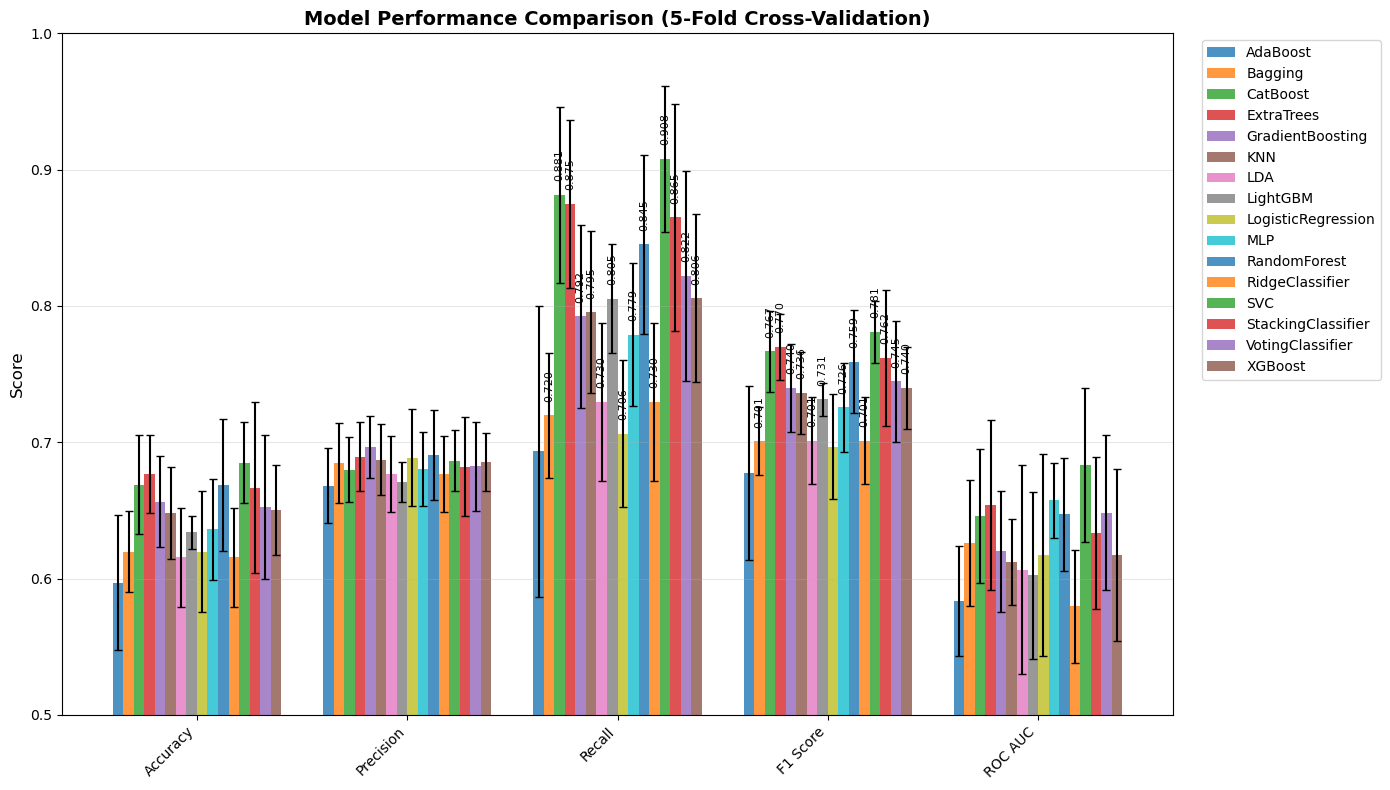


PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# Call the main function to run the analysis for 100 genes from pathways
if __name__ == "__main__":
    # Run the enhanced pipeline excluding TabPFN
    probs_df, results_df, summary_df = run_classification_pipeline_2(
        input_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/100MVG.csv",
        probs_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/ROC_Probs_100MVG.csv",
        results_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/100MVG_fold_wise_metrics.csv",
        summary_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/100MVG_summary_statistics.csv",
        plot_path="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/100MVG_model_comparison_plot.png"
    )

#### **200 Genes**

Loading and preparing data...
Dataset shape: (489, 200)
Target distribution: {1: 303, 0: 186}
Excluded models: ['TabPFN']
Running 16 models with 5-fold cross-validation...
Processing LogisticRegression...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Processing RidgeClassifier...
Processing LDA...
Processing SVC...
Processing KNN...
Processing MLP...
Processing RandomForest...
Processing GradientBoosting...
Processing AdaBoost...
Processing Bagging...
Processing ExtraTrees...
Processing XGBoost...
Processing LightGBM...
Processing CatBoost...
Processing VotingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Processing StackingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

✅ Saved predicted probabilities: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/ROC_Probs_200MVG.csv
✅ Saved fold-wise metrics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/200MVG_fold_wise_metrics.csv
✅ Saved summary statistics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/200MVG_summary_statistics.csv

CLASSIFICATION RESULTS SUMMARY
Dataset: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/200MVG.csv
Models evaluated: 16
Cross-validation: 5 folds
Total predictions: 7824

Combined Summary (mean ± std):
             Model      Accuracy     Precision        Recall      F1 Score       ROC AUC
          AdaBoost  0.571 ± 0.03 0.655 ± 0.023  0.65 ± 0.048 0.652 ± 0.028 0.561 ± 0.023
           Bagging 0.634 ± 0.049 0.689 ± 0.029 0.743 ± 0.077 0.714 ± 0.049 0.619 ± 0.053
          CatBoost 0.671 ± 0.036 0.678 ± 0.017 0.895 ± 0.078  0.77 ± 0.033 0.646 ± 0.049
        ExtraTrees 0.665 ± 0.031 0.682 ± 0.018 0.862 ± 0.064  0.76 

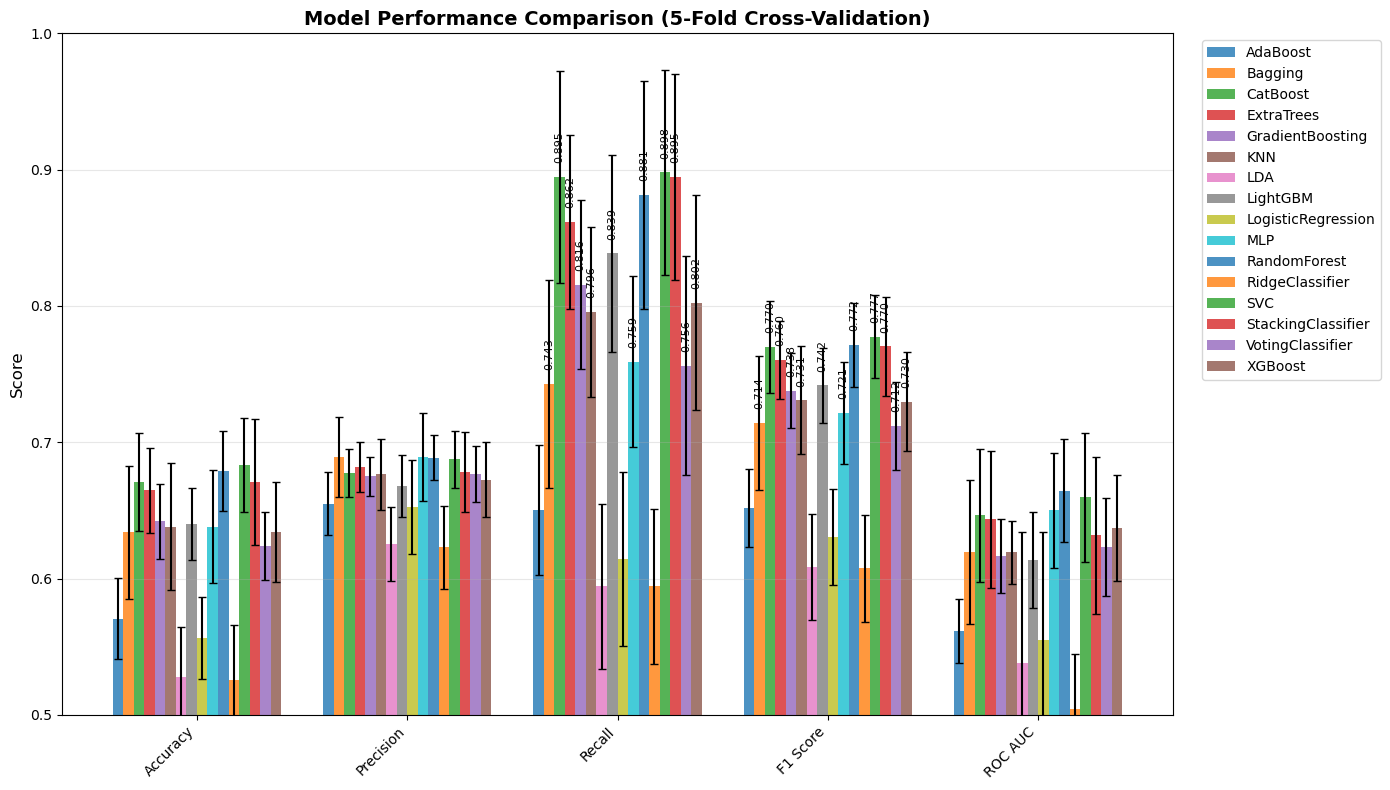


PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# Call the main function to run the analysis for 200 genes from pathways
if __name__ == "__main__":
    # Run the enhanced pipeline excluding TabPFN
    probs_df, results_df, summary_df = run_classification_pipeline_2(
        input_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/200MVG.csv",
        probs_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/ROC_Probs_200MVG.csv",
        results_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/200MVG_fold_wise_metrics.csv",
        summary_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/200MVG_summary_statistics.csv",
        plot_path="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/200MVG_model_comparison_plot.png"
    )

#### **300 Genes**

Loading and preparing data...
Dataset shape: (489, 300)
Target distribution: {1: 303, 0: 186}
Excluded models: ['TabPFN']
Running 16 models with 5-fold cross-validation...
Processing LogisticRegression...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing RidgeClassifier...
Processing LDA...
Processing SVC...
Processing KNN...
Processing MLP...
Processing RandomForest...
Processing GradientBoosting...
Processing AdaBoost...
Processing Bagging...
Processing ExtraTrees...
Processing XGBoost...
Processing LightGBM...
Processing CatBoost...
Processing VotingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing StackingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Saved predicted probabilities: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/ROC_Probs_300MVG.csv
✅ Saved fold-wise metrics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/300MVG_fold_wise_metrics.csv
✅ Saved summary statistics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/300MVG_summary_statistics.csv

CLASSIFICATION RESULTS SUMMARY
Dataset: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/300MVG.csv
Models evaluated: 16
Cross-validation: 5 folds
Total predictions: 7824

Combined Summary (mean ± std):
             Model      Accuracy     Precision        Recall      F1 Score       ROC AUC
          AdaBoost 0.562 ± 0.032 0.647 ± 0.029 0.647 ± 0.046 0.646 ± 0.031  0.528 ± 0.05
           Bagging 0.616 ± 0.037 0.683 ± 0.015 0.707 ± 0.085 0.693 ± 0.044   0.6 ± 0.047
          CatBoost 0.659 ± 0.052 0.671 ± 0.028 0.882 ± 0.089 0.761 ± 0.044 0.647 ± 0.061
        ExtraTrees 0.671 ± 0.049 0.687 ± 0.035 0.868 ± 0.084 0.765 

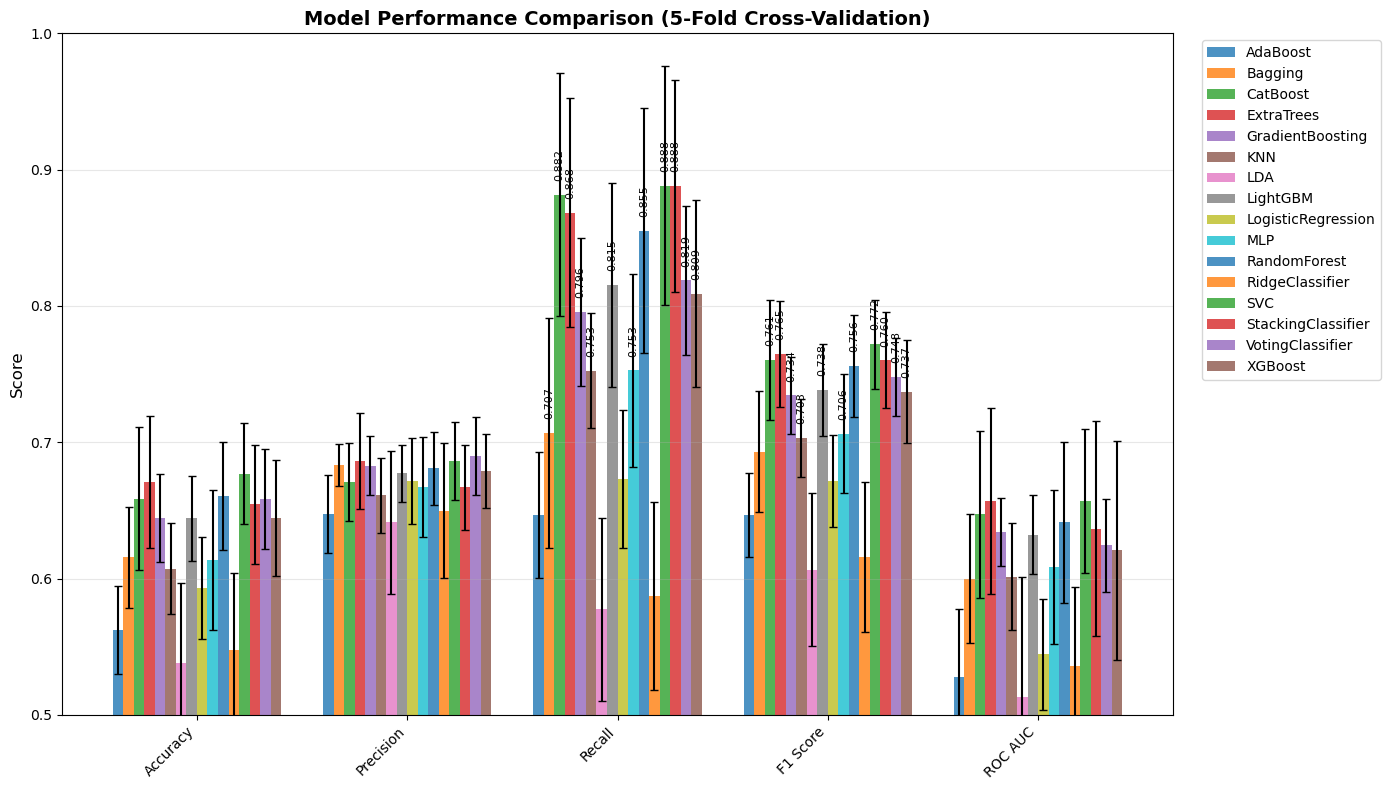


PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# Call the main function to run the analysis for 300 genes from pathways
if __name__ == "__main__":
    # Run the enhanced pipeline excluding TabPFN
    probs_df, results_df, summary_df = run_classification_pipeline_2(
        input_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/300MVG.csv",
        probs_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/ROC_Probs_300MVG.csv",
        results_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/300MVG_fold_wise_metrics.csv",
        summary_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/300MVG_summary_statistics.csv",
        plot_path="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/300MVG_model_comparison_plot.png"
    )

#### **411 Genes**

Loading and preparing data...
Dataset shape: (489, 411)
Target distribution: {1: 303, 0: 186}
Running 17 models with 5-fold cross-validation...
Processing TabPFN...
Processing LogisticRegression...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing RidgeClassifier...
Processing LDA...
Processing SVC...
Processing KNN...
Processing MLP...
Processing RandomForest...
Processing GradientBoosting...
Processing AdaBoost...
Processing Bagging...
Processing ExtraTrees...
Processing XGBoost...
Processing LightGBM...
Processing CatBoost...
Processing VotingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing StackingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Saved predicted probabilities: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/ROC_Probs_411MVG.csv
✅ Saved fold-wise metrics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/411MVG_fold_wise_metrics.csv
✅ Saved summary statistics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/411MVG_summary_statistics.csv

CLASSIFICATION RESULTS SUMMARY
Dataset: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/411MVG.csv
Models evaluated: 17
Cross-validation: 5 folds
Total predictions: 8313

Combined Summary (mean ± std):
             Model      Accuracy     Precision        Recall      F1 Score       ROC AUC
          AdaBoost 0.589 ± 0.046 0.667 ± 0.042 0.677 ± 0.029 0.671 ± 0.032  0.56 ± 0.081
           Bagging 0.613 ± 0.037  0.68 ± 0.025  0.71 ± 0.064 0.694 ± 0.037 0.602 ± 0.059
          CatBoost 0.667 ± 0.043 0.676 ± 0.022 0.888 ± 0.076 0.767 ± 0.037  0.649 ± 0.06
        ExtraTrees 0.673 ± 0.042 0.683 ± 0.028 0.881 ± 0.056 0.769 

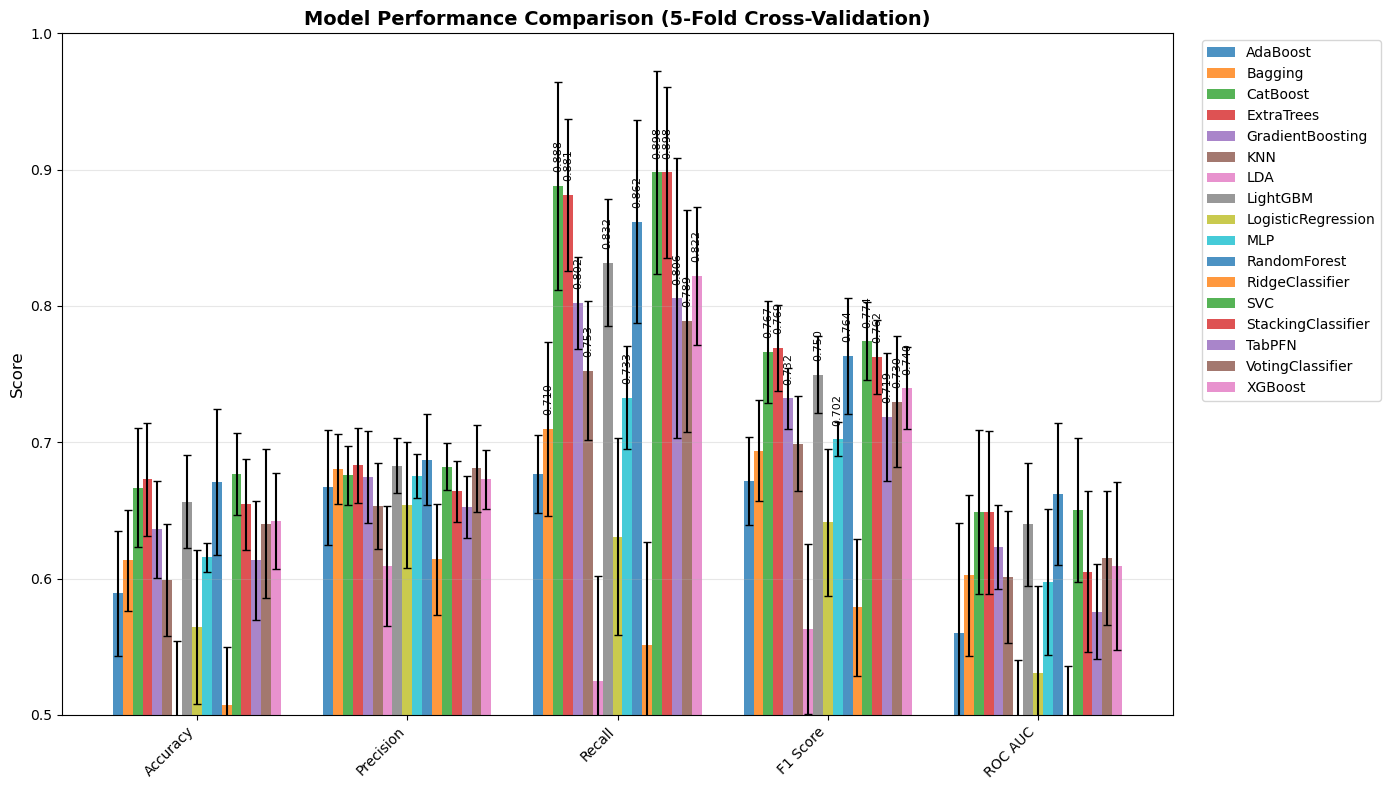


PIPELINE COMPLETED SUCCESSFULLY


In [96]:
# Call the main function to run the analysis for 411 genes from pathways
if __name__ == "__main__":
    # Run the enhanced pipeline excluding TabPFN
    probs_df, results_df, summary_df = run_classification_pipeline_2(
        input_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/411MVG.csv",
        probs_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/ROC_Probs_411MVG.csv",
        results_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/411MVG_fold_wise_metrics.csv",
        summary_output_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/411MVG_summary_statistics.csv",
        plot_path="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/MVG/411MVG_model_comparison_plot.png"
    )

### **DCE Genes**

#### **100 Genes**

Loading and preparing data...
Dataset shape: (489, 99)
Target distribution: {1: 303, 0: 186}
Running 17 models with 5-fold cross-validation...
Processing TabPFN...
Processing LogisticRegression...
Processing RidgeClassifier...
Processing LDA...
Processing SVC...
Processing KNN...
Processing MLP...
Processing RandomForest...
Processing GradientBoosting...
Processing AdaBoost...
Processing Bagging...
Processing ExtraTrees...
Processing XGBoost...
Processing LightGBM...
Processing CatBoost...
Processing VotingClassifier...
Processing StackingClassifier...
✅ Saved predicted probabilities: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/TabPFN_ROC_Probs_100DCEG_Paths.csv
✅ Saved fold-wise metrics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/100DCEG_fold_wise_metrics.csv
✅ Saved summary statistics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/100DCEG_summary_statistics.csv

CLASSIFICATION RESULTS SUMMARY
Dataset: /mnt/c/Users

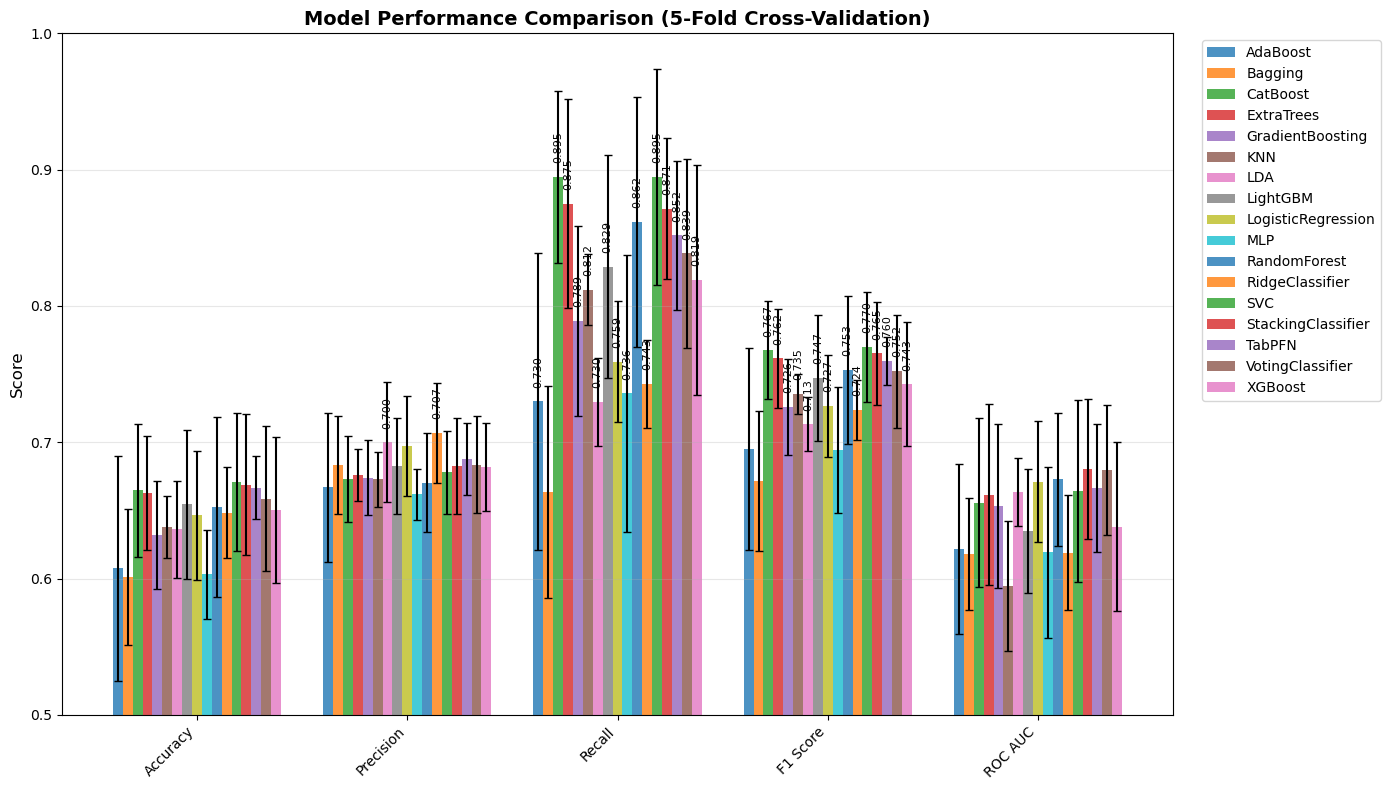


PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# Call the main function to run the analysis for 100 genes from pathways
if __name__ == "__main__":
    # Run the enhanced pipeline
    probs_df, results_df, summary_df = run_classification_pipeline_2(
        input_csv="/path/to/data/100DCEG_Paths_average.csv",
        probs_output_csv="/path/to/results/TabPFN_ROC_Probs_100DCEG_Paths.csv",
        results_output_csv="/path/to/results/100DCEG_fold_wise_metrics.csv",
        summary_output_csv="/path/to/results/100DCEG_summary_statistics.csv",
        plot_path="/path/to/results/100DCEG_model_comparison_plot.png"
    )

#### **200 Genes**

Loading and preparing data...
Dataset shape: (489, 200)
Target distribution: {1: 303, 0: 186}
Running 17 models with 5-fold cross-validation...
Processing TabPFN...
Processing LogisticRegression...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Processing RidgeClassifier...
Processing LDA...
Processing SVC...
Processing KNN...
Processing MLP...
Processing RandomForest...
Processing GradientBoosting...
Processing AdaBoost...
Processing Bagging...
Processing ExtraTrees...
Processing XGBoost...
Processing LightGBM...
Processing CatBoost...
Processing VotingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Processing StackingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

✅ Saved predicted probabilities: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/TabPFN_ROC_Probs_200DCEG_Paths.csv
✅ Saved fold-wise metrics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/200DCEG_fold_wise_metrics.csv
✅ Saved summary statistics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/200DCEG_summary_statistics.csv

CLASSIFICATION RESULTS SUMMARY
Dataset: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/200DCEG_Paths_average.csv
Models evaluated: 17
Cross-validation: 5 folds
Total predictions: 8313

Combined Summary (mean ± std):
             Model      Accuracy     Precision        Recall      F1 Score       ROC AUC
          AdaBoost 0.583 ± 0.043 0.652 ± 0.029 0.703 ± 0.071 0.675 ± 0.041 0.564 ± 0.023
           Bagging 0.579 ± 0.041 0.665 ± 0.046 0.654 ± 0.036 0.658 ± 0.026 0.594 ± 0.046
          CatBoost 0.653 ± 0.062 0.667 ± 0.036 0.878 ± 0.082 0.757 ± 0.048 0.631 ± 0.063
        ExtraTrees 0.648 ± 0.061 

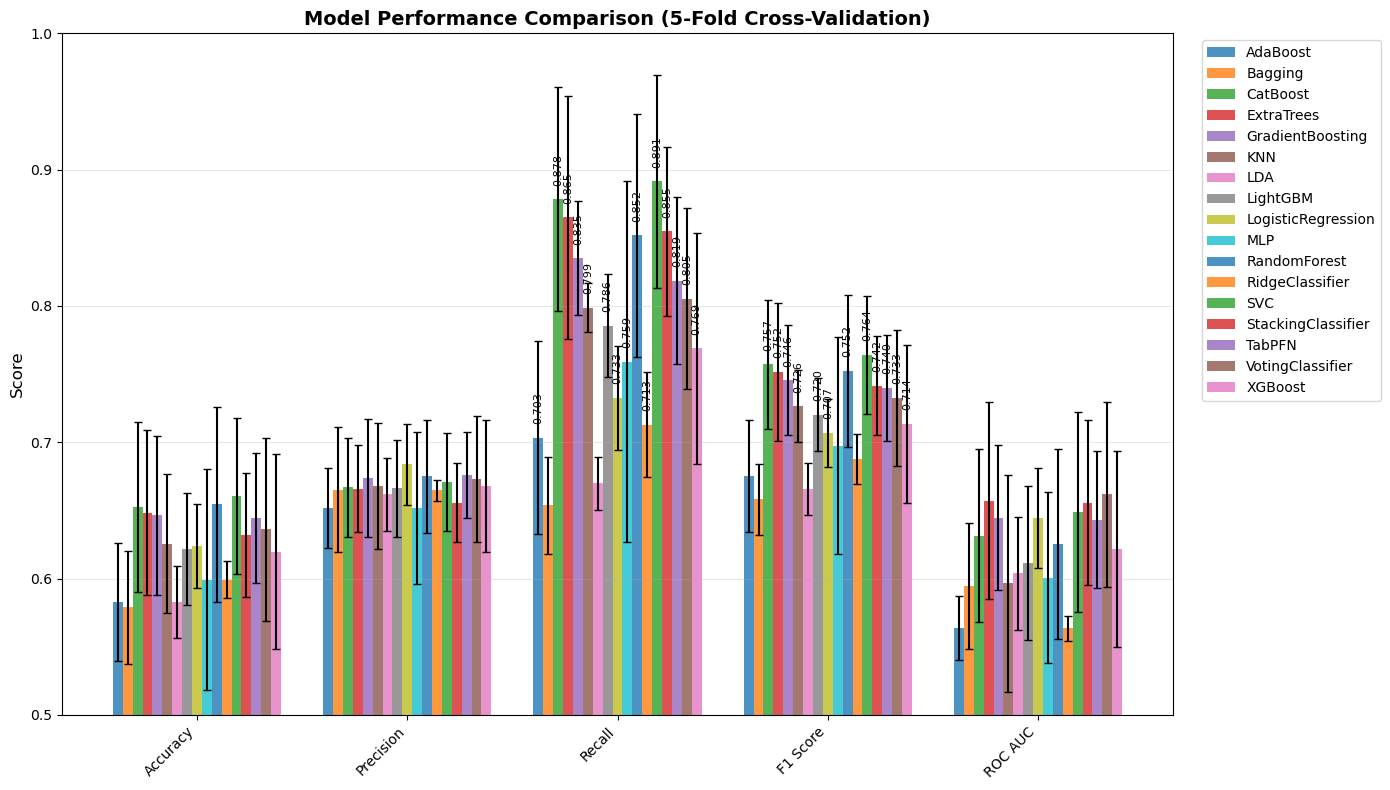


PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# Call the main function to run the analysis for 100 genes from pathways
if __name__ == "__main__":
    # Run the enhanced pipeline
    probs_df, results_df, summary_df = run_classification_pipeline_2(
        input_csv="/path/to/input/200DCEG_Paths_average.csv",
        probs_output_csv="/path/to/results/TabPFN_ROC_Probs_200DCEG_Paths.csv",
        results_output_csv="/path/to/results/200DCEG_fold_wise_metrics.csv",
        summary_output_csv="/path/to/results/200DCEG_summary_statistics.csv",
        plot_path="/path/to/results/200DCEG_model_comparison_plot.png"
    )

#### **300 Genes**

Loading and preparing data...
Dataset shape: (489, 296)
Target distribution: {1: 303, 0: 186}
Running 17 models with 5-fold cross-validation...
Processing TabPFN...
Processing LogisticRegression...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Processing RidgeClassifier...
Processing LDA...
Processing SVC...
Processing KNN...
Processing MLP...
Processing RandomForest...
Processing GradientBoosting...
Processing AdaBoost...
Processing Bagging...
Processing ExtraTrees...
Processing XGBoost...
Processing LightGBM...
Processing CatBoost...
Processing VotingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Processing StackingClassifier...


/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sindypin/miniconda3/envs/tabPFN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

✅ Saved predicted probabilities: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/TabPFN_ROC_Probs_300DCEG_Paths.csv
✅ Saved fold-wise metrics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/300DCEG_fold_wise_metrics.csv
✅ Saved summary statistics: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/DCEG/300DCEG_summary_statistics.csv

CLASSIFICATION RESULTS SUMMARY
Dataset: /mnt/c/Users/pinsy007/Downloads/WORKING/Output/Final/300DCEG_Paths_average.csv
Models evaluated: 17
Cross-validation: 5 folds
Total predictions: 8313

Combined Summary (mean ± std):
             Model      Accuracy     Precision        Recall      F1 Score       ROC AUC
          AdaBoost 0.593 ± 0.054 0.666 ± 0.053 0.693 ± 0.039 0.679 ± 0.039  0.609 ± 0.07
           Bagging 0.601 ± 0.043  0.68 ± 0.028 0.674 ± 0.075 0.675 ± 0.046 0.585 ± 0.047
          CatBoost 0.665 ± 0.056 0.675 ± 0.034 0.888 ± 0.068 0.766 ± 0.041 0.625 ± 0.061
        ExtraTrees 0.644 ± 0.054 

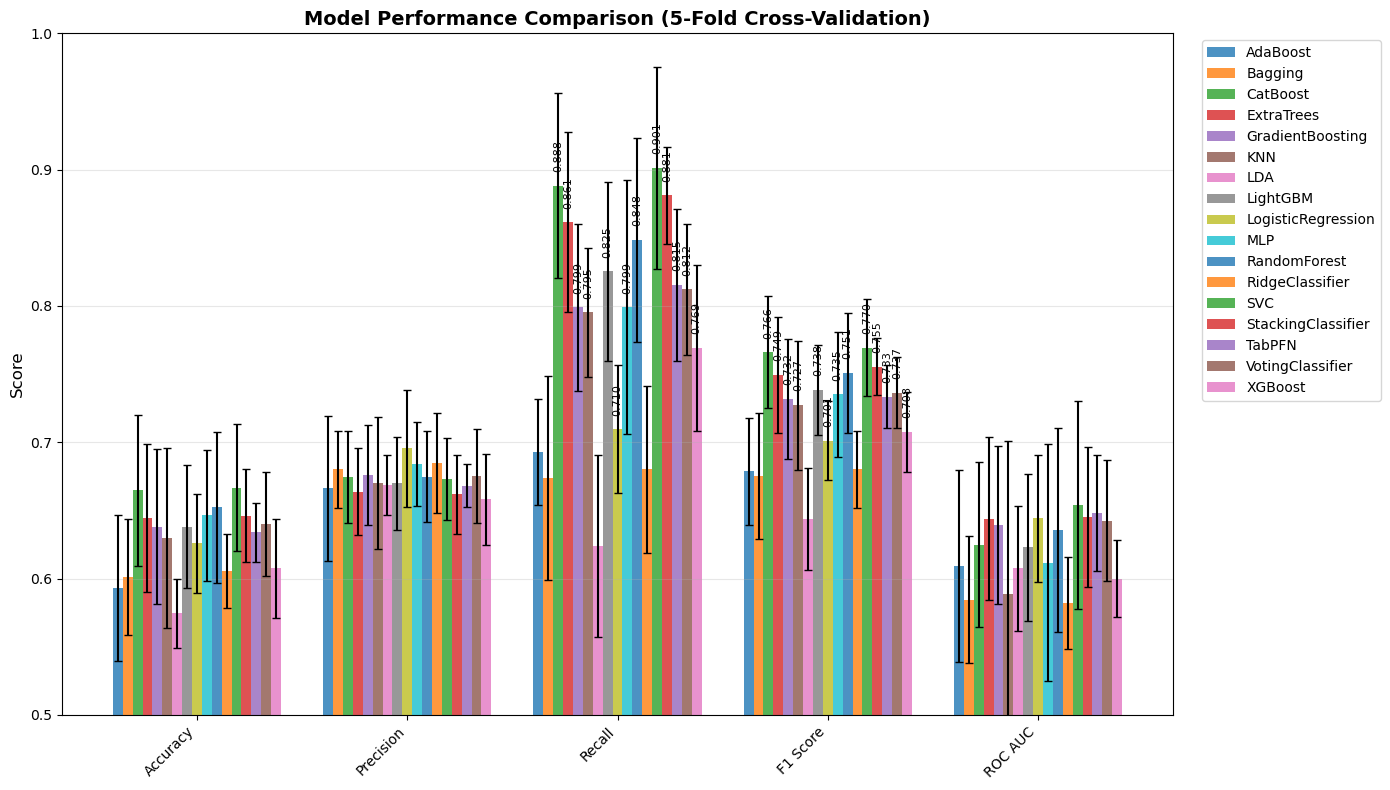


PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# Call the main function to run the analysis for 300 genes from pathways
if __name__ == "__main__":
    # Run the enhanced pipeline
    probs_df, results_df, summary_df = run_classification_pipeline_2(
        input_csv="/path/to/input/300DCEG_Paths_average.csv",
        probs_output_csv="/path/to/results/TabPFN_ROC_Probs_300DCEG_Paths.csv",
        results_output_csv="/path/to/results/300DCEG_fold_wise_metrics.csv",
        summary_output_csv="/path/to/results/300DCEG_summary_statistics.csv",
        plot_path="/path/to/results/300DCEG_model_comparison_plot.png"
    )

#### **411 Genes**


Combined Summary (mean ± std):
             Model      Accuracy     Precision        Recall      F1 Score       ROC AUC
          AdaBoost 0.601 ± 0.033 0.674 ± 0.042   0.7 ± 0.043 0.685 ± 0.016 0.563 ± 0.087
           Bagging 0.585 ± 0.061 0.663 ± 0.044  0.67 ± 0.088 0.665 ± 0.059 0.606 ± 0.083
          CatBoost  0.659 ± 0.06 0.673 ± 0.034 0.875 ± 0.083  0.76 ± 0.047 0.628 ± 0.074
        ExtraTrees 0.665 ± 0.035 0.678 ± 0.024 0.875 ± 0.053 0.763 ± 0.027 0.652 ± 0.069
  GradientBoosting 0.638 ± 0.048 0.671 ± 0.035 0.819 ± 0.055 0.737 ± 0.035   0.62 ± 0.06
               KNN  0.63 ± 0.038 0.667 ± 0.029 0.805 ± 0.031  0.73 ± 0.027 0.596 ± 0.071
               LDA 0.571 ± 0.042  0.678 ± 0.03 0.581 ± 0.074 0.624 ± 0.054 0.583 ± 0.035
          LightGBM  0.65 ± 0.021 0.681 ± 0.022 0.822 ± 0.056  0.744 ± 0.02 0.632 ± 0.053
LogisticRegression 0.616 ± 0.043  0.69 ± 0.055  0.703 ± 0.04  0.694 ± 0.02 0.652 ± 0.045
               MLP 0.591 ± 0.045  0.677 ± 0.04 0.657 ± 0.099 0.663 ± 0.051 0.6

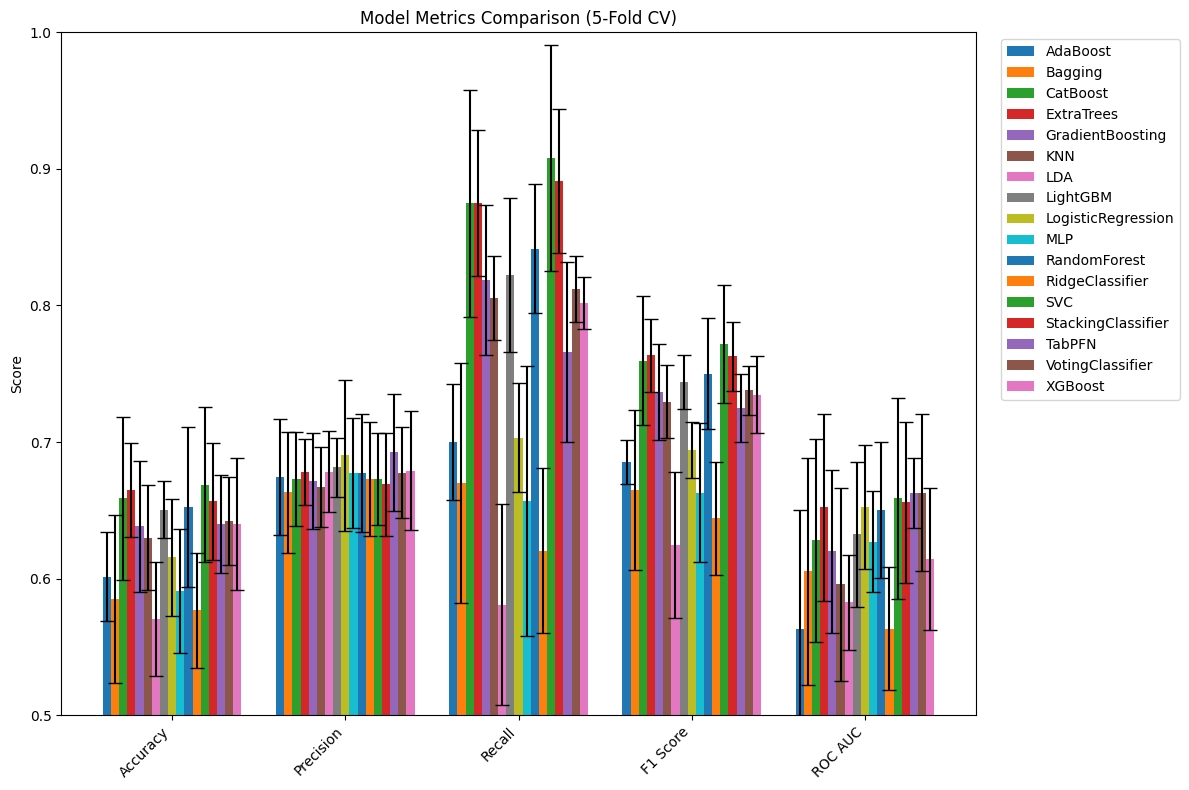

In [ ]:
results_df, summary_df = run_classification_pipeline_1(
    input_csv="/path/to/data/F_411_DCEG_Paths_average.csv",
    output_csv="/path/to/results/TabPFN_First_Exp_411DCEG_Paths_Average_Results.csv",
    summary_csv="/path/to/results/TabPFN_First_Exp_411DCEG_Paths_Average_Summary.csv",
    target_col="Long_COVID",
    id_col="Subject_ID",
    device="cpu",            # or "cuda" for GPU
    n_splits=5,
    random_state=42,
    save_plot=True,
    plot_path="/path/to/results/TabPFN_First_Exp_411DCEG_Paths_Average_Results.png"
)

## **PLOTS**

### **BarCharts**

#### **Non-Grouped**

In [ ]:
# Define a function to plot and save prediction bars from model results tables
def plot_metric_bars_non_grouped(
    input_dir: str,
    output_dir: str,
    metric: str = "Accuracy",
    file_pattern: str = "*.csv",
    sep: str = ",",
    y_cutoff: float = 0.5,
    colormap: str = "viridis"
):
    """
    Read all model‐results tables from `input_dir`, and for each file:
      1. Plot a bar chart of the specified metric (mean ± std), ordered highest→lowest.
      2. Set the y‐axis lower bound to `y_cutoff` to emphasize differences above that threshold.
      3. Color bars using the chosen `colormap`.
      4. Save each figure into `output_dir` with the same base filename (but .png).

    Parameters
    ----------
    input_dir : str
        Path to the folder containing your tables (e.g., 'path/to/input').
    output_dir : str
        Path to the folder where you want to save the .png plots (e.g., 'path/to/output').
    metric : str, optional
        The metric to plot (e.g., "Accuracy", "ROC AUC", "Precision").
        The code will look for columns named "<metric>_mean" and "<metric>_std". Defaults to "Accuracy".
    file_pattern : str, optional
        Glob pattern to match your table files. Defaults to "*.csv".
    sep : str, optional
        Delimiter used in your CSV files. Defaults to ",". If your files are
        tab‐delimited, set sep="\t".
    y_cutoff : float, optional
        Lower bound for y‐axis. Defaults to 0.5.
    colormap : str, optional
        Name of a Matplotlib colormap to color the bars. Defaults to "viridis".
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"

    for table_file in input_path.glob(file_pattern):
        table_name = table_file.stem

        # Read the table
        df = pd.read_csv(table_file, sep=sep)

        # Check required columns
        if not {"Model", mean_col, std_col}.issubset(df.columns):
            print(f"Skipping {table_file.name}: missing '{mean_col}' or '{std_col}'.")
            continue

        # Sort descending by the chosen metric mean
        df_sorted = df.sort_values(by=mean_col, ascending=False).reset_index(drop=True)
        models = df_sorted["Model"]
        means = df_sorted[mean_col]
        stds = df_sorted[std_col]

        # Generate a colormap array with as many colors as there are models
        cmap = plt.get_cmap(colormap)
        colors = cmap(np.linspace(0, 1, len(models)))

        # Create bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(models, means, yerr=stds, capsize=5, color=colors, edgecolor="black", linewidth=0.5)

        # Draw a horizontal line at the cutoff
        ax.axhline(y=y_cutoff, color="red", linestyle="--", linewidth=1)

        # Axes labels and title
        ax.set_xlabel("Model", fontsize=12)
        ax.set_ylabel(f"{metric} (mean ± std)", fontsize=12)
        ax.set_title(f"{metric} Comparison ― {table_name}", fontsize=14)
        ax.set_xticks(models)
        ax.set_xticklabels(models, rotation=45, ha="right", fontsize=10)

        # Set y‐axis limits to start at the cutoff
        top_margin = (means.max() + stds.max()) * 1.05
        ax.set_ylim(y_cutoff, top_margin)

        # Add value labels on top of each bar
        for rect, mean in zip(bars, means):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                height + 0.005,
                f"{mean:.2f}",
                ha="center",
                va="bottom",
                fontsize=9
            )

        plt.tight_layout()

        # Save to PNG
        output_file = output_path / f"{table_name}_{metric}.png"
        fig.savefig(output_file, dpi=300)
        
        # Display in Jupyter
        plt.show()

        # Close figure to free memory
        plt.close(fig)

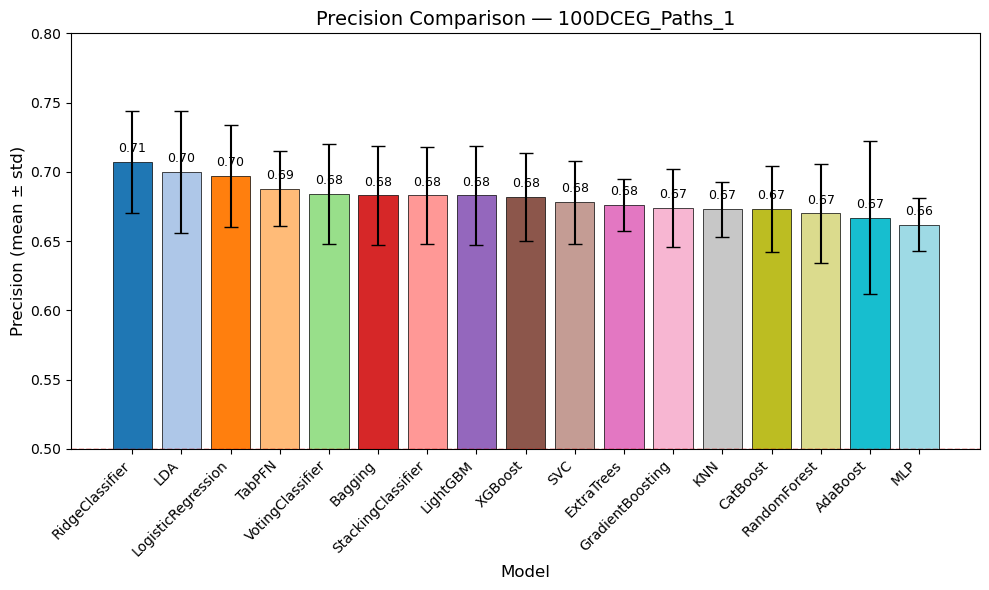

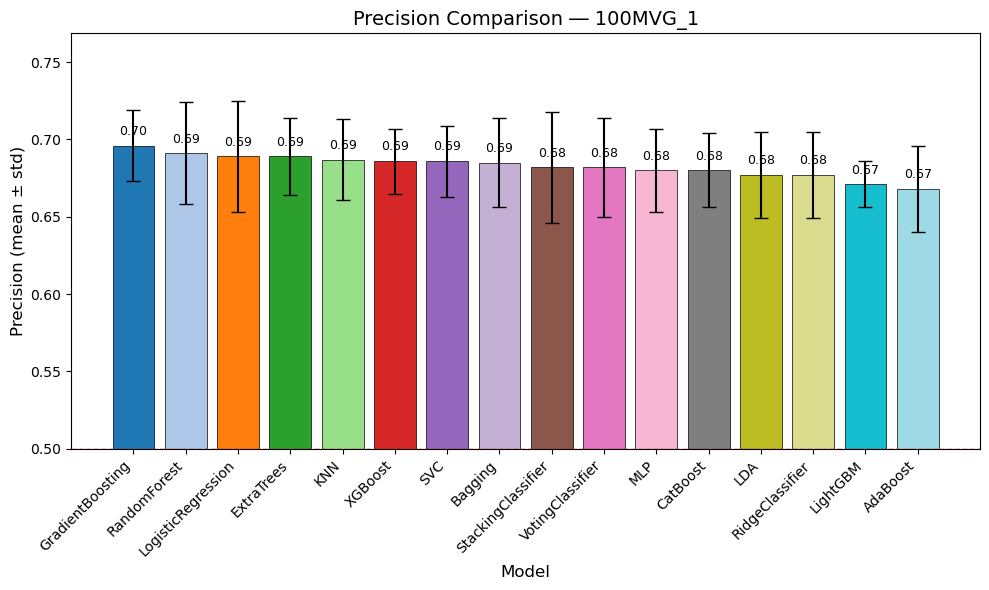

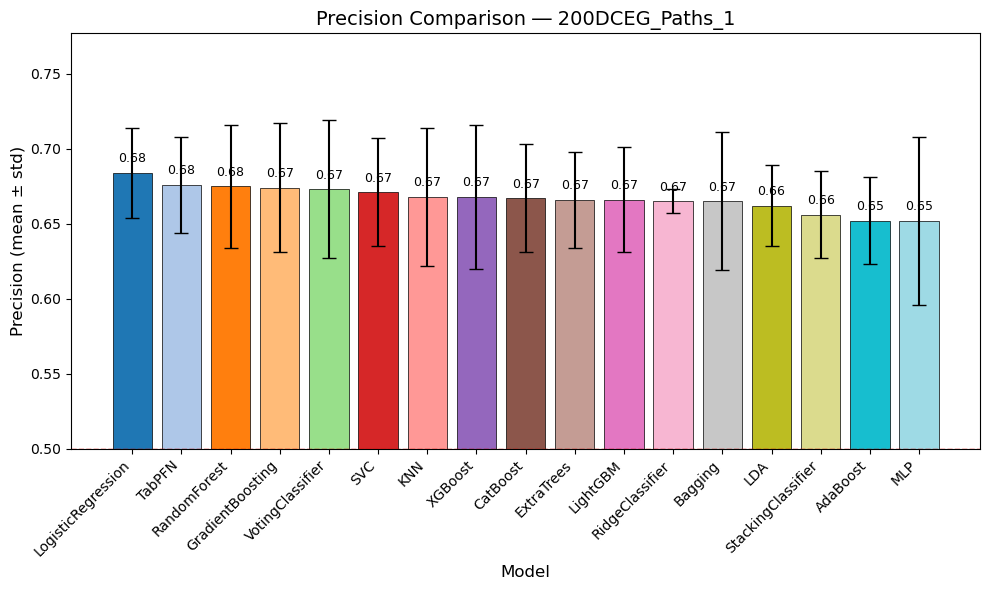

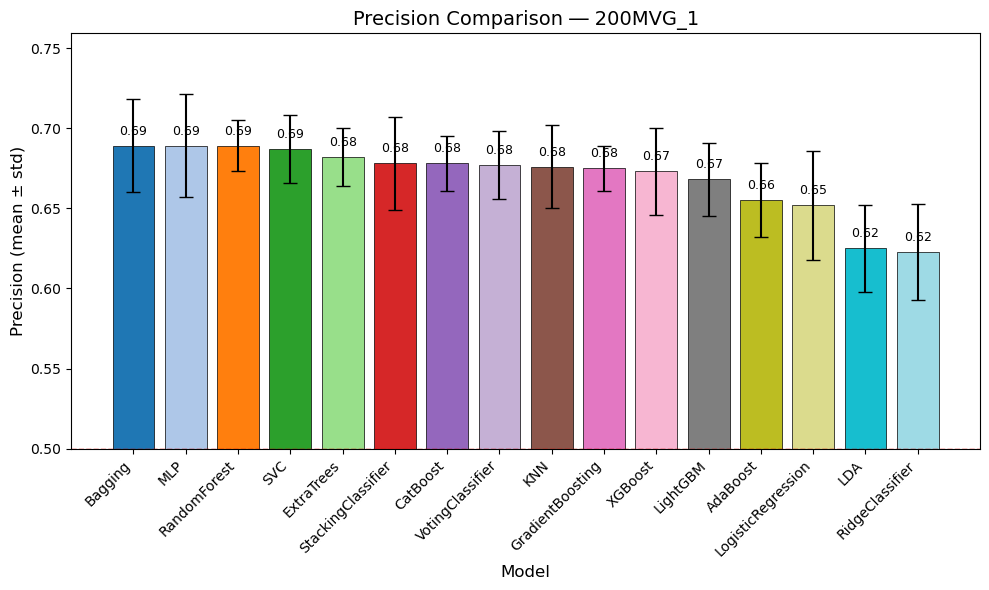

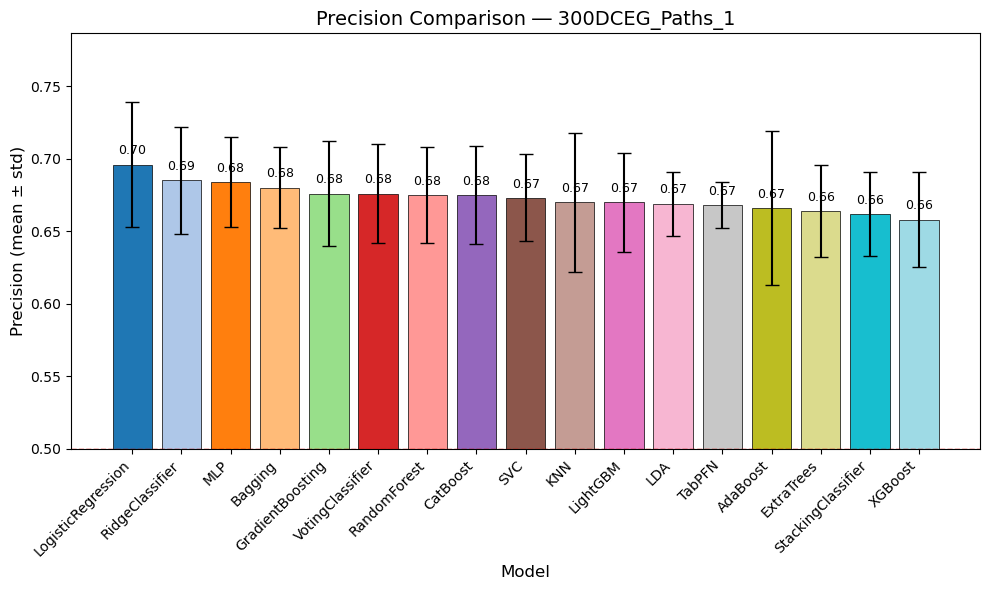

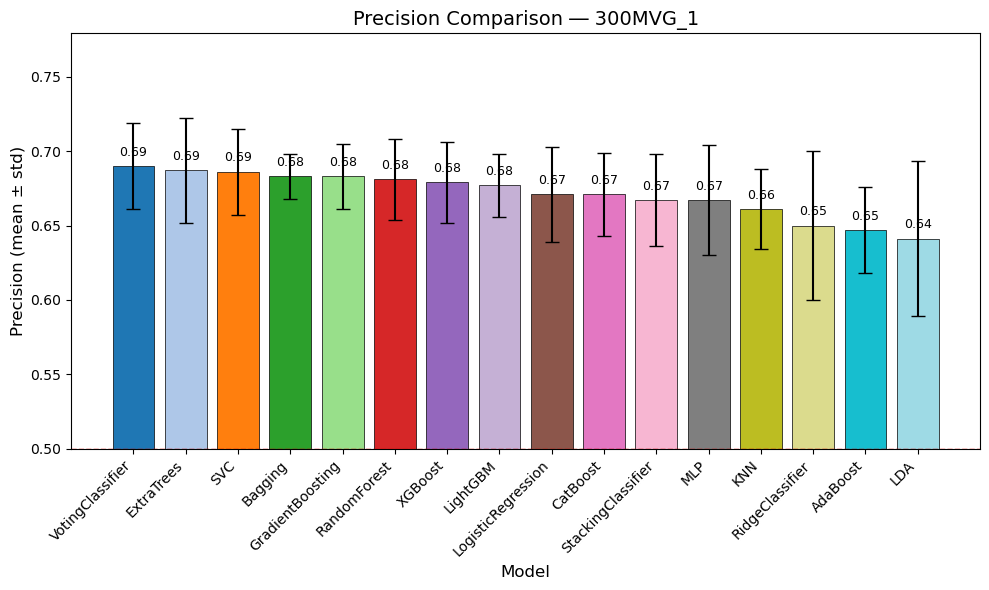

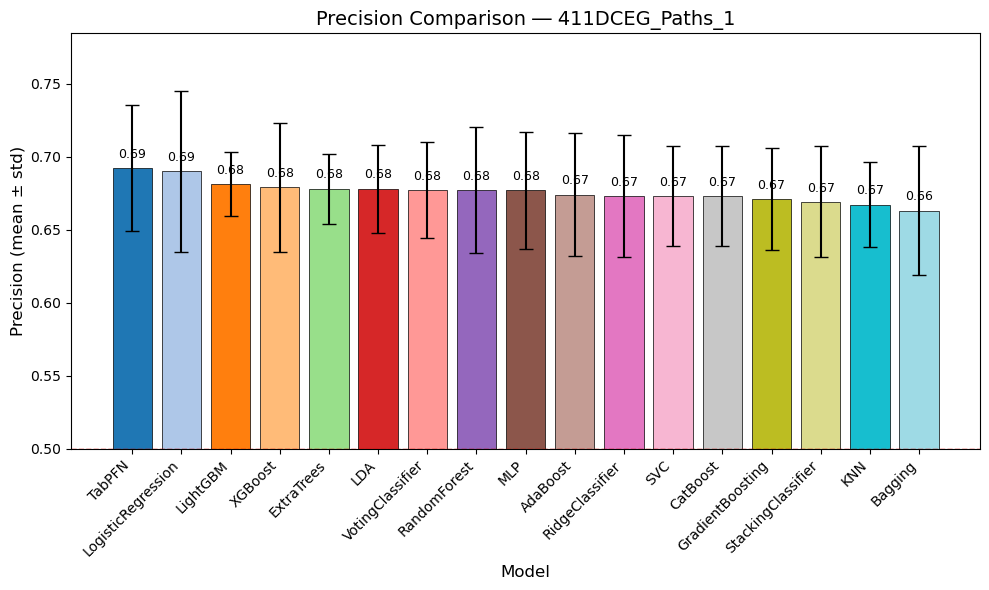

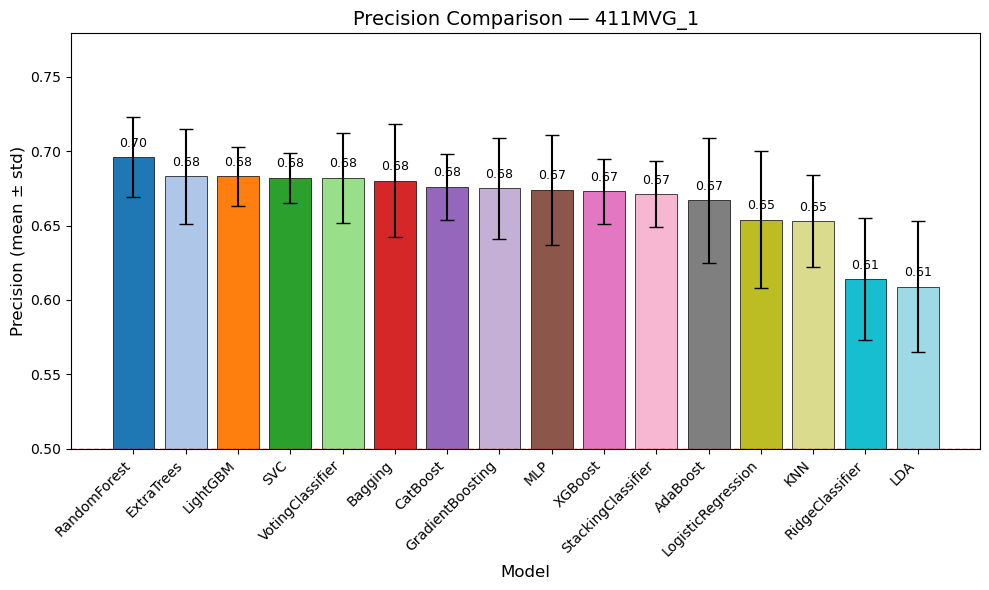

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Call the function to plot and save prediction bars
# ─────────────────────────────────────────────────────────────────────────────
input_folder  = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results"
output_folder = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results/Plots/Non_grouped"
plot_metric_bars_non_grouped(
    input_dir=input_folder,
    output_dir=output_folder,
    metric="Precision",
    file_pattern="*.csv",
    sep=",",
    y_cutoff=0.5,
    colormap="tab20"
)

#### **Grouped**

In [ ]:
# Define a function to plot and save prediction bars from model results tables
def plot_metric_bars_grouped(
    input_dir: str,
    output_dir: str,
    metric: str = "Accuracy",
    file_pattern: str = "*.csv",
    sep: str = ",",
    y_cutoff: float = 0.5,
    colormap: str = "tab20",
    plot_means: bool = True,
    plot_errors: bool = True,
    annotate_means: bool = True
):
    """
    Read all model‐results tables from `input_dir` whose filenames begin with a gene‐count
    (e.g., "100MVG_1.csv", "200MVG_1.csv", "300MVG_1.csv", "411MVG_1.csv"). Group the chosen
    `metric` (mean ± std) by model across those gene‐sets, and produce one grouped bar chart
    in Jupyter for all models, where each model has up to four bars (one per gene‐set). Save the
    figure into `output_dir` as "grouped_<metric>.png".

    Parameters
    ----------
    input_dir : str
        Path to the folder containing your gene‐set tables.
    output_dir : str
        Path to the folder where you want to save the grouped plot.
    metric : str, optional
        The metric to plot (e.g., "Accuracy", "Precision", "ROC AUC").
        Expects columns "<metric>_mean" and "<metric>_std" in each CSV. Defaults to "Accuracy".
    file_pattern : str, optional
        Glob pattern to match your table files. Defaults to "*.csv".
    sep : str, optional
        Delimiter used in your CSV files. Defaults to ",". If your files are tab‐delimited,
        set sep="\t".
    y_cutoff : float, optional
        Lower bound for y‐axis. Defaults to 0.5.
    colormap : str, optional
        Matplotlib colormap name for coloring the bars. Defaults to "tab20".
    plot_means : bool, optional
        If True, plot the mean values as the bar heights. If False, omit the bars entirely.
    plot_errors : bool, optional
        If True, draw error bars (std) on top of the bars. If False, omit the error bars.
    annotate_means : bool, optional
        If True and plot_means is also True, annotate each bar with its mean value.
        If False, no text annotation is drawn.
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"

    # Nested dict: data[model][gene_set] = (mean, std)
    data = {}
    gene_sets = set()

    # 1. Read all files and assemble data
    for table_file in input_path.glob(file_pattern):
        stem = table_file.stem
        m = re.match(r"^(\d+)", stem)
        if not m:
            continue  # skip files without leading digits
        gene_set = m.group(1)
        gene_sets.add(gene_set)

        df = pd.read_csv(table_file, sep=sep)
        if not {"Model", mean_col, std_col}.issubset(df.columns):
            print(f"Skipping {table_file.name}: missing '{mean_col}' or '{std_col}'.")
            continue

        for _, row in df.iterrows():
            model = row["Model"]
            mean_val = row[mean_col]
            std_val = row[std_col]
            data.setdefault(model, {})[gene_set] = (mean_val, std_val)

    if not data:
        print("No valid data found. Check your input directory and file patterns.")
        return

    # 2. Sort gene_sets numerically (e.g., ["100", "200", "300", "411"])
    gene_sets = sorted(gene_sets, key=lambda x: int(x))

    # 3. Build a list of all models, with TabPFN first if present
    all_models = list(data.keys())
    if "TabPFN" in all_models:
        all_models.remove("TabPFN")
        models = ["TabPFN"] + sorted(all_models)
    else:
        models = sorted(all_models)

    n_models = len(models)
    n_sets = len(gene_sets)

    # 4. Create matrices of means and stds (shape: n_models x n_sets)
    means_matrix = np.zeros((n_models, n_sets))
    stds_matrix = np.zeros((n_models, n_sets))
    for i, model in enumerate(models):
        for j, gs in enumerate(gene_sets):
            if gs in data[model]:
                means_matrix[i, j], stds_matrix[i, j] = data[model][gs]
            else:
                means_matrix[i, j], stds_matrix[i, j] = 0.0, 0.0

    # 5. Set up x-axis positions and bar widths
    x = np.arange(n_models)
    total_width = 0.8
    bar_width = total_width / n_sets
    offsets = np.arange(-(total_width/2) + bar_width/2, (total_width/2), bar_width)

    cmap = plt.get_cmap(colormap)
    colors = cmap(np.linspace(0, 1, n_sets))

    fig, ax = plt.subplots(figsize=(12, 6))

    # 6. Plot each gene‐set as a group of bars
    for j, gs in enumerate(gene_sets):
        heights = means_matrix[:, j] if plot_means else np.zeros(n_models)
        errors = stds_matrix[:, j] if plot_errors else None

        ax.bar(
            x + offsets[j],
            heights,
            width=bar_width,
            yerr=errors,
            capsize=4,
            color=colors[j],
            edgecolor="black",
            linewidth=0.5,
            label=f"{gs} genes"
        )

    # 7. Draw a horizontal cutoff line
    ax.axhline(y=y_cutoff, color="red", linestyle="--", linewidth=1)

    # 8. Labels and ticks (no title)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel(f"{metric}", fontsize=12) # Add (mean ± std) if necessary
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right", fontsize=10)

    # 9. Y-axis limits start at y_cutoff and extend to max(mean+std)
    max_display = (means_matrix + stds_matrix).max() if plot_means and plot_errors else means_matrix.max()
    top_value = max_display * 1.05
    ax.set_ylim(y_cutoff, top_value)

    # 10. Annotate bars with means if requested
    if plot_means and annotate_means:
        for i in range(n_models):
            for j in range(n_sets):
                height = means_matrix[i, j]
                ax.text(
                    x[i] + offsets[j],
                    height + 0.005,
                    f"{height:.2f}",
                    ha="center",
                    va="bottom",
                    fontsize=8
                )

    # 11. Place the legend outside the plot on the right
    ax.legend(
        title="Gene‐Set",
        fontsize=9,
        title_fontsize=10,
        loc="upper left",
        bbox_to_anchor=(1.02, 1)
    )

    plt.tight_layout()

    # 12. Save and display
    output_file = output_path / f"grouped_{metric}.png"
    fig.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

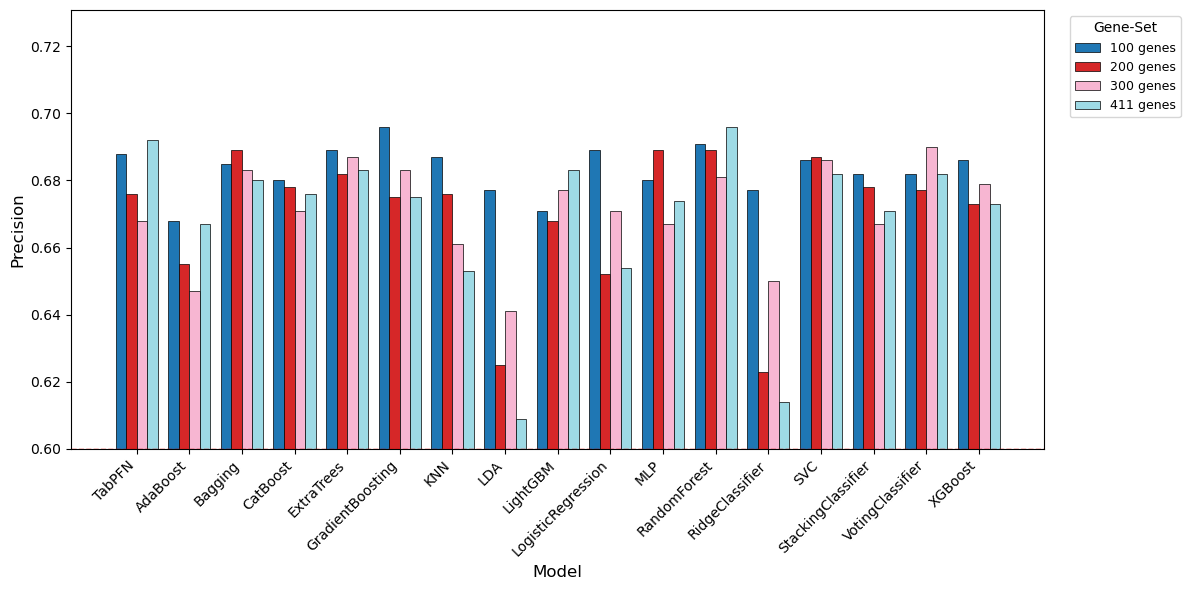

In [64]:
# ─────────────────────────────────────────────────────────────────────────────
# Call the function to plot and save prediction bars
# ─────────────────────────────────────────────────────────────────────────────
input_folder  = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results"
output_folder = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results/Plots/Grouped"
plot_metric_bars_grouped(
    input_dir=input_folder,
    output_dir=output_folder,
    metric="Precision",
    file_pattern="*.csv",
    sep=",",
    y_cutoff=0.6,
    colormap="tab20",
    plot_means=True,     # <— draw the mean bars
    plot_errors=False,    # <— draw the std error bars
    annotate_means=False # <— omit the numerical labels on the bars
)


#### **Grouped Enhaced**

In [ ]:
# Define a function to create a 2x2 facet plot of metric bars for gene sets
def facet2x2_plot_metric_bars(
    input_dir: str,
    output_dir: str,
    metric: str = "Accuracy",
    file_pattern: str = "*.csv",
    sep: str = ",",
    y_cutoff: float = 0.5,
    palette: str = "tab10"
):
    """
    Read model‐results tables from `input_dir` whose filenames begin with a gene‐count
    (e.g., "100MVG_1.csv", "200MVG_1.csv", "300MVG_1.csv", "411MVG_1.csv"). Create a 2×2 grid
    of subplots (facets), one for each gene‐set, showing a bar chart of the chosen `metric`
    (mean ± std) across all models. No numeric annotations on the bars.

    The model ordering on the x‐axis is:
      1. 'TabPFN' (renamed to 'TACO' in labels) always first.
      2. All other models sorted by their average metric (mean across the four gene‐sets)
         in descending order (ignoring standard deviations).

    Parameters
    ----------
    input_dir : str
        Folder containing your gene‐set CSVs.
    output_dir : str
        Folder where the final faceted figure (PNG) will be saved.
    metric : str, optional
        Which metric to plot (e.g., "Accuracy", "Precision", "ROC AUC").
        Expects columns "<metric>_mean" and "<metric>_std" in each CSV. Defaults to "Accuracy".
    file_pattern : str, optional
        Glob pattern for matching table files. Defaults to "*.csv".
    sep : str, optional
        Delimiter used in your files. Defaults to ",". If TSV, use sep="\t".
    y_cutoff : float, optional
        Horizontal cutoff line drawn at this value (e.g., 0.50). Defaults to 0.5.
    palette : str, optional
        Name of a Matplotlib colormap or palette for the bar colors. Defaults to "tab10".
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"

    # 1. Gather data from each CSV, keyed by gene_set → model → (mean, std)
    data = {}       # data[model][gene_set] = (mean, std)
    gene_sets = set()
    for table_file in input_path.glob(file_pattern):
        stem = table_file.stem
        m = re.match(r"^(\d+)", stem)
        if not m:
            continue
        gs = m.group(1)
        gene_sets.add(gs)

        df = pd.read_csv(table_file, sep=sep)
        if not {"Model", mean_col, std_col}.issubset(df.columns):
            print(f"Skipping {table_file.name}: missing '{mean_col}' or '{std_col}'.")
            continue

        for _, row in df.iterrows():
            mdl = row["Model"]
            mean_val = row[mean_col]
            std_val = row[std_col]
            data.setdefault(mdl, {})[gs] = (mean_val, std_val)

    if not data:
        print("No valid data found in input directory. Check file names and columns.")
        return

    # 2. Sort gene_sets numerically, then ensure exactly four sets (e.g., ["100","200","300","411"])
    gene_sets = sorted(gene_sets, key=lambda x: int(x))
    if len(gene_sets) != 4:
        print(f"Expected exactly 4 gene-sets, found {len(gene_sets)}: {gene_sets}")
        return

    # 3. For each gene set, determine model ordering separately
    #    - 'TabPFN' first (rename to 'TACO' later)
    #    - then all other models sorted by performance for that specific gene set
    all_models = list(data.keys())
    
    # Create separate orderings for each gene set
    models_order_per_gs = {}
    for gs in gene_sets:
        # Get performance scores for this gene set only
        gs_scores = {}
        for mdl in all_models:
            if gs in data[mdl]:
                gs_scores[mdl] = data[mdl][gs][0]  # mean value for this gene set
            else:
                gs_scores[mdl] = 0.0
        
        # Build ordering for this gene set: TabPFN first, then others by performance
        if "TabPFN" in all_models:
            other_models = [m for m in all_models if m != "TabPFN"]
            other_models_sorted = sorted(other_models, key=lambda m: gs_scores[m], reverse=True)
            models_order_per_gs[gs] = ["TabPFN"] + other_models_sorted
        else:
            models_order_per_gs[gs] = sorted(all_models, key=lambda m: gs_scores[m], reverse=True)
        
        # Debug: Print ordering for this gene set
        print(f"\n{gs} genes - Model ordering and {metric} scores:")
        for i, mdl in enumerate(models_order_per_gs[gs]):
            score = gs_scores[mdl]
            display_name = "TACO" if mdl == "TabPFN" else mdl
            print(f"{i+1}. {display_name}: {score:.4f}")

    n_models = len(all_models)

    # 4. Create a 2×2 grid of subplots, sharing y-axis
    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        sharey=True,
        figsize=(12, 10)
    )

    # Flatten axes array for easy indexing: 
    # [ (0,0)=100 genes, (0,1)=200 genes, (1,0)=300 genes, (1,1)=411 genes ]
    axes_flat = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]

    cmap = plt.get_cmap(palette)
    colors = cmap(np.linspace(0, 1, 4))  # one color per gene_set

    bar_width = 0.6

    for j, gs in enumerate(gene_sets):
        ax = axes_flat[j]
        
        # Use the specific ordering for this gene set
        models_order = models_order_per_gs[gs]
        x = np.arange(len(models_order))
        
        # Build data arrays for this gene set in the correct order
        heights = []
        errors = []
        for mdl in models_order:
            if gs in data[mdl]:
                mean_val, std_val = data[mdl][gs]
                heights.append(mean_val)
                errors.append(std_val)
            else:
                heights.append(0.0)
                errors.append(0.0)
        
        heights = np.array(heights)
        errors = np.array(errors)

        # Plot bars (no numeric annotations on top)
        bars = ax.bar(
            x,
            heights,
            width=bar_width,
            color=colors[j],
            edgecolor="black",
            linewidth=0.5,
            yerr=errors,
            capsize=3,
            ecolor="gray"
        )

        # Horizontal cutoff line at y_cutoff
        ax.axhline(y=y_cutoff, color="gray", linestyle=":", linewidth=1)

        # Subplot title indicating gene_set
        ax.set_title(f"{gs} genes", fontsize=13, fontweight="semibold")

        # Build x-tick labels, replacing "TabPFN" with "TACO"
        tick_labels = ["TACO" if m == "TabPFN" else m for m in models_order]

        # X-axis tick labels (model names), rotated 30°
        ax.set_xticks(x)
        ax.set_xticklabels(tick_labels, rotation=30, ha="right", fontsize=10)

        # Only show y-axis label on the leftmost column
        if j % 2 == 0:
            ax.set_ylabel(f"{metric} (mean ± std)", fontsize=12)
        else:
            ax.set_yticklabels([])  # hide y-tick labels on right column

        # Set y-axis limits and ticks to show actual values
        if len(heights) > 0:
            top_value = (heights + errors).max() * 1.05
            ax.set_ylim(y_cutoff - 0.01, top_value)
            
            # Create custom y-tick locations with actual values
            # Include the cutoff line and some key data points
            y_ticks = [y_cutoff]
            
            # Add some evenly spaced ticks between cutoff and max
            n_ticks = 5  # number of additional ticks
            tick_range = np.linspace(y_cutoff, top_value * 0.95, n_ticks + 1)[1:]  # exclude first (cutoff)
            y_ticks.extend(tick_range)
            
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{tick:.3f}' for tick in y_ticks])

        # Light horizontal gridlines
        ax.yaxis.grid(True, color="gray", linestyle="--", linewidth=0.5, alpha=0.3)

        # Hide top and right spines for a cleaner look
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # If not on left column, hide the left spine and y-ticks
        if j % 2 == 1:
            ax.spines["left"].set_visible(False)
            ax.tick_params(axis="y", which="both", left=False)

    plt.tight_layout()

    # 5. Save and display
    output_file = output_path / f"facet2x2_{metric}.png"
    fig.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


100 genes - Model ordering and Precision scores:
1. TACO: 0.6880
2. GradientBoosting: 0.6960
3. RandomForest: 0.6910
4. ExtraTrees: 0.6890
5. LogisticRegression: 0.6890
6. KNN: 0.6870
7. SVC: 0.6860
8. XGBoost: 0.6860
9. Bagging: 0.6850
10. StackingClassifier: 0.6820
11. VotingClassifier: 0.6820
12. CatBoost: 0.6800
13. MLP: 0.6800
14. LDA: 0.6770
15. RidgeClassifier: 0.6770
16. LightGBM: 0.6710
17. AdaBoost: 0.6680

200 genes - Model ordering and Precision scores:
1. TACO: 0.6760
2. Bagging: 0.6890
3. MLP: 0.6890
4. RandomForest: 0.6890
5. SVC: 0.6870
6. ExtraTrees: 0.6820
7. CatBoost: 0.6780
8. StackingClassifier: 0.6780
9. VotingClassifier: 0.6770
10. KNN: 0.6760
11. GradientBoosting: 0.6750
12. XGBoost: 0.6730
13. LightGBM: 0.6680
14. AdaBoost: 0.6550
15. LogisticRegression: 0.6520
16. LDA: 0.6250
17. RidgeClassifier: 0.6230

300 genes - Model ordering and Precision scores:
1. TACO: 0.6680
2. VotingClassifier: 0.6900
3. ExtraTrees: 0.6870
4. SVC: 0.6860
5. Bagging: 0.6830
6. Gradi

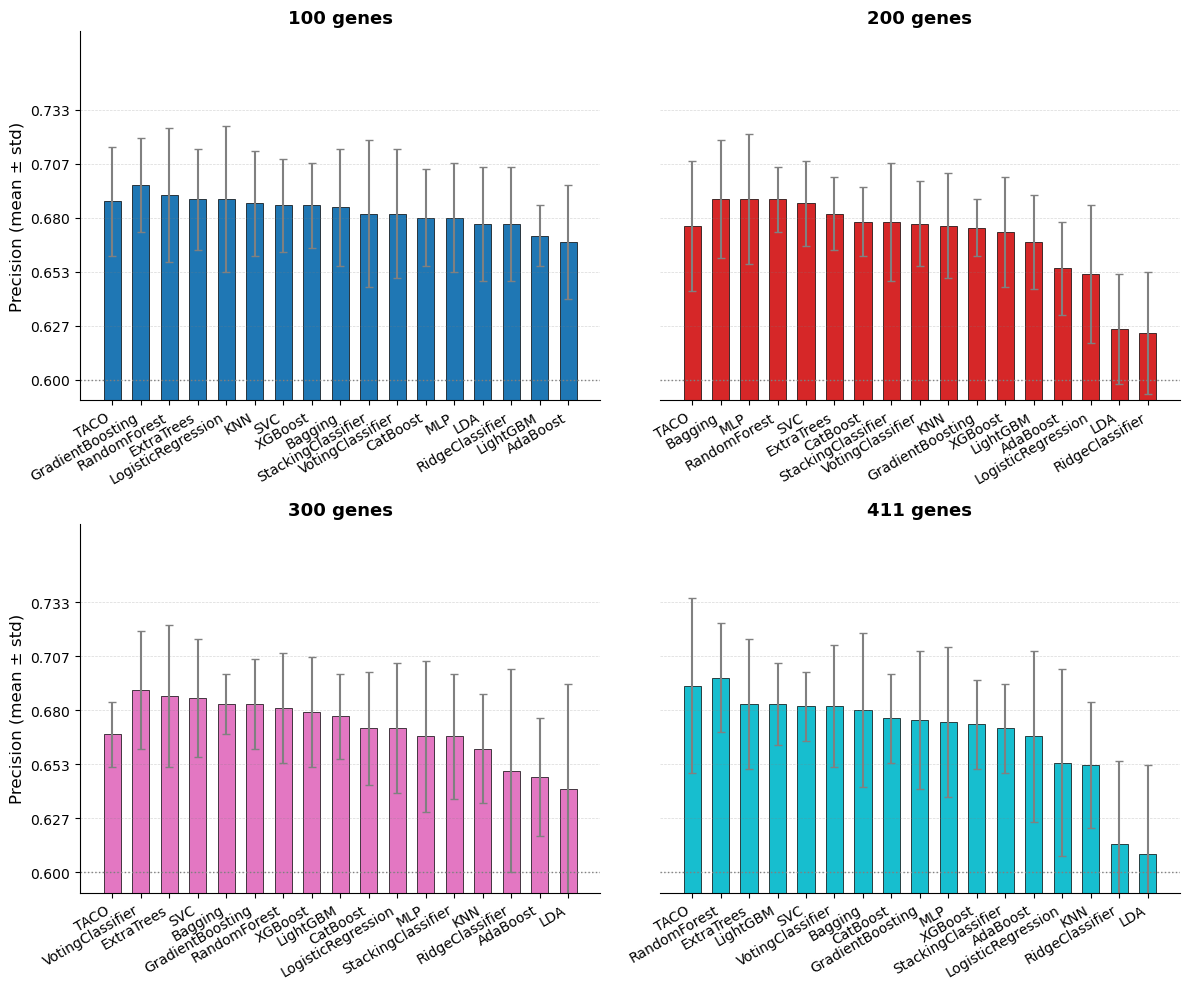

In [91]:
input_folder  = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results"
output_folder = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results/Plots/Grouped"

facet2x2_plot_metric_bars(
    input_dir=input_folder,
    output_dir=output_folder,
    metric="Precision",    # or "Accuracy", "ROC AUC", etc.
    file_pattern="*.csv",
    sep=",",
    y_cutoff=0.60,
    palette="tab10"
)


100 genes - Model ordering and ROC AUC scores:
1. TACO: 0.6670
2. SVC: 0.6830
3. MLP: 0.6570
4. ExtraTrees: 0.6540
5. VotingClassifier: 0.6480
6. RandomForest: 0.6470
7. CatBoost: 0.6460
8. StackingClassifier: 0.6340
9. Bagging: 0.6260
10. GradientBoosting: 0.6200
11. LogisticRegression: 0.6180
12. XGBoost: 0.6170
13. KNN: 0.6120
14. LDA: 0.6070
15. LightGBM: 0.6020
16. AdaBoost: 0.5840
17. RidgeClassifier: 0.5800

200 genes - Model ordering and ROC AUC scores:
1. TACO: 0.6430
2. RandomForest: 0.6640
3. SVC: 0.6600
4. MLP: 0.6500
5. CatBoost: 0.6460
6. ExtraTrees: 0.6430
7. XGBoost: 0.6370
8. StackingClassifier: 0.6320
9. VotingClassifier: 0.6230
10. Bagging: 0.6190
11. KNN: 0.6190
12. GradientBoosting: 0.6170
13. LightGBM: 0.6140
14. AdaBoost: 0.5610
15. LogisticRegression: 0.5550
16. LDA: 0.5380
17. RidgeClassifier: 0.5040

300 genes - Model ordering and ROC AUC scores:
1. TACO: 0.6480
2. ExtraTrees: 0.6570
3. SVC: 0.6570
4. CatBoost: 0.6470
5. RandomForest: 0.6410
6. StackingClassi

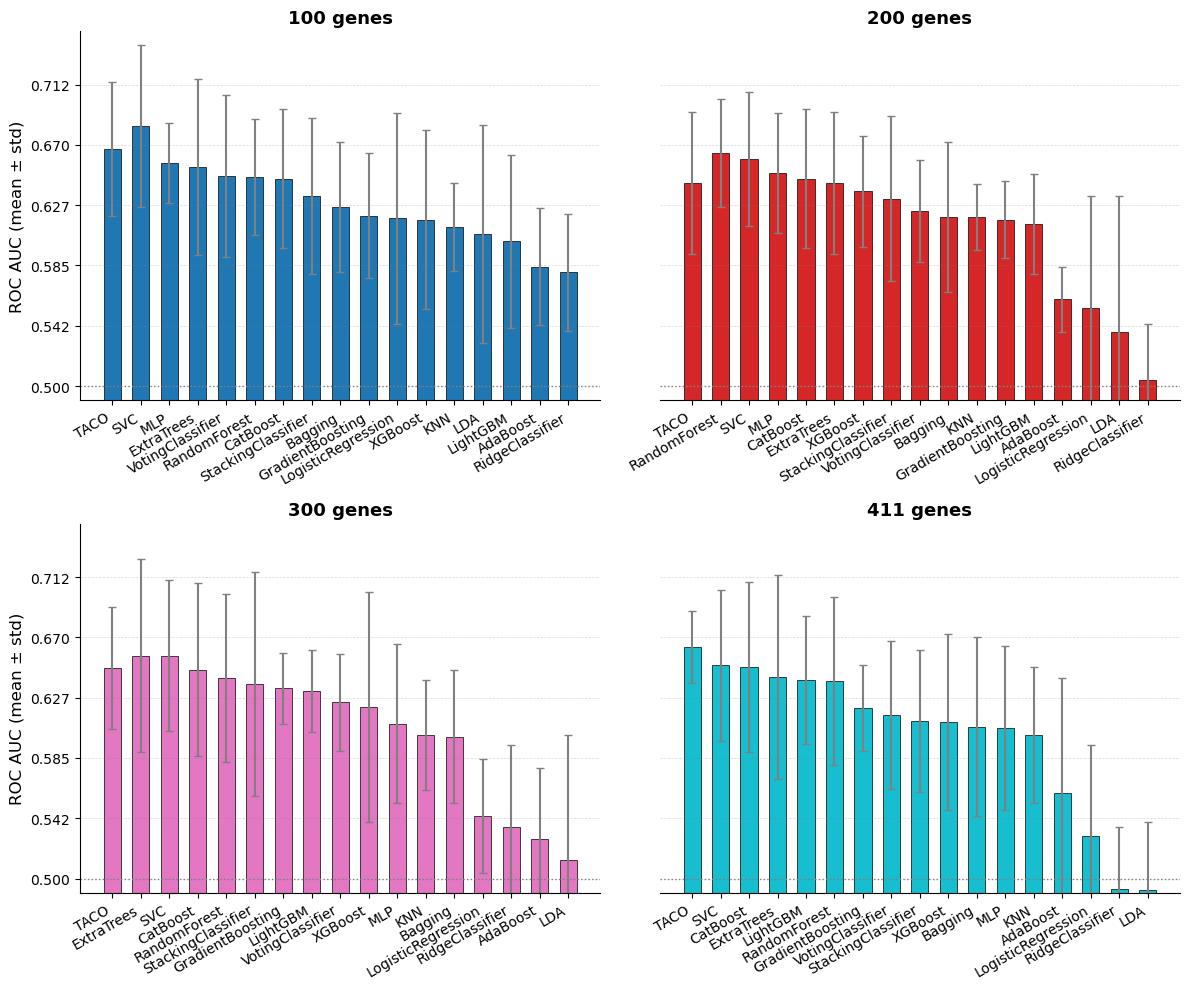

In [ ]:
# Call the function to create a 2x2 facet plot of metric bars for gene sets
input_folder  = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results"
output_folder = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results/Plots/Grouped"

facet2x2_plot_metric_bars(
    input_dir=input_folder,
    output_dir=output_folder,
    metric="ROC AUC",    # or "Accuracy", "ROC AUC", etc.
    file_pattern="*.csv",
    sep=",",
    y_cutoff=0.50,
    palette="tab10"
)

## **ROC AUC**

In [94]:
# Define a function to plot ROC curves for the top models from two datasets
def plot_feature_selection_comparison_roc(
    mvg_probs_csv: str,
    dce_probs_csv: str,
    output_png: str,
    top_n: int = 3,
    interp_points: int = 100,
    figsize: tuple = (10, 8)
):
    """
    Creates a single ROC plot comparing feature selection methods:
    - MVG: Standard most variable genes (500 genes)
    - DCE: Your pathway-based feature selection (411 genes)
    
    Shows top_n models plus TabPFN (always included) for each method,
    demonstrating the improvement from your feature selection approach.
    
    Parameters:
    -----------
    mvg_probs_csv : str
        Path to CSV with MVG predictions (500 most variable genes)
    dce_probs_csv : str
        Path to CSV with DCE predictions (411 pathway-selected genes)
    output_png : str
        Path to save the comparison plot
    top_n : int, default=3
        Number of top models to include (plus TabPFN)
    interp_points : int, default=100
        Number of points for ROC curve interpolation
    figsize : tuple, default=(10, 8)
        Figure size (width, height)
    """

    def compute_foldwise_aucs_and_rocs(df_long: pd.DataFrame):
        """
        For a DataFrame with columns [Subject_ID, True_Label, Predicted_Prob, Model, Fold],
        returns:
          - foldwise_aucs: { model_name: [auc_fold1, auc_fold2, …] }
          - foldwise_rocs: { model_name: [(fpr1, tpr1), (fpr2, tpr2), …] }
        """
        foldwise_aucs = {}
        foldwise_rocs = {}

        # Group by model, then within each model group by fold
        for model_name, df_model in df_long.groupby("Model"):
            aucs = []
            rocs = []
            for fold, df_fold in df_model.groupby("Fold"):
                y_true = df_fold["True_Label"].astype(int).values
                y_score = df_fold["Predicted_Prob"].astype(float).values
                fpr, tpr, _ = roc_curve(y_true, y_score)
                fold_auc = auc(fpr, tpr)
                aucs.append(fold_auc)
                rocs.append((fpr, tpr))
            foldwise_aucs[model_name] = aucs
            foldwise_rocs[model_name] = rocs

        return foldwise_aucs, foldwise_rocs

    def select_top_models(foldwise_aucs: dict, n: int):
        """
        Given foldwise_aucs = {model: [auc1, auc2, …]},
        returns a list of model names sorted by mean(AUC) descending,
        taking top n, but always including 'TabPFN' if present.
        """
        # Compute mean AUC per model
        mean_aucs = {m: np.mean(aucs) for m, aucs in foldwise_aucs.items()}
        # Sort by mean AUC descending
        sorted_pairs = sorted(mean_aucs.items(), key=lambda x: x[1], reverse=True)
        top_pairs = sorted_pairs[:n]
        top_models = [m for m, _ in top_pairs]

        # Ensure TabPFN is included
        if "TabPFN" in mean_aucs and "TabPFN" not in top_models:
            top_models.append("TabPFN")

        # Re-sort the final list by mean AUC descending
        final_pairs = [(m, mean_aucs[m]) for m in top_models]
        final_sorted = sorted(final_pairs, key=lambda x: x[1], reverse=True)
        return [m for m, _ in final_sorted], mean_aucs

    def compute_mean_roc(fold_rocs: list, common_fpr: np.ndarray):
        """
        Given a list of fold ROC curves [(fpr1, tpr1), (fpr2, tpr2), …]
        and a common_fpr grid, interpolate each fold's TPR onto common_fpr,
        then return the mean_tpr array.
        """
        tprs_interp = []
        for fpr, tpr in fold_rocs:
            # np.interp returns tpr at each common_fpr point
            interp_tpr = np.interp(common_fpr, fpr, tpr)
            # Ensure endpoints are exactly (0,0) and (1,1)
            interp_tpr[0] = 0.0
            interp_tpr[-1] = 1.0
            tprs_interp.append(interp_tpr)
        mean_tpr = np.mean(tprs_interp, axis=0)
        return mean_tpr

    # ─── 1. Read both datasets ─────────────────────────────────────────
    print("Loading prediction data...")
    mvg_df = pd.read_csv(mvg_probs_csv)
    dce_df = pd.read_csv(dce_probs_csv)
    
    print(f"MVG data: {len(mvg_df)} predictions")
    print(f"DCE data: {len(dce_df)} predictions")

    # ─── 2. Compute fold-wise AUCs and ROC curves for each model ─────────────────
    print("Computing fold-wise ROC curves...")
    mvg_aucs, mvg_rocs = compute_foldwise_aucs_and_rocs(mvg_df)
    dce_aucs, dce_rocs = compute_foldwise_aucs_and_rocs(dce_df)

    # ─── 3. Select top models by mean fold AUC (+ TabPFN) ─────────────────────────
    top_mvg_models, mvg_mean_aucs = select_top_models(mvg_aucs, top_n)
    top_dce_models, dce_mean_aucs = select_top_models(dce_aucs, top_n)

    # Get models that appear in both datasets for direct comparison
    # Priority: take top N from DCE (your method), ensure they exist in MVG
    common_models = []
    for model in top_dce_models:
        if model in mvg_aucs:
            common_models.append(model)
        if len(common_models) >= top_n:
            break
    
    # Always ensure TabPFN is included if it exists in both datasets
    if "TabPFN" in mvg_aucs and "TabPFN" in dce_aucs and "TabPFN" not in common_models:
        if len(common_models) >= top_n:
            common_models = common_models[:-1] + ["TabPFN"]  # Replace last with TabPFN
        else:
            common_models.append("TabPFN")
    
    # Sort by DCE performance for consistent ordering
    common_models = sorted(common_models, key=lambda x: dce_mean_aucs[x], reverse=True)
    print(f"Comparing top {len(common_models)} models: {common_models}")

    # ─── 4. Create figure ────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a common FPR grid for interpolation
    mean_fpr = np.linspace(0, 1, interp_points)
    
    # Color scheme: use distinct colors for each model
    colors = plt.cm.tab10(np.linspace(0, 1, len(common_models)))
    
    # Track improvements for summary
    improvements = []
    
    # ─── 5. Plot ROC curves for comparison ────────────────────────────────────
    for i, model_name in enumerate(common_models):
        color = colors[i]
        
        # Plot MVG (baseline method) - dashed lines
        if model_name in mvg_rocs:
            fold_rocs = mvg_rocs[model_name]
            mean_tpr = compute_mean_roc(fold_rocs, mean_fpr)
            mvg_auc = np.mean(mvg_aucs[model_name])
            ax.plot(
                mean_fpr,
                mean_tpr,
                linestyle='--',
                linewidth=2,
                color=color,
                alpha=0.7,
                label=f"{model_name} (Most variable) AUC = {mvg_auc:.3f}"
            )
        
        # Plot DCE (your method) - solid lines
        if model_name in dce_rocs:
            fold_rocs = dce_rocs[model_name]
            mean_tpr = compute_mean_roc(fold_rocs, mean_fpr)
            dce_auc = np.mean(dce_aucs[model_name])
            ax.plot(
                mean_fpr,
                mean_tpr,
                linestyle='-',
                linewidth=2.5,
                color=color,
                label=f"{model_name} (Pathway-based) AUC = {dce_auc:.3f}"
            )
            
            # Calculate improvement
            if model_name in mvg_aucs:
                improvement = dce_auc - mvg_auc
                improvements.append((model_name, mvg_auc, dce_auc, improvement))

    # Plot the diagonal (random classifier)
    ax.plot([0, 1], [0, 1], "k--", linewidth=1, alpha=0.5, label="Random Classifier")
    
    # ─── 6. Formatting and annotations ────────────────────────────────────────
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.set_title("ROC Comparison: Pathway-Based vs Most Variable Genes Feature Selection", 
                fontsize=14, fontweight='bold', pad=20)
    
    # Create custom legend with combined entries for each model
    from matplotlib.lines import Line2D
    
    legend_elements = []
    
    # Create combined legend entries for each model
    for i, model in enumerate(common_models):
        color = colors[i]
        
        # Get AUC values for this model
        dce_auc = np.mean(dce_aucs[model]) if model in dce_aucs else 0
        mvg_auc = np.mean(mvg_aucs[model]) if model in mvg_aucs else 0
        improvement = dce_auc - mvg_auc
        
        # Create a custom legend entry showing both line styles
        legend_label = f"{model} (Δ={improvement:+.3f})"
        
        # Create custom line element that represents both styles
        legend_elements.append(
            Line2D([0], [0], color=color, linewidth=2.5, linestyle='-',
                   label=legend_label)
        )
    
    # Add random classifier
    legend_elements.append(
        Line2D([0], [0], color='black', linewidth=1, linestyle='--', alpha=0.5,
               label="Random Classifier")
    )
    
    # Create the legend
    legend = ax.legend(handles=legend_elements, loc='center right', 
                      bbox_to_anchor=(1.0, 0.5), fontsize=11, 
                      framealpha=0.9, title="Models (AUC Improvement)")
    legend.get_title().set_fontweight('bold')
    
    # Add a second legend for line style explanation
    line_style_elements = [
        Line2D([0], [0], color='gray', linewidth=2.5, linestyle='-', 
               label="Pathway-based (411 genes)"),
        Line2D([0], [0], color='gray', linewidth=2, linestyle='--', alpha=0.7,
               label="Most variable (500 genes)")
    ]
    
    legend2 = ax.legend(handles=line_style_elements, loc='lower right',
                       bbox_to_anchor=(0.98, 0.02), fontsize=10,
                       framealpha=0.9, title="Feature Selection Methods")
    legend2.get_title().set_fontweight('bold')
    
    # Add both legends to the plot
    ax.add_artist(legend)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # ─── 7. Save and display ──────────────────────────────────────────────────
    plt.tight_layout()
    plt.savefig(output_png, dpi=300, bbox_inches='tight')
    print(f"\n✅ ROC comparison plot saved: {output_png}")
    
    # Print improvement summary
    if improvements:
        print("\n" + "="*50)
        print("FEATURE SELECTION COMPARISON RESULTS")
        print("="*50)
        print(f"Baseline: Most Variable Genes (500 genes)")
        print(f"Your Method: Pathway-Based Selection (411 genes)")
        print("\nAUC Improvements:")
        for model, mvg_auc, dce_auc, improvement in improvements:
            direction = "IMPROVED" if improvement > 0 else "DECREASED" if improvement < 0 else "SAME"
            print(f"  {model:15s}: {mvg_auc:.3f} → {dce_auc:.3f} ({improvement:+.3f}) [{direction}]")
        
        avg_improvement = np.mean([imp for _, _, _, imp in improvements])
        print(f"\nAverage AUC improvement: {avg_improvement:+.3f}")
        
        improved_count = sum(1 for _, _, _, imp in improvements if imp > 0)
        print(f"Models improved: {improved_count}/{len(improvements)}")
    
    plt.show()
    
    return improvements

In [ ]:
input_folder  = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results"
output_folder = "/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results/Plots/Grouped"


In [ ]:
# Call the main function to plot feature selection comparison ROC curves
if __name__ == "__main__":
    improvements = plot_feature_selection_comparison_roc(
        mvg_probs_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/500MVG/TabPFN_ROC_Probs_500MVG.csv",
        dce_probs_csv="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/12_ALL/Average/411DCEG_Paths/TabPFN_ROC_Probs_411DCEG_Paths.csv",
        output_png="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results/Plots/Grouped/facet2x2_ROC AUC.png",
        top_n=3
    )


100 genes - Top 5 models (ROC AUC scores):
1. TACO: 0.6670
2. SVC: 0.6830
3. MLP: 0.6570
4. ExtraTrees: 0.6540
5. VotingClassifier: 0.6480

200 genes - Top 5 models (ROC AUC scores):
1. TACO: 0.6430
2. RandomForest: 0.6640
3. SVC: 0.6600
4. MLP: 0.6500
5. CatBoost: 0.6460

300 genes - Top 5 models (ROC AUC scores):
1. TACO: 0.6480
2. ExtraTrees: 0.6570
3. SVC: 0.6570
4. CatBoost: 0.6470
5. RandomForest: 0.6410

411 genes - Top 5 models (ROC AUC scores):
1. TACO: 0.6630
2. SVC: 0.6500
3. CatBoost: 0.6490
4. ExtraTrees: 0.6420
5. LightGBM: 0.6400

✅ Faceted ROC AUC plot saved: /mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results/Plots/Grouped/facet2x2_ROC_AUC_top5.png


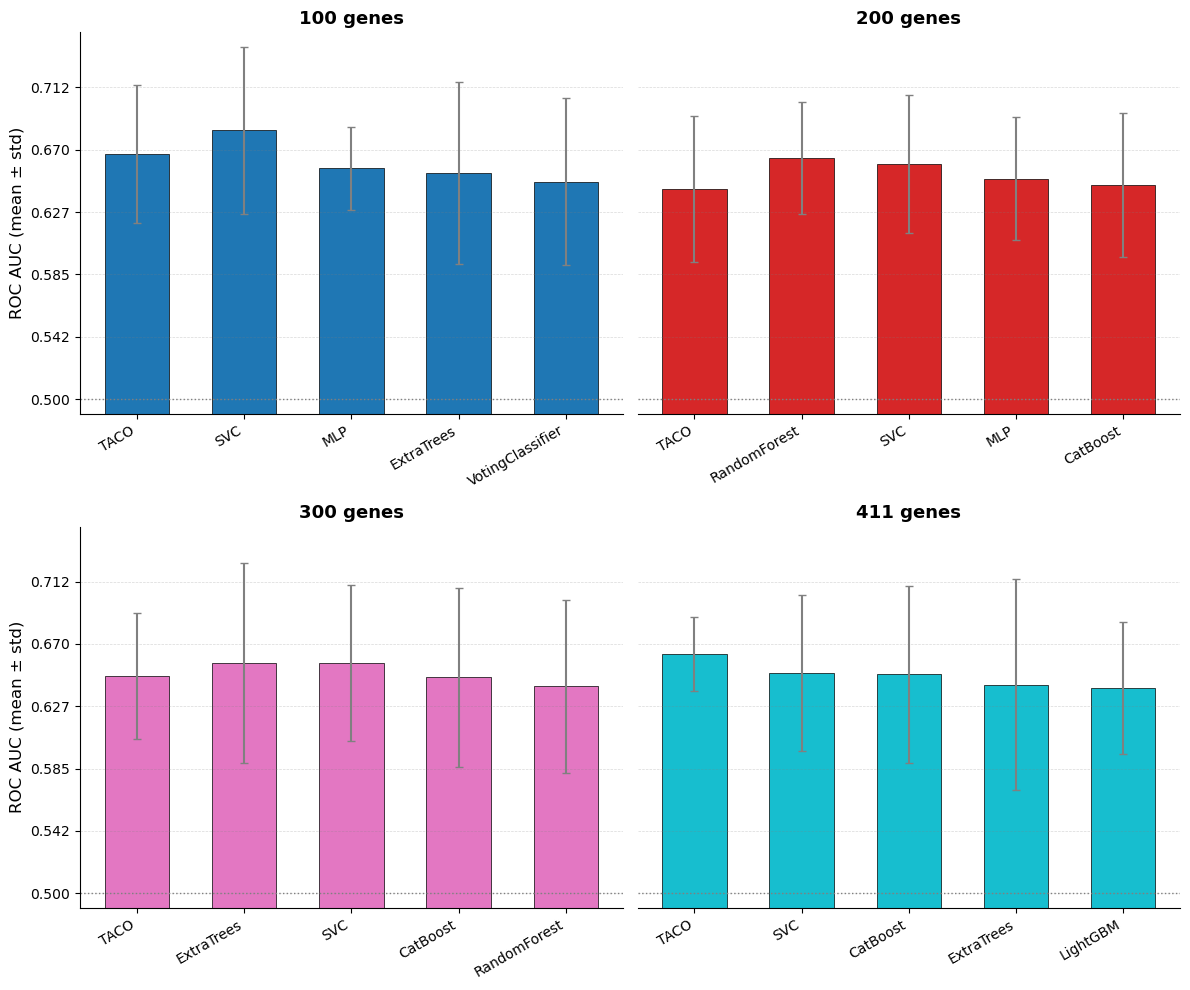

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

def facet2x2_plot_roc_auc_bars(
    input_dir: str,
    output_dir: str,
    top_n: int = 5,
    file_pattern: str = "*.csv",
    sep: str = ",",
    y_cutoff: float = 0.5,
    palette: str = "tab10"
):
    """
    Read model results tables from `input_dir` whose filenames begin with a gene count
    (e.g., "100MVG_1.csv", "200MVG_1.csv", "300MVG_1.csv", "411MVG_1.csv"). Create a 2×2 grid
    of subplots (facets), one for each gene set, showing a bar chart of ROC AUC
    (mean ± std) for the top N performing models. Models are ordered separately for each gene set.

    The model ordering on the x-axis for each subplot is:
      1. 'TabPFN' (renamed to 'TACO' in labels) always first if present.
      2. Top N-1 other models sorted by their ROC AUC performance for that specific gene set
         in descending order (ignoring standard deviations).

    Parameters
    ----------
    input_dir : str
        Folder containing your gene set CSVs.
    output_dir : str
        Folder where the final faceted figure (PNG) will be saved.
    top_n : int, optional
        Total number of top models to display (including TabPFN if present). Defaults to 5.
    file_pattern : str, optional
        Glob pattern for matching table files. Defaults to "*.csv".
    sep : str, optional
        Delimiter used in your files. Defaults to ",". If TSV, use sep="\t".
    y_cutoff : float, optional
        Horizontal cutoff line drawn at this value (e.g., 0.50). Defaults to 0.5.
    palette : str, optional
        Name of a Matplotlib colormap or palette for the bar colors. Defaults to "tab10".
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    mean_col = "ROC AUC_mean"
    std_col = "ROC AUC_std"

    # 1. Gather data from each CSV, keyed by gene_set → model → (mean, std)
    data = {}       # data[model][gene_set] = (mean, std)
    gene_sets = set()
    for table_file in input_path.glob(file_pattern):
        stem = table_file.stem
        m = re.match(r"^(\d+)", stem)
        if not m:
            continue
        gs = m.group(1)
        gene_sets.add(gs)

        df = pd.read_csv(table_file, sep=sep)
        if not {"Model", mean_col, std_col}.issubset(df.columns):
            print(f"Skipping {table_file.name}: missing '{mean_col}' or '{std_col}'.")
            continue

        for _, row in df.iterrows():
            mdl = row["Model"]
            mean_val = row[mean_col]
            std_val = row[std_col]
            data.setdefault(mdl, {})[gs] = (mean_val, std_val)

    if not data:
        print("No valid data found in input directory. Check file names and columns.")
        return

    # 2. Sort gene_sets numerically, then ensure exactly four sets (e.g., ["100","200","300","411"])
    gene_sets = sorted(gene_sets, key=lambda x: int(x))
    if len(gene_sets) != 4:
        print(f"Expected exactly 4 gene-sets, found {len(gene_sets)}: {gene_sets}")
        return

    # 3. For each gene set, determine top N model ordering separately
    #    - 'TabPFN' first (rename to 'TACO' later) if present
    #    - then top N-1 other models sorted by ROC AUC performance for that specific gene set
    all_models = list(data.keys())
    
    # Create separate orderings for each gene set
    models_order_per_gs = {}
    for gs in gene_sets:
        # Get ROC AUC scores for this gene set only
        gs_scores = {}
        for mdl in all_models:
            if gs in data[mdl]:
                gs_scores[mdl] = data[mdl][gs][0]  # mean value for this gene set
            else:
                gs_scores[mdl] = 0.0
        
        # Build top N ordering for this gene set
        if "TabPFN" in all_models:
            # TabPFN first, then top N-1 others
            other_models = [m for m in all_models if m != "TabPFN"]
            other_models_sorted = sorted(other_models, key=lambda m: gs_scores[m], reverse=True)
            # Take top N-1 other models (since TabPFN takes one spot)
            top_others = other_models_sorted[:top_n-1]
            models_order_per_gs[gs] = ["TabPFN"] + top_others
        else:
            # No TabPFN, just take top N models
            all_models_sorted = sorted(all_models, key=lambda m: gs_scores[m], reverse=True)
            models_order_per_gs[gs] = all_models_sorted[:top_n]
        
        # Debug: Print ordering for this gene set
        print(f"\n{gs} genes - Top {len(models_order_per_gs[gs])} models (ROC AUC scores):")
        for i, mdl in enumerate(models_order_per_gs[gs]):
            score = gs_scores[mdl]
            display_name = "TACO" if mdl == "TabPFN" else mdl
            print(f"{i+1}. {display_name}: {score:.4f}")

    # Get maximum number of models across all gene sets for consistent plotting
    max_models = max(len(models_order_per_gs[gs]) for gs in gene_sets)

    # 4. Create a 2×2 grid of subplots, sharing y-axis
    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        sharey=True,
        figsize=(12, 10)
    )

    # Flatten axes array for easy indexing: 
    # [ (0,0)=100 genes, (0,1)=200 genes, (1,0)=300 genes, (1,1)=411 genes ]
    axes_flat = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]

    cmap = plt.get_cmap(palette)
    colors = cmap(np.linspace(0, 1, 4))  # one color per gene_set

    bar_width = 0.6

    for j, gs in enumerate(gene_sets):
        ax = axes_flat[j]
        
        # Use the specific ordering for this gene set
        models_order = models_order_per_gs[gs]
        x = np.arange(len(models_order))
        
        # Build data arrays for this gene set in the correct order
        heights = []
        errors = []
        for mdl in models_order:
            if gs in data[mdl]:
                mean_val, std_val = data[mdl][gs]
                heights.append(mean_val)
                errors.append(std_val)
            else:
                heights.append(0.0)
                errors.append(0.0)
        
        heights = np.array(heights)
        errors = np.array(errors)

        # Plot bars (no numeric annotations on top)
        bars = ax.bar(
            x,
            heights,
            width=bar_width,
            color=colors[j],
            edgecolor="black",
            linewidth=0.5,
            yerr=errors,
            capsize=3,
            ecolor="gray"
        )

        # Horizontal cutoff line at y_cutoff
        ax.axhline(y=y_cutoff, color="gray", linestyle=":", linewidth=1)

        # Subplot title indicating gene_set
        ax.set_title(f"{gs} genes", fontsize=13, fontweight="semibold")

        # Build x-tick labels, replacing "TabPFN" with "TACO"
        tick_labels = ["TACO" if m == "TabPFN" else m for m in models_order]

        # X-axis tick labels (model names), rotated 30°
        ax.set_xticks(x)
        ax.set_xticklabels(tick_labels, rotation=30, ha="right", fontsize=10)

        # Only show y-axis label on the leftmost column
        if j % 2 == 0:
            ax.set_ylabel("ROC AUC (mean ± std)", fontsize=12)
        else:
            ax.set_yticklabels([])  # hide y-tick labels on right column

        # Set y-axis limits and ticks to show actual values
        if len(heights) > 0:
            top_value = (heights + errors).max() * 1.05
            ax.set_ylim(y_cutoff - 0.01, top_value)
            
            # Create custom y-tick locations with actual values
            # Include the cutoff line and some key data points
            y_ticks = [y_cutoff]
            
            # Add some evenly spaced ticks between cutoff and max
            n_ticks = 5  # number of additional ticks
            tick_range = np.linspace(y_cutoff, top_value * 0.95, n_ticks + 1)[1:]  # exclude first (cutoff)
            y_ticks.extend(tick_range)
            
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{tick:.3f}' for tick in y_ticks])

        # Light horizontal gridlines
        ax.yaxis.grid(True, color="gray", linestyle="--", linewidth=0.5, alpha=0.3)

        # Hide top and right spines for a cleaner look
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # If not on left column, hide the left spine and y-ticks
        if j % 2 == 1:
            ax.spines["left"].set_visible(False)
            ax.tick_params(axis="y", which="both", left=False)

    plt.tight_layout()

    # 5. Save and display
    output_file = output_path / f"facet2x2_ROC_AUC_top{top_n}.png"
    fig.savefig(output_file, dpi=300, bbox_inches="tight")
    print(f"\n✅ Faceted ROC AUC plot saved: {output_file}")
    plt.show()
    plt.close(fig)

# Example usage:
if __name__ == "__main__":
    # Updated function call for ROC AUC analysis
    facet2x2_plot_roc_auc_bars(
        input_dir="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results",
        output_dir="/mnt/c/Users/pinsy007/Downloads/WORKING/Results/Final_Results/Plots/Grouped",
        top_n=5,  # Show top 5 models per gene set
        file_pattern="*.csv",
        sep=",",
        y_cutoff=0.50,
        palette="tab10"
    )